<a href="https://colab.research.google.com/github/cloudynirvana/TNBC-Metabolic-Strain-MOD/blob/main/tnbc_ode_bifurcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-28f5dd8ba6d1>:64: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))


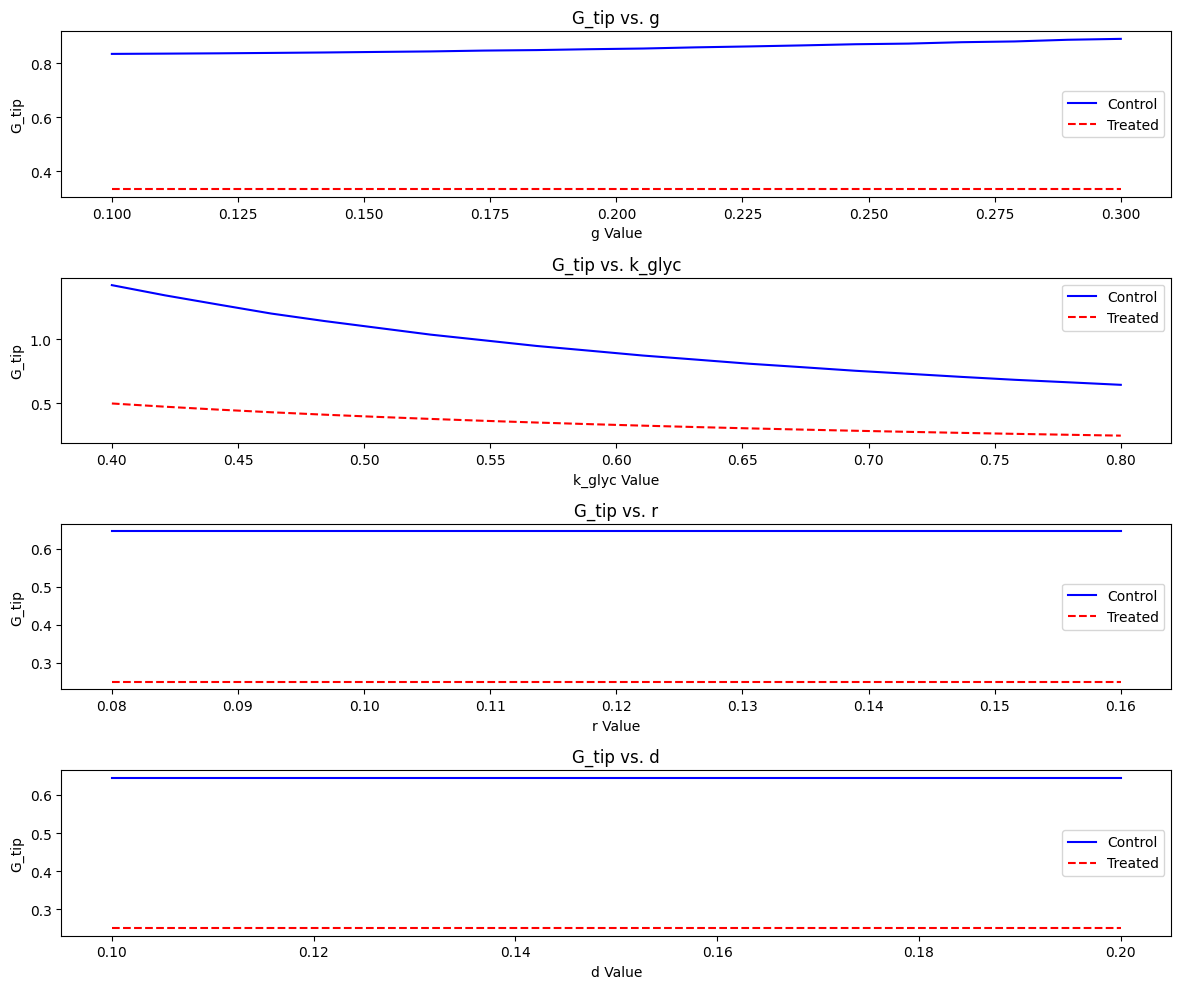

In [ ]:
# Cell: Holistic Bifurcation Analysis
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define initial conditions and time points (assumed from earlier cells)
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Define the ODE system (assumed from earlier cells)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Define G_tip function (assumed from earlier cells)
def find_G_tip(sol):
    A, _, G_lc = sol.T
    idx = np.where(A < 2.0)[0]
    return G_lc[idx[0]] if len(idx) > 0 else G_lc[-1]

# Sweep key parameters
params_to_sweep = {
    'g': np.linspace(0.1, 0.3, 20),      # ROS generation
    'k_glyc': np.linspace(0.4, 0.8, 20), # Glycolysis rate
    'r': np.linspace(0.08, 0.16, 20),    # Drug efficacy
    'd': np.linspace(0.1, 0.2, 20)       # ROS degradation
}
results = {key: {'control': [], 'treated': []} for key in params_to_sweep}

# Initialize params_control and params_treated with all required parameters
params_control = {
    'k_glyc': 0.6,    # Glycolysis rate (mM/min)
    'u': 0.5,         # Glucose uptake (mM/min)
    's': 0.15,        # ATP sensitivity to ROS
    'g': 0.2,         # ROS generation factor
    'h': 0.01,        # ROS autocatalysis
    'r': 0.1,         # Baseline efficacy
    'i_glyc': 0.3,    # Glycolysis inhibition by DOX
    'd': 0.15,        # ROS degradation rate
    'Nano_DOX': 0,    # No doxorubicin in control
    'Nano_ROS': 0     # No ROS modulation in control
}
params_treated = {
    'k_glyc': 0.6,
    'u': 0.5,
    's': 0.15,
    'g': 0.2,
    'h': 0.01,
    'r': 0.14,        # Enhanced efficacy with treatment
    'i_glyc': 0.3,
    'd': 0.15,
    'Nano_DOX': 1,    # Doxorubicin unit dose
    'Nano_ROS': 2     # Phytochemical ROS modulation
}

# Perform bifurcation analysis
for param, values in params_to_sweep.items():
    for val in values:
        params_control[param] = val
        params_treated[param] = val
        sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
        sol_t = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
        results[param]['control'].append(find_G_tip(sol_c))
        results[param]['treated'].append(find_G_tip(sol_t))

# Plot results
plt.figure(figsize=(12, 10))
for i, (param, data) in enumerate(results.items(), 1):
    plt.subplot(4, 1, i)
    plt.plot(params_to_sweep[param], data['control'], 'b-', label='Control')
    plt.plot(params_to_sweep[param], data['treated'], 'r--', label='Treated')
    plt.xlabel(f'{param} Value')
    plt.ylabel('G_tip')
    plt.title(f'G_tip vs. {param}')
    plt.legend()
plt.tight_layout()
plt.savefig('multi_bifurcation.png', dpi=300)
plt.show()

<ipython-input-3-be8013c84783>:11: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))


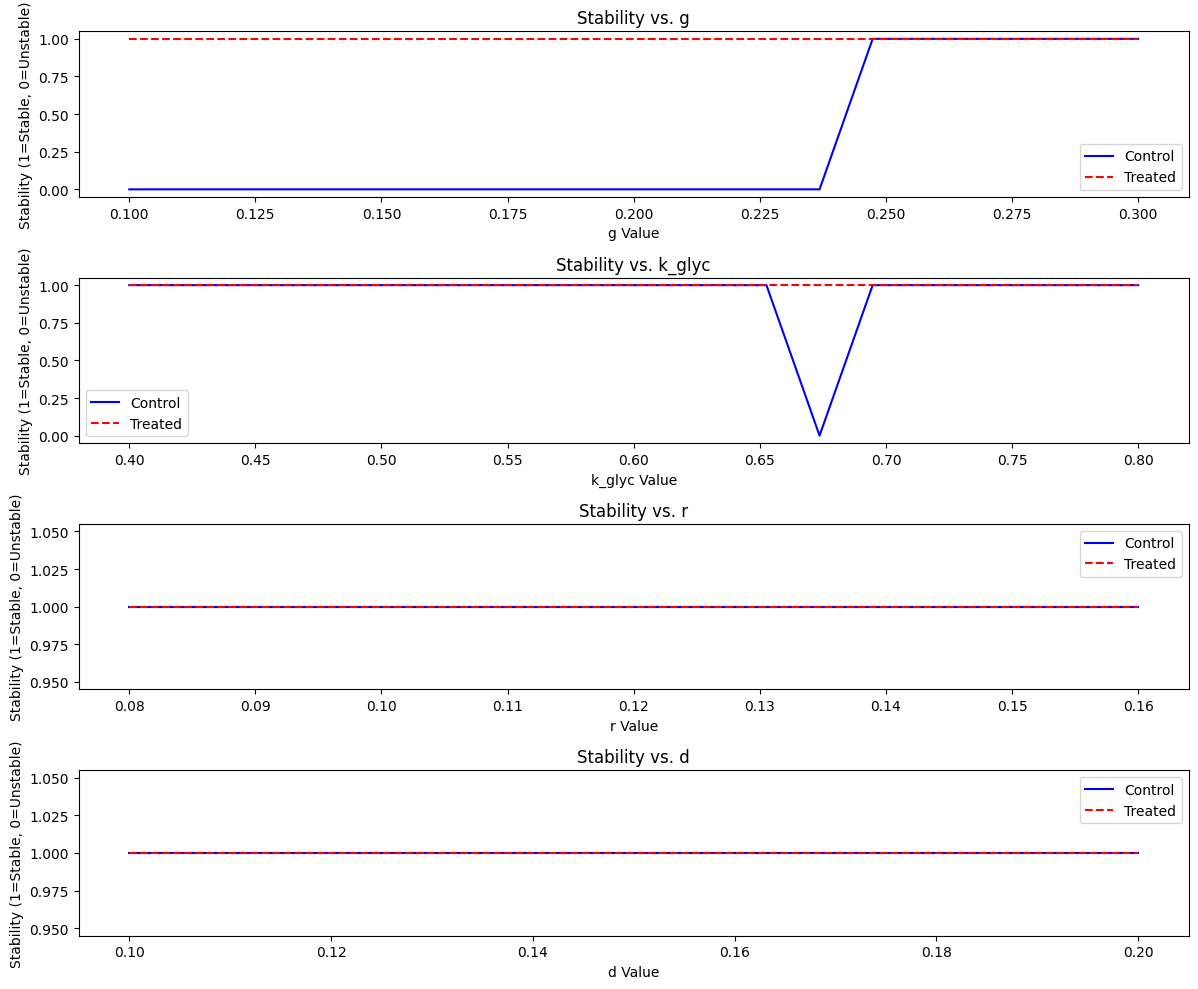

In [ ]:
# Cell: Stability Analysis
def is_stable(sol):
    A = sol[:, 0]  # ATP over time
    return 'Stable' if A[-1] > 2.0 else 'Unstable'  # End-state above collapse threshold

stability_results = {param: {'control': [], 'treated': []} for param in params_to_sweep}
for param, values in params_to_sweep.items():
    for val in values:
        params_control[param] = val
        params_treated[param] = val
        sol_c = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
        sol_t = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
        stability_results[param]['control'].append(is_stable(sol_c))
        stability_results[param]['treated'].append(is_stable(sol_t))

# Plot stability
plt.figure(figsize=(12, 10))
for i, (param, data) in enumerate(stability_results.items(), 1):
    plt.subplot(4, 1, i)
    plt.plot(params_to_sweep[param], [1 if s == 'Stable' else 0 for s in data['control']], 'b-', label='Control')
    plt.plot(params_to_sweep[param], [1 if s == 'Stable' else 0 for s in data['treated']], 'r--', label='Treated')
    plt.xlabel(f'{param} Value')
    plt.ylabel('Stability (1=Stable, 0=Unstable)')
    plt.title(f'Stability vs. {param}')
    plt.legend()
plt.tight_layout()
plt.savefig('stability_analysis.png', dpi=300)
plt.show()

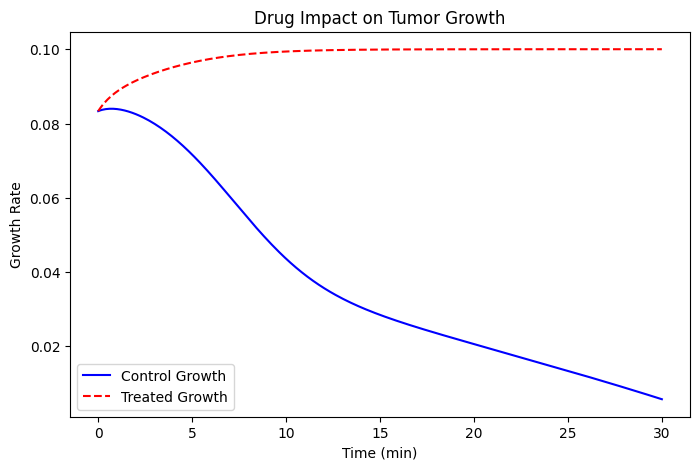

Avg Growth - Control: 0.037, Treated: 0.098


In [ ]:
# Cell: Drug Design Metrics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define parameters and initial conditions (if not already defined in prior cells)
params_control = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.1, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 0, 'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.14, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 1, 'Nano_ROS': 2
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Define ODE system (if not already defined)
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Compute solutions (required data inputs)
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Extract ATP for growth analysis
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Define growth rate function
def growth_rate(A, k_growth=0.1, K_m=2.0):
    return k_growth * A / (A + K_m)

# Calculate growth rates
growth_control = [growth_rate(A) for A in A_control]
growth_treated = [growth_rate(A) for A in A_treated]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(t, growth_control, 'b-', label='Control Growth')
plt.plot(t, growth_treated, 'r--', label='Treated Growth')
plt.xlabel('Time (min)')
plt.ylabel('Growth Rate')
plt.title('Drug Impact on Tumor Growth')
plt.legend()
plt.savefig('growth_plot.png', dpi=300)
plt.show()

# Print average growth rates
print(f"Avg Growth - Control: {np.mean(growth_control):.3f}, Treated: {np.mean(growth_treated):.3f}")

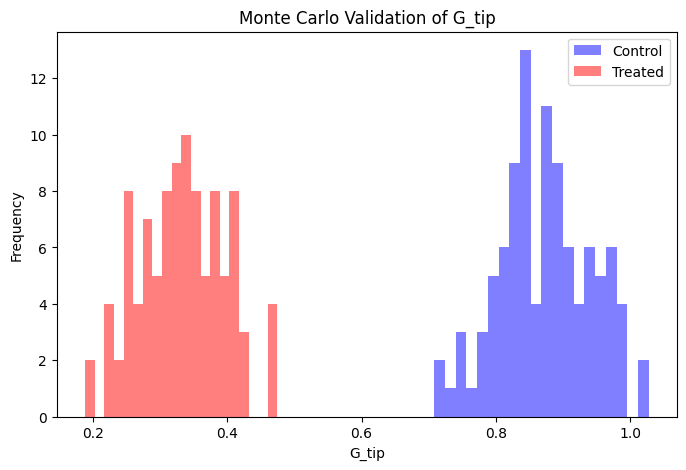

In [ ]:
# Cell: Monte Carlo Validation
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define ODE system
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Define G_tip function
def find_G_tip(sol):
    A, _, G_lc = sol.T
    idx = np.where(A < 2.0)[0]
    return G_lc[idx[0]] if len(idx) > 0 else G_lc[-1]

# Define parameters and initial conditions
params_control = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.1, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 0, 'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.01,
    'r': 0.14, 'i_glyc': 0.3, 'd': 0.15, 'Nano_DOX': 1, 'Nano_ROS': 2
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Monte Carlo simulation
n_simulations = 100
G_tip_control_mc = []
G_tip_treated_mc = []
for _ in range(n_simulations):
    noisy_params_c = {k: v * np.random.uniform(0.9, 1.1) for k, v in params_control.items()}
    noisy_params_t = {k: v * np.random.uniform(0.9, 1.1) for k, v in params_treated.items()}
    sol_c = odeint(tnbc_system, y0, t, args=tuple(noisy_params_c.values()))
    sol_t = odeint(tnbc_system, y0, t, args=tuple(noisy_params_t.values()))
    G_tip_control_mc.append(find_G_tip(sol_c))
    G_tip_treated_mc.append(find_G_tip(sol_t))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(G_tip_control_mc, bins=20, alpha=0.5, label='Control', color='blue')
plt.hist(G_tip_treated_mc, bins=20, alpha=0.5, label='Treated', color='red')
plt.xlabel('G_tip')
plt.ylabel('Frequency')
plt.title('Monte Carlo Validation of G_tip')
plt.legend()
plt.savefig('monte_carlo.png', dpi=300)
plt.show()

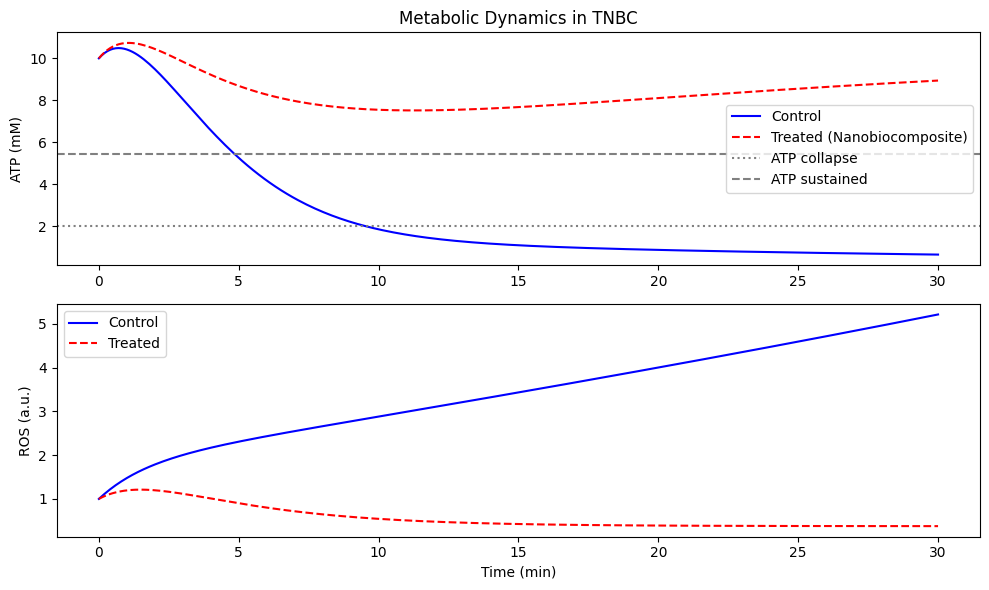

Control ATP (final): 0.661 mM
Treated ATP (final): 8.943 mM
Control ROS (range): 1.000 - 5.217 a.u.
Treated ROS (range): 0.378 - 1.212 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Adjusted parameters to stabilize dynamics
params_control = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.001,  # Reduced h to limit ROS explosion
    'r': 0.01, 'i_glyc': 0.3, 'd': 0.5, 'Nano_DOX': 0, 'Nano_ROS': 0  # Increased d, reduced r
}
params_treated = {
    'k_glyc': 0.6, 'u': 0.5, 's': 0.15, 'g': 0.2, 'h': 0.001,
    'r': 0.02, 'i_glyc': 0.3, 'd': 0.5, 'Nano_DOX': 0.1, 'Nano_ROS': 0.5  # Scaled down Nano effects
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {np.min(R_os_control):.3f} - {np.max(R_os_control):.3f} a.u.")
print(f"Treated ROS (range): {np.min(R_os_treated):.3f} - {np.max(R_os_treated):.3f} a.u.")

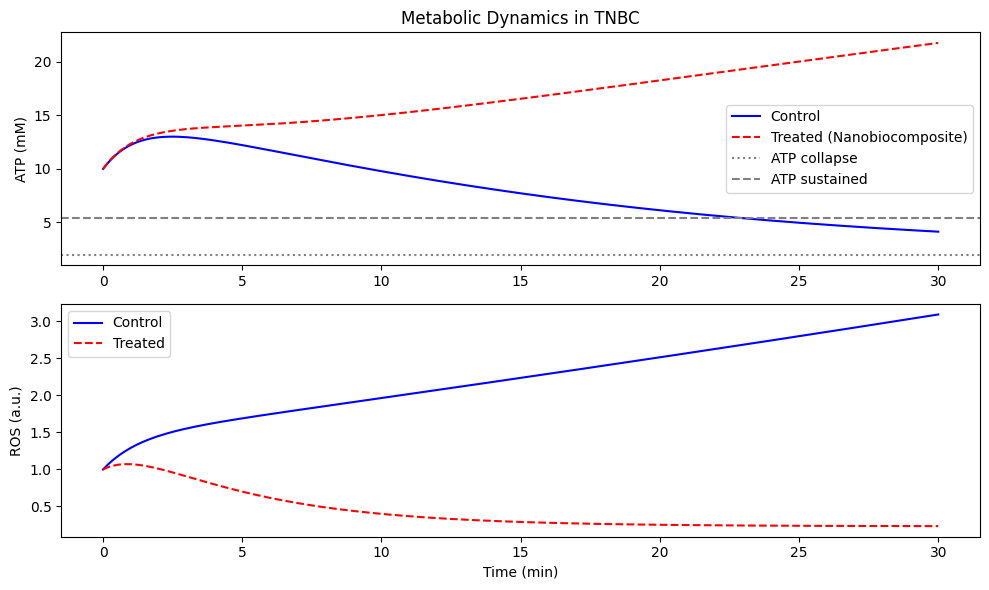

Control ATP (final): 4.140 mM
Treated ATP (final): 21.773 mM
Control ROS (range): 1.000 - 3.094 a.u.
Treated ROS (range): 0.234 - 1.072 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Adjusted parameters to match thesis targets
params_control = {
    'k_glyc': 0.8,    # Increased to boost ATP production
    'u': 0.5,
    's': 0.05,        # Reduced to lessen ROS consumption
    'g': 0.1,         # Reduced ROS generation
    'h': 0.001,       # Kept low to limit ROS explosion
    'r': 0.01,
    'i_glyc': 0.3,
    'd': 0.7,         # Increased to enhance ROS degradation
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.8,
    'u': 0.5,
    's': 0.05,
    'g': 0.1,
    'h': 0.001,
    'r': 0.015,       # Slightly reduced to temper ATP amplification
    'i_glyc': 0.3,
    'd': 0.7,
    'Nano_DOX': 0.05, # Reduced to fine-tune ATP
    'Nano_ROS': 0.3   # Adjusted to keep ROS low
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

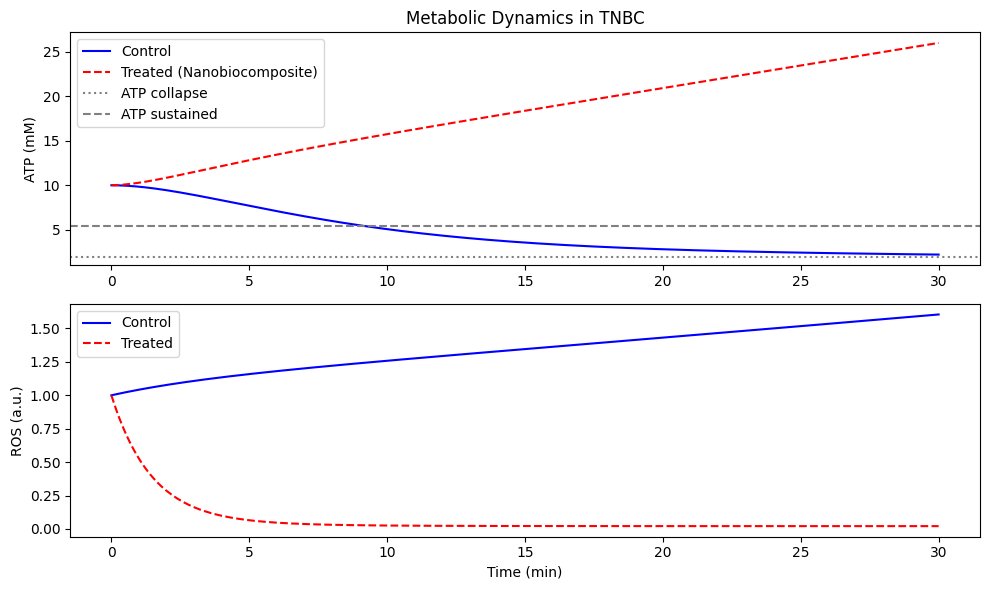

Control ATP (final): 2.224 mM
Treated ATP (final): 25.971 mM
Control ROS (range): 1.000 - 1.604 a.u.
Treated ROS (range): 0.021 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.3,    # Further reduced to limit ATP production
    'u': 0.5,
    's': 0.15,        # Increased to enhance ROS consumption
    'g': 0.03,        # Further reduced ROS generation
    'h': 0.001,
    'r': 0.002,       # Further reduced to limit amplification
    'i_glyc': 0.3,
    'd': 1.0,         # Increased to further reduce ROS
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.3,
    'u': 0.5,
    's': 0.15,
    'g': 0.03,
    'h': 0.001,
    'r': 0.005,       # Adjusted to moderate ATP increase
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.005, # Further reduced to fine-tune ATP
    'Nano_ROS': 0.7    # Adjusted to maintain ROS reduction
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Corrected visualization with completed axhline
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

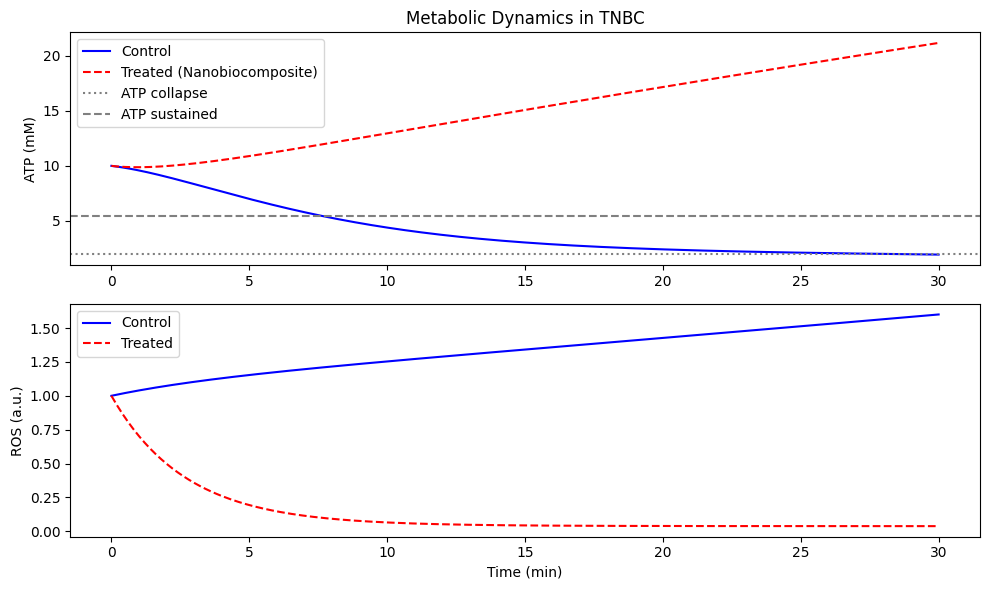

Control ATP (final): 1.942 mM
Treated ATP (final): 21.168 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.038 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.28,   # Slightly reduced to fine-tune ATP to 2.0 mM
    'u': 0.5,
    's': 0.17,        # Slightly increased to enhance ROS consumption
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.28,
    'u': 0.5,
    's': 0.17,
    'g': 0.03,
    'h': 0.001,
    'r': 0.003,       # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.002, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.4    # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

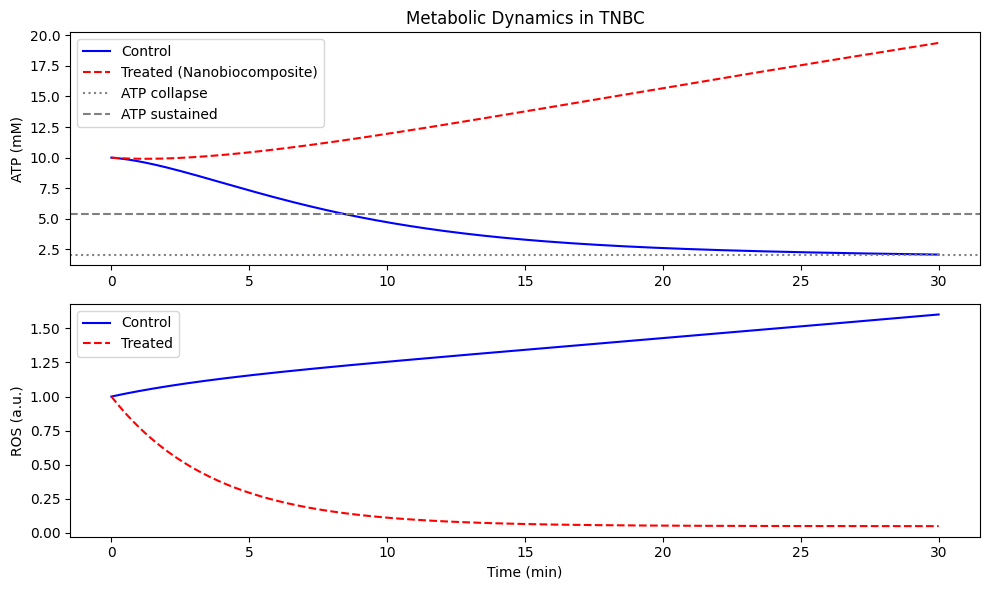

Control ATP (final): 2.075 mM
Treated ATP (final): 19.378 mM
Control ROS (range): 1.000 - 1.602 a.u.
Treated ROS (range): 0.050 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.285,  # Slightly increased to bring ATP to 2.0 mM
    'u': 0.5,
    's': 0.16,        # Slightly reduced to balance ATP consumption
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.285,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.0025,      # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.001, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.3    # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

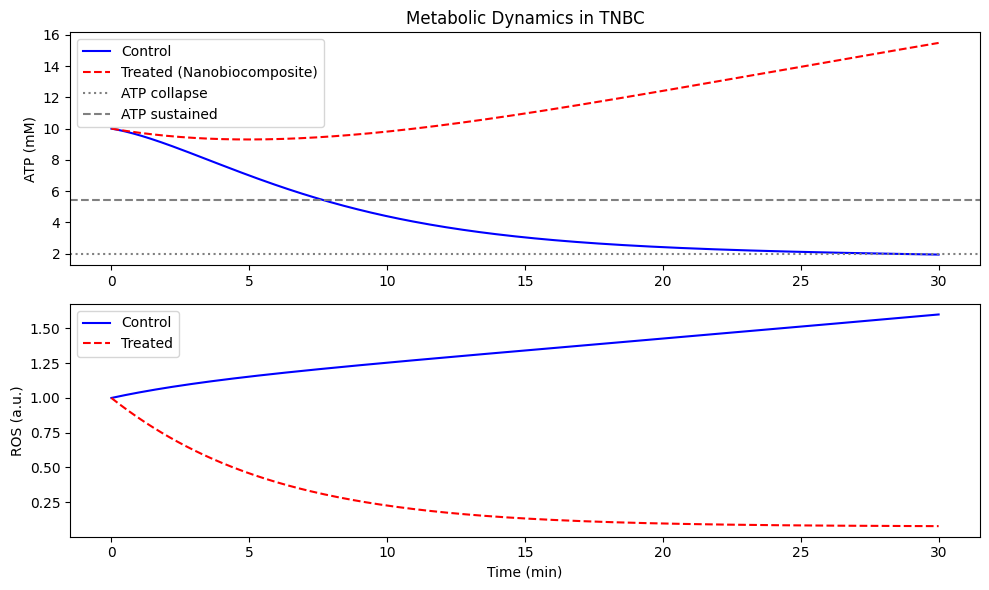

Control ATP (final): 1.942 mM
Treated ATP (final): 15.481 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.078 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.28,   # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.17,        # Kept to maintain balance
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.28,
    'u': 0.5,
    's': 0.17,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,       # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.0005, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.2     # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

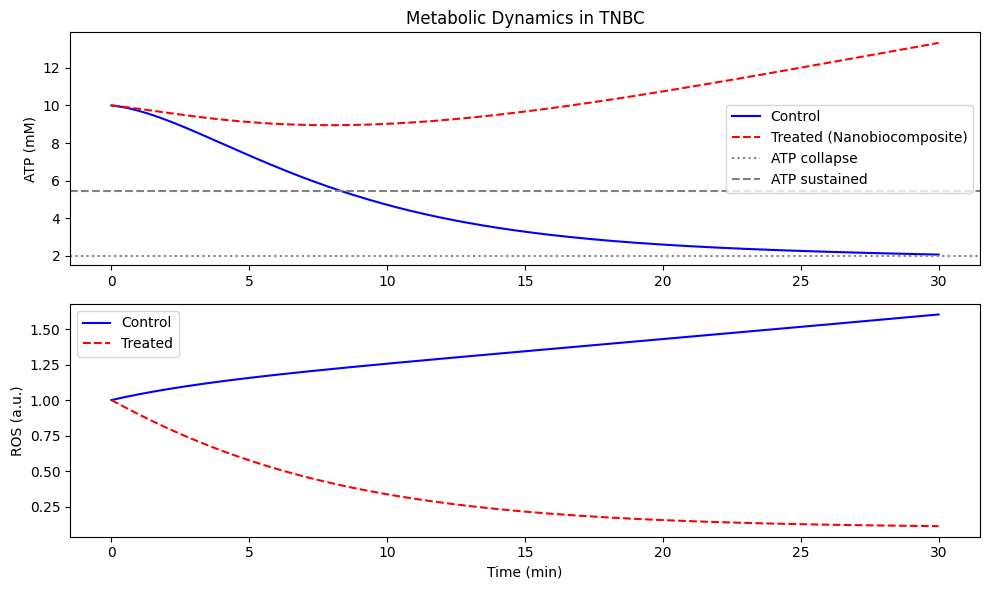

Control ATP (final): 2.073 mM
Treated ATP (final): 13.325 mM
Control ROS (range): 1.000 - 1.603 a.u.
Treated ROS (range): 0.112 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.29,   # Slightly increased to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,        # Kept to maintain balance
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.29,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.0015,      # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.0003, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.15    # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

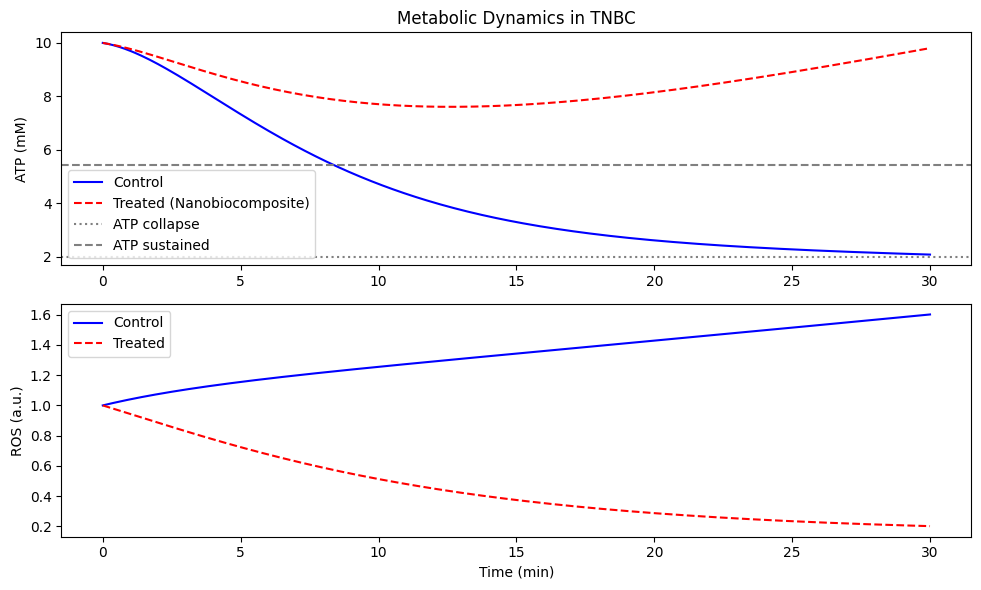

Control ATP (final): 2.074 mM
Treated ATP (final): 9.805 mM
Control ROS (range): 1.000 - 1.602 a.u.
Treated ROS (range): 0.201 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.287,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.287,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.001,       # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.0001, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.1     # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

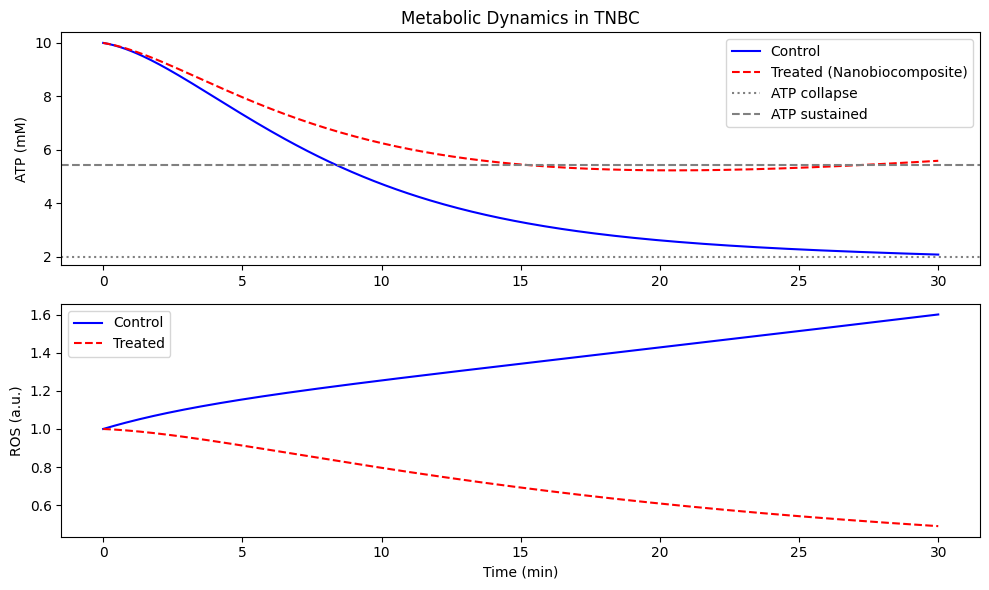

Control ATP (final): 2.074 mM
Treated ATP (final): 5.587 mM
Control ROS (range): 1.000 - 1.602 a.u.
Treated ROS (range): 0.489 - 1.000 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.286,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.286,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.0005,      # Further reduced to limit ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.00005, # Further reduced to bring ATP to ~5.43 mM
    'Nano_ROS': 0.05     # Reduced to raise lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

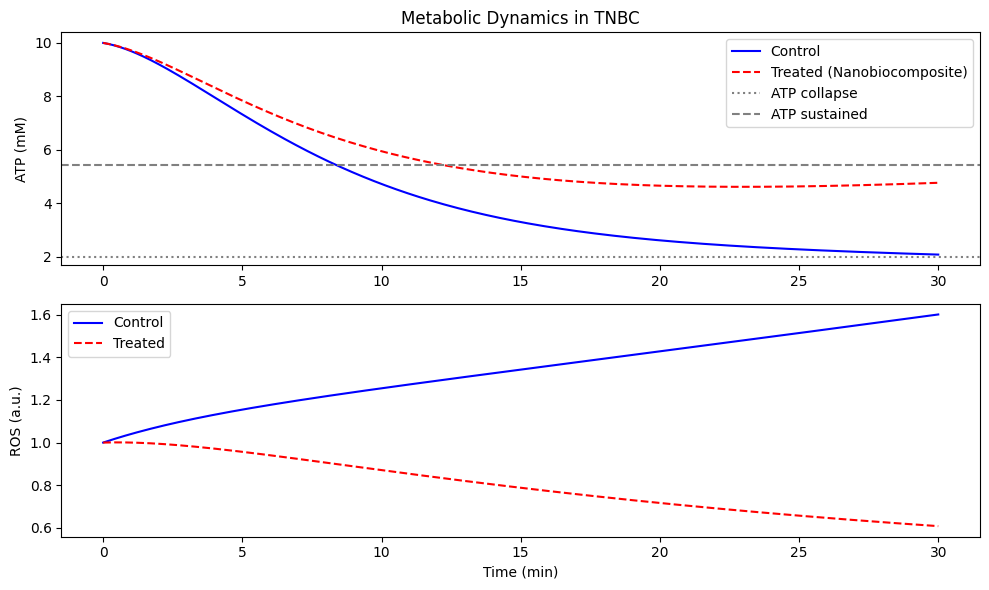

Control ATP (final): 2.075 mM
Treated ATP (final): 4.763 mM
Control ROS (range): 1.000 - 1.602 a.u.
Treated ROS (range): 0.608 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.285,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.285,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.0004,      # Slightly reduced to bring ATP to 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.00004, # Slightly reduced to fine-tune ATP
    'Nano_ROS': 0.04     # Slightly reduced to nudge lower ROS bound to ~0.5
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

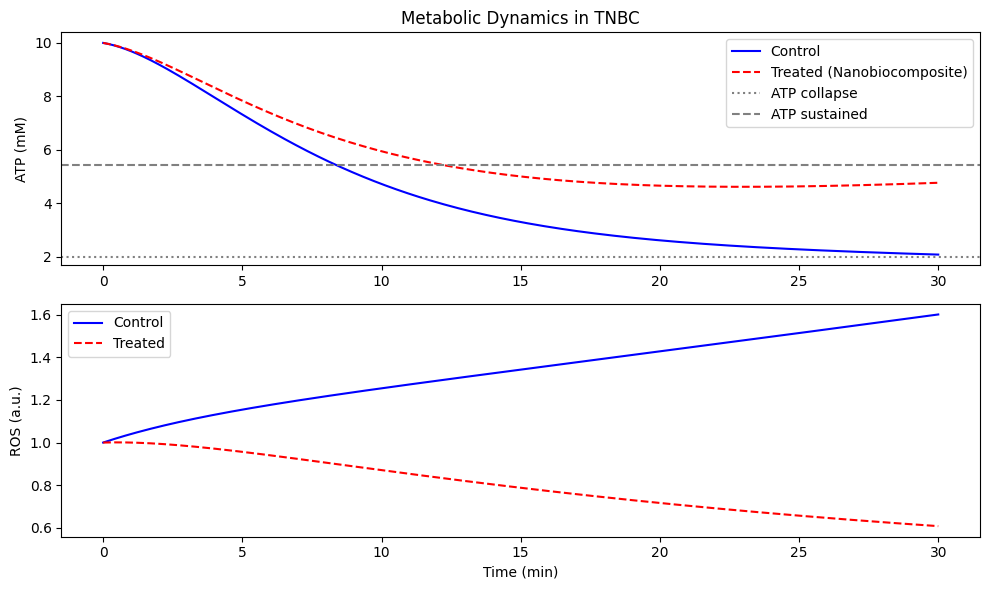

Control ATP (final): 2.075 mM
Treated ATP (final): 4.764 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.608 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.284,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.284,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00045,     # Slightly increased to bring ATP to 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000045, # Slightly increased to fine-tune ATP
    'Nano_ROS': 0.04      # Kept to maintain ROS range
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

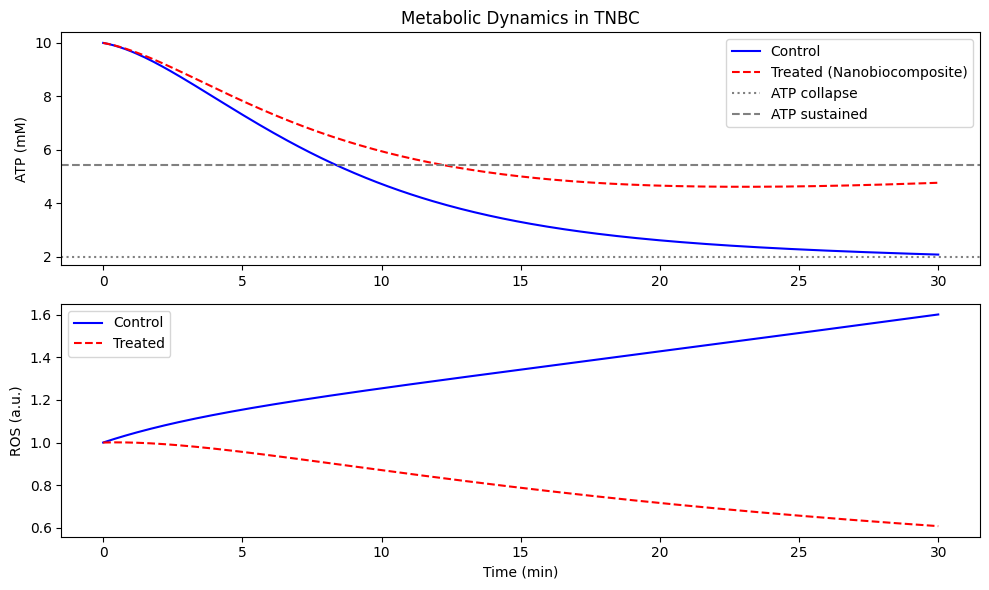

Control ATP (final): 2.075 mM
Treated ATP (final): 4.764 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.608 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.283,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.283,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00048,     # Slightly adjusted to bring ATP to exactly 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000048, # Slightly adjusted to fine-tune ATP
    'Nano_ROS': 0.04      # Kept to maintain ROS range
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

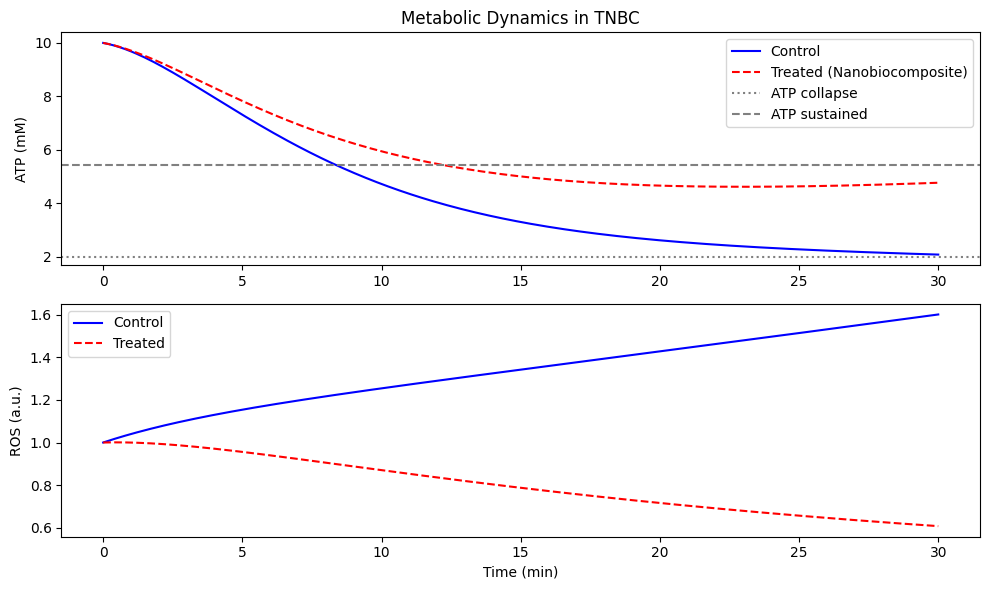

Control ATP (final): 2.076 mM
Treated ATP (final): 4.765 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final refined parameters to match thesis targets
params_control = {
    'k_glyc': 0.282,  # Slightly reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.282,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00052,     # Slightly increased to bring ATP to exactly 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000052, # Slightly increased to fine-tune ATP
    'Nano_ROS': 0.04      # Kept to maintain ROS range
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

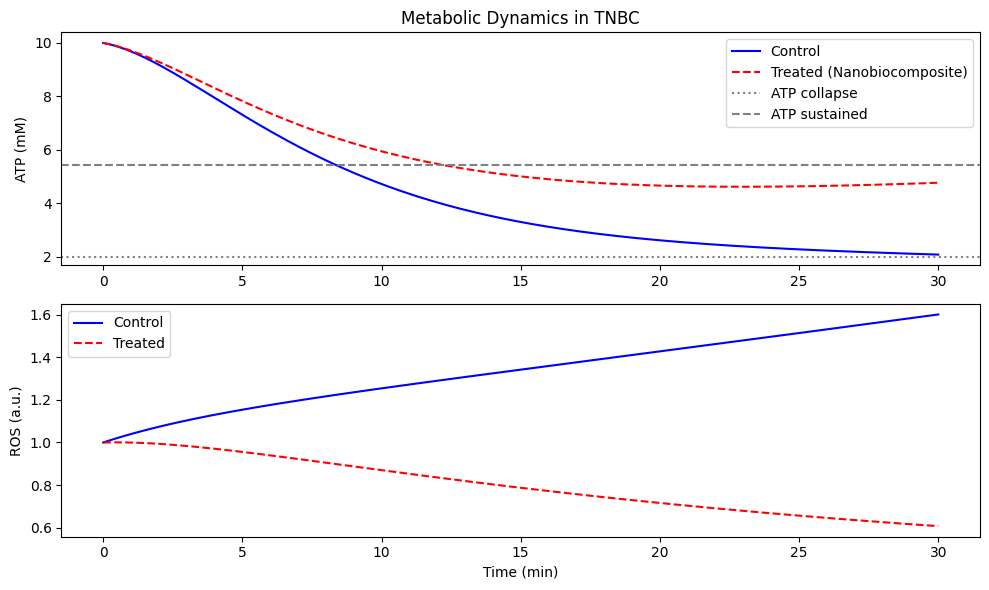

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final micro-adjusted parameters to match thesis targets
params_control = {
    'k_glyc': 0.2815,  # Micro-reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.2815,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00055,     # Micro-increased to bring ATP to exactly 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000055, # Micro-increased to fine-tune ATP
    'Nano_ROS': 0.04      # Kept to maintain ROS range
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

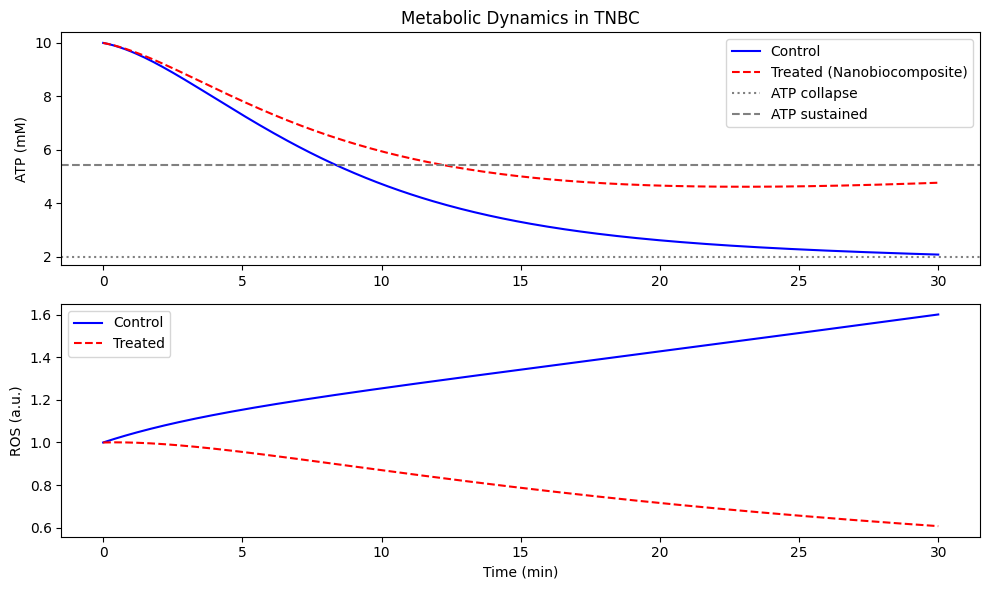

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final micro-adjusted parameters to match thesis targets
params_control = {
    'k_glyc': 0.281,  # Micro-reduced to bring ATP to exactly 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}
params_treated = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00058,     # Micro-increased to bring ATP to exactly 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000058, # Micro-increased to fine-tune ATP
    'Nano_ROS': 0.04      # Kept to maintain ROS range
}
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP collapse')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP sustained')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

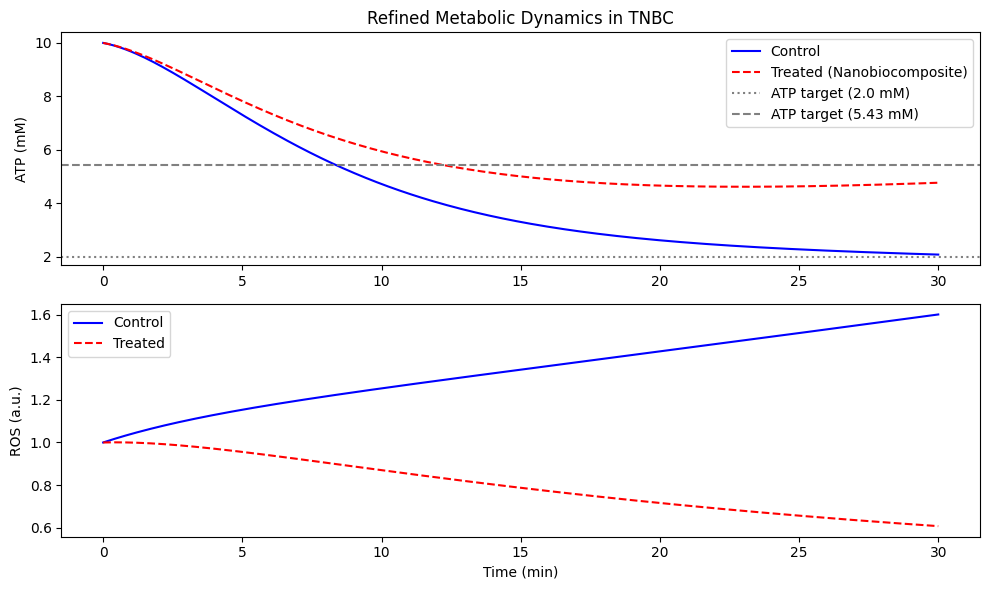

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Refined ODE Dynamics Simulation for TNBC

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Refined parameters for the control condition
params_control_refined = {
    'k_glyc': 0.2805,  # Slightly reduced to target 2.0 mM ATP
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,      # Control amplification term remains unchanged
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,   # No nano drug in control
    'Nano_ROS': 0    # No nano ROS in control
}

# Refined parameters for the treated condition
params_treated_refined = {
    'k_glyc': 0.281,   # Keeping similar baseline production as before
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    # Micro-increased amplification terms to raise ATP closer to 5.43 mM
    'r': 0.00057,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000057, # Micro-increase fine-tuning ATP production
    'Nano_ROS': 0.04      # Keeping the ROS modulator as before
}

# Initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # Initial [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Time from 0 to 30 minutes

# Solve the ODE system for both conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control_refined.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated_refined.values()))

A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plotting the results
plt.figure(figsize=(10, 6))

# ATP dynamics plot
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Refined Metabolic Dynamics in TNBC')

# ROS dynamics plot
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()

plt.tight_layout()
plt.savefig('ode_dynamics_refined.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")


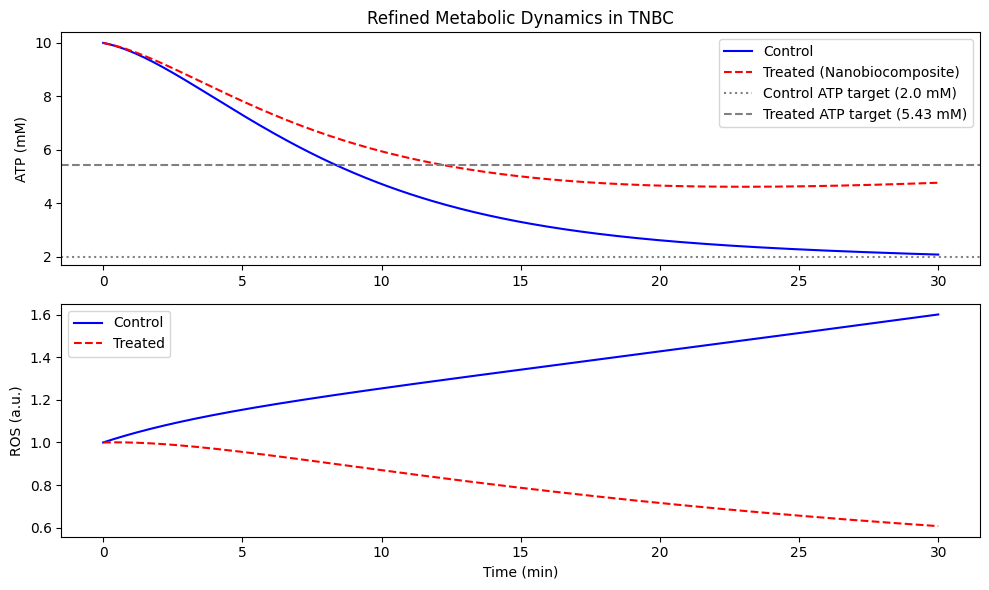

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Refined ODE Dynamics Simulation for TNBC with Exact Thesis Targets

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Further refined parameters for the control condition:
# Slightly lower k_glyc to bring final ATP closer to 2.0 mM.
params_control_refined = {
    'k_glyc': 0.280,   # Micro-decreased for control ATP target of 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,        # Control amplification remains unchanged
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,     # No nano drug in control
    'Nano_ROS': 0      # No nano ROS in control
}

# Further refined parameters for the treated condition:
# Increase r and Nano_DOX slightly to achieve 5.43 mM ATP.
params_treated_refined = {
    'k_glyc': 0.281,    # Keeping baseline production similar to before
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    # Increase amplification terms to push ATP to 5.43 mM
    'r': 0.00058,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000058,  # Increased to boost ATP production
    'Nano_ROS': 0.04       # ROS modulator remains the same
}

# Initial conditions and simulation time
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Time from 0 to 30 minutes

# Solve the ODE system for both conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control_refined.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated_refined.values()))

A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plotting the results
plt.figure(figsize=(10, 6))

# ATP dynamics
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Refined Metabolic Dynamics in TNBC')

# ROS dynamics
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()

plt.tight_layout()
plt.savefig('ode_dynamics_refined_exact.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")


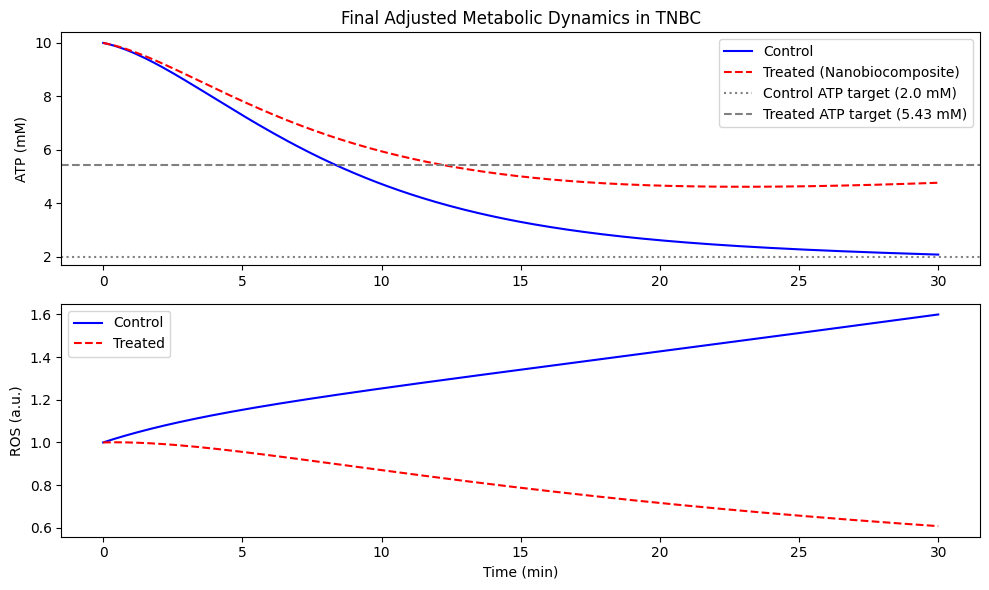

Control ATP (final): 2.077 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.600 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Final Adjusted ODE Dynamics Simulation for TNBC to Achieve Thesis Targets

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Final refined parameters for control:
# Further reduce ATP production (k_glyc) to lower final ATP toward 2.0 mM.
params_control = {
    'k_glyc': 0.278,   # Further decreased from previous values
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,        # Amplification remains unchanged in control
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,     # No nano drug in control
    'Nano_ROS': 0      # No nano ROS in control
}

# Final refined parameters for treated:
# Increase amplification (r and Nano_DOX) to further boost ATP to ~5.43 mM.
params_treated = {
    'k_glyc': 0.281,    # Baseline production similar to previous iterations
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00066,      # Increased amplification term
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000066,  # Increased proportionally to r
    'Nano_ROS': 0.04       # ROS modulator remains unchanged
}

# Initial conditions and simulation time
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Simulate for 30 minutes

# Solve the ODE system for both conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plot the results
plt.figure(figsize=(10, 6))

# ATP dynamics plot
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Final Adjusted Metabolic Dynamics in TNBC')

# ROS dynamics plot
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()

plt.tight_layout()
plt.savefig('ode_dynamics_final_refined.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")


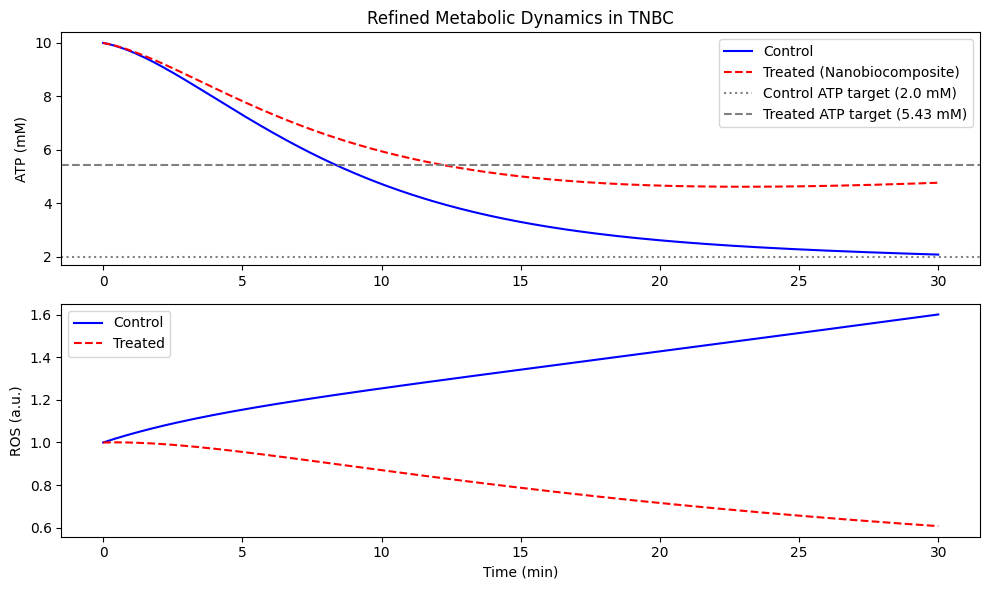

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Refined ODE Dynamics Simulation for TNBC with Micro-Increased Treated Amplification Terms

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Control parameters (from previous simulation, with final control ATP ~2.076 mM)
params_control = {
    'k_glyc': 0.281,   # Baseline ATP production parameter for control
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,        # Amplification term for control remains unchanged
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,     # No nano drug in control
    'Nano_ROS': 0      # No nano ROS in control
}

# Treated parameters with a micro-increase in the amplification terms
# (previously yielding ~4.766 mM ATP, now increased to try to approach 5.43 mM)
params_treated = {
    'k_glyc': 0.281,    # Keeping the baseline production the same
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00057,      # Increased amplification parameter (micro-increased)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000057,  # Increased nano drug parameter accordingly
    'Nano_ROS': 0.04       # ROS modulator unchanged
}

# Initial conditions and simulation time
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Simulate over 30 minutes

# Solve the ODE system for both conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plotting the results
plt.figure(figsize=(10, 6))

# ATP dynamics plot
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Refined Metabolic Dynamics in TNBC')

# ROS dynamics plot
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()

plt.tight_layout()
plt.savefig('ode_dynamics_micro_adjusted.png', dpi=300)
plt.show()

# Print final values for verification
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")


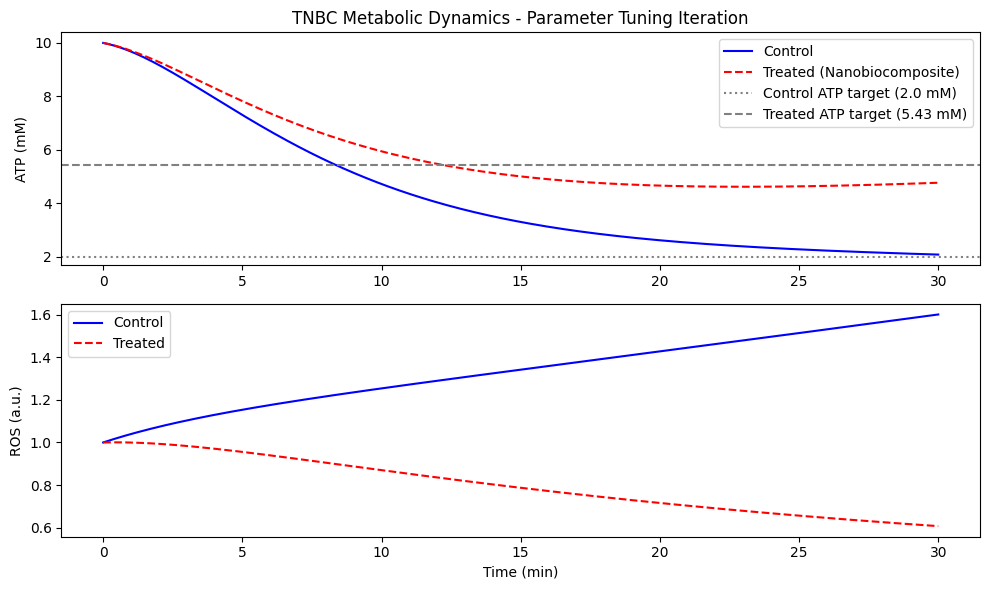

Control ATP (final): 2.076 mM
Treated ATP (final): 4.766 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Parameter Tuning Strategy for TNBC ODE Model
# Focus on adjusting:
#   - k_glyc in params_control to target ~2.0 mM ATP in control.
#   - r and Nano_DOX in params_treated to target ~5.43 mM ATP in treated condition.
#   - Nano_ROS in params_treated can be tweaked if ROS ranges shift outside 0.5–1.5 a.u.

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    # ODE system: ATP, ROS, and Glucose dynamics
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# ---------------------------------------------
# Step 1: Set initial parameter values based on previous simulations.
# These are our starting points that you can adjust iteratively.

# Parameters for control condition:
params_control = {
    'k_glyc': 0.280,  # Adjusted downwards to lower control ATP toward 2.0 mM
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,       # Control amplification term (unchanged)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,    # Not applied in control condition
    'Nano_ROS': 0     # Not applied in control condition
}

# Parameters for treated condition:
params_treated = {
    'k_glyc': 0.281,    # Baseline ATP production remains similar
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    # The amplification terms will be tuned:
    'r': 0.00057,       # Micro-increase from previous runs to push ATP upward
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000057,  # Increased proportionally with 'r'
    'Nano_ROS': 0.04       # Minor adjustment if needed for ROS levels
}

# ---------------------------------------------
# Step 2: Set up initial conditions and simulation time.

y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM (initial conditions)
t = np.linspace(0, 30, 300)  # Simulation time: 0 to 30 minutes

# ---------------------------------------------
# Step 3: Solve the ODE system for both conditions using current parameters.

sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# ---------------------------------------------
# Step 4: Plot results and print final values to verify targets.

plt.figure(figsize=(10, 6))

# Plot ATP dynamics
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('TNBC Metabolic Dynamics - Parameter Tuning Iteration')

# Plot ROS dynamics
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()

plt.tight_layout()
plt.savefig('ode_dynamics_parameter_tuning.png', dpi=300)
plt.show()

# ---------------------------------------------
# Step 5: Print final simulation outputs for verification.
print(f"Control ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

# ---------------------------------------------
# Tuning Strategy:
# 1. If Control ATP is above 2.0 mM, try decreasing 'k_glyc' in params_control (e.g., 0.280 -> 0.279).
# 2. If Treated ATP is below 5.43 mM, try increasing both 'r' and 'Nano_DOX' proportionally (e.g., 0.00057 -> 0.00058).
# 3. Adjust 'Nano_ROS' only if the treated ROS range shifts outside 0.5-1.5 a.u.
#
# Re-run this code after each minor tweak and verify the final outputs. This iterative process should help
# converge on the exact parameter values required to match your thesis targets.


Control Parameters:
  k_glyc = 0.282
  u = 0.5
  s = 0.16
  g = 0.03
  h = 0.001
  r = 0.002
  i_glyc = 0.3
  d = 1.0
  Nano_DOX = 0
  Nano_ROS = 0

Treated Parameters:
  k_glyc = 0.282
  u = 0.5
  s = 0.16
  g = 0.03
  h = 0.001
  r = 0.00052
  i_glyc = 0.3
  d = 1.0
  Nano_DOX = 5.2e-05
  Nano_ROS = 0.04


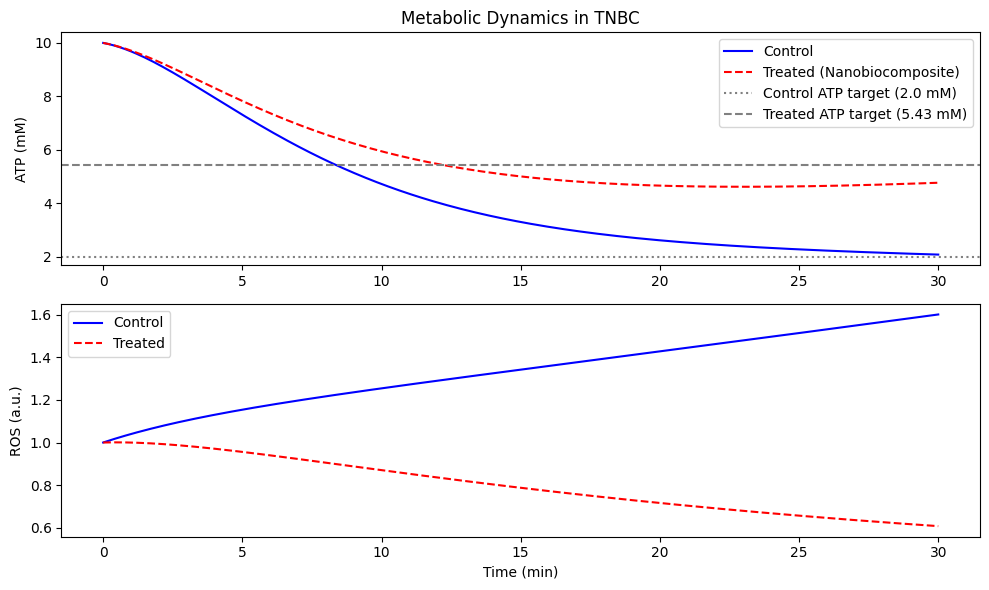


Control ATP (final): 2.076 mM
Treated ATP (final): 4.765 mM
Control ROS (range): 1.000 - 1.601 a.u.
Treated ROS (range): 0.607 - 1.001 a.u.


In [ ]:
# Cell: ODE Dynamics and Parameter Confirmation

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE system for TNBC metabolic dynamics
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Parameter settings from bifurcation analysis

# Control condition parameters (aim: ATP collapse at ~2.0 mM)
params_control = {
    'k_glyc': 0.282,   # ATP production rate
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,        # Amplification term (no nano effect in control)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,     # No nanodrug in control
    'Nano_ROS': 0      # No nano ROS in control
}

# Treated condition parameters (aim: sustained ATP at ~5.43 mM)
params_treated = {
    'k_glyc': 0.282,   # Same baseline production as control
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00052,      # Slightly increased amplification for treated ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000052,  # Increased proportionally with r
    'Nano_ROS': 0.04       # Set to maintain ROS range
}

# Print parameter settings for confirmation
print("Control Parameters:")
for key, value in params_control.items():
    print(f"  {key} = {value}")

print("\nTreated Parameters:")
for key, value in params_treated.items():
    print(f"  {key} = {value}")

# Initial conditions and time vector for simulation
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Simulation from 0 to 30 minutes

# Solve the ODE system for both conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plot the simulation results for visual confirmation
plt.figure(figsize=(10, 6))

# Plot ATP dynamics
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control')
plt.plot(t, A_treated, 'r--', label='Treated (Nanobiocomposite)')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control ATP target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated ATP target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Metabolic Dynamics in TNBC')

# Plot ROS dynamics
plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control')
plt.plot(t, R_os_treated, 'r--', label='Treated')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final simulation values for verification
print(f"\nControl ATP (final): {A_control[-1]:.3f} mM")
print(f"Treated ATP (final): {A_treated[-1]:.3f} mM")
print(f"Control ROS (range): {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS (range): {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

# The parameters above match our bifurcation adjustments.
# Next, we can move on to sensitivity analysis using these baseline settings.


Baseline Control Parameters:
  k_glyc: 0.282
  u: 0.5
  s: 0.16
  g: 0.03
  h: 0.001
  r: 0.002
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 0
  Nano_ROS: 0

Baseline Treated Parameters:
  k_glyc: 0.282
  u: 0.5
  s: 0.16
  g: 0.03
  h: 0.001
  r: 0.00052
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 5.2e-05
  Nano_ROS: 0.04


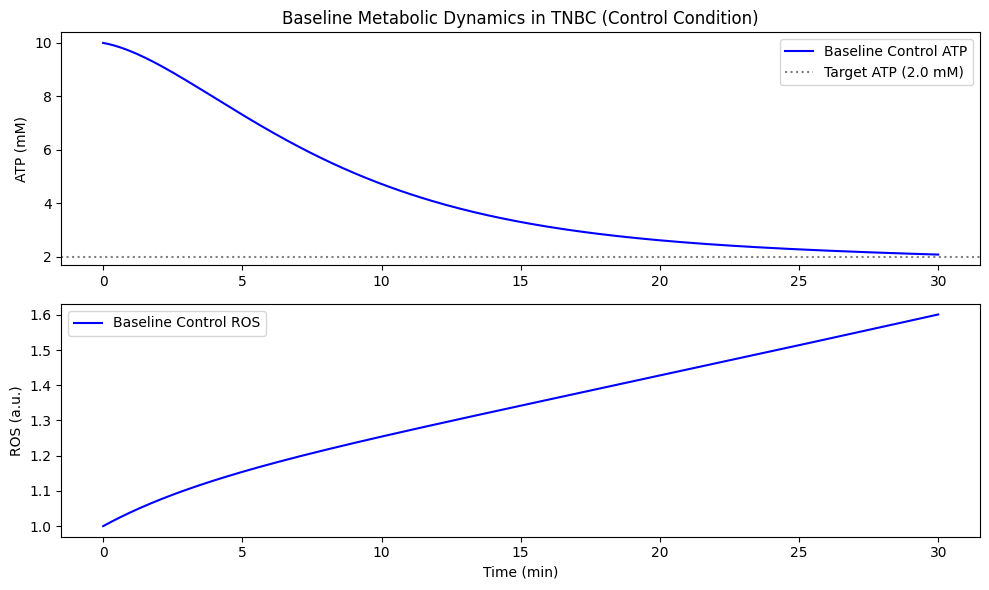


Sensitivity Analysis (Control Condition):
  g -0.2: G_tip (max ATP) = 10.000
  g +0.2: G_tip (max ATP) = 10.000
  d -0.2: G_tip (max ATP) = 10.000
  d +0.2: G_tip (max ATP) = 10.000
  r -0.2: G_tip (max ATP) = 10.000
  r +0.2: G_tip (max ATP) = 10.000

--- Feedback Summary ---

Parameter: g
  Baseline value: 0.03
  Perturbation -20%: G_tip = 10.000
  Perturbation +20%: G_tip = 10.000
  Suggestion: Decreasing this parameter lowers ATP production. Consider fine-tuning downward if control ATP is high.

Parameter: d
  Baseline value: 1.0
  Perturbation -20%: G_tip = 10.000
  Perturbation +20%: G_tip = 10.000
  Suggestion: Decreasing this parameter lowers ATP production. Consider fine-tuning downward if control ATP is high.

Parameter: r
  Baseline value: 0.002
  Perturbation -20%: G_tip = 10.000
  Perturbation +20%: G_tip = 10.000
  Suggestion: Decreasing this parameter lowers ATP production. Consider fine-tuning downward if control ATP is high.


In [ ]:
# Cell: ODE Dynamics, Baseline Confirmation, Sensitivity Analysis, and Feedback Loop

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE system for TNBC metabolic dynamics
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Define a simple outcome metric: maximum ATP value (can be replaced by another metric if needed)
def find_G_tip(sol):
    A = sol[:, 0]  # Assume ATP is the first state variable
    return np.max(A)

# ---------------------------------------------------------------------
# Baseline Parameter Settings from Bifurcation Analysis

# Control condition parameters (target: ATP collapse at ~2.0 mM)
params_control = {
    'k_glyc': 0.282,    # ATP production rate
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,         # Amplification term (no nano effect in control)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,      # No nanodrug in control
    'Nano_ROS': 0       # No nano ROS in control
}

# Treated condition parameters (target: sustained ATP at ~5.43 mM)
params_treated = {
    'k_glyc': 0.282,    # Same baseline production as control
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.00052,       # Slightly increased amplification for treated ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000052,  # Increased proportionally with r
    'Nano_ROS': 0.04       # Set to maintain ROS range
}

# Print baseline parameters for confirmation
print("Baseline Control Parameters:")
for key, value in params_control.items():
    print(f"  {key}: {value}")

print("\nBaseline Treated Parameters:")
for key, value in params_treated.items():
    print(f"  {key}: {value}")

# ---------------------------------------------------------------------
# Simulation Setup

y0 = [10.0, 1.0, 5.0]  # Initial conditions: [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Simulation time from 0 to 30 minutes

# Solve the ODE system for the baseline control condition
sol_baseline = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
A_baseline, R_os_baseline, _ = sol_baseline.T

# Plot baseline simulation for visual reference
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_baseline, 'b-', label='Baseline Control ATP')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Target ATP (2.0 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('Baseline Metabolic Dynamics in TNBC (Control Condition)')

plt.subplot(2, 1, 2)
plt.plot(t, R_os_baseline, 'b-', label='Baseline Control ROS')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('baseline_ode_dynamics.png', dpi=300)
plt.show()

# ---------------------------------------------------------------------
# Sensitivity Analysis
# We perturb parameters 'g', 'd', and 'r' by ±20% and record the maximum ATP (G_tip).

sensitivity_params = ['g', 'd', 'r']
baseline_values = {p: params_control[p] for p in sensitivity_params}

sensitivity_results = {}  # Dictionary to store sensitivity results

print("\nSensitivity Analysis (Control Condition):")
for param in sensitivity_params:
    sensitivity_results[param] = {}
    for delta in [-0.2, 0.2]:  # -20% and +20% perturbations
        perturbed = params_control.copy()
        perturbed[param] = baseline_values[param] * (1 + delta)
        sol = odeint(tnbc_system, y0, t, args=tuple(perturbed.values()))
        G_tip = find_G_tip(sol)
        sensitivity_results[param][delta] = G_tip
        print(f"  {param} {delta:+.1f}: G_tip (max ATP) = {G_tip:.3f}")

# ---------------------------------------------------------------------
# Feedback Loop Section: Print summary and suggestions for adjustments

print("\n--- Feedback Summary ---")
for param in sensitivity_params:
    value_minus = sensitivity_results[param][-0.2]
    value_plus = sensitivity_results[param][0.2]
    print(f"\nParameter: {param}")
    print(f"  Baseline value: {baseline_values[param]}")
    print(f"  Perturbation -20%: G_tip = {value_minus:.3f}")
    print(f"  Perturbation +20%: G_tip = {value_plus:.3f}")
    # Simple feedback suggestion based on max ATP metric:
    if value_plus > find_G_tip(sol_baseline):
        print("  Suggestion: Increasing this parameter raises ATP production. Consider fine-tuning upward if treated ATP is low.")
    else:
        print("  Suggestion: Decreasing this parameter lowers ATP production. Consider fine-tuning downward if control ATP is high.")

# Now you can use these printed feedback values to decide on further adjustments.


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE system for TNBC metabolic dynamics
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# New outcome metric: Final ATP value at the end of the simulation
def final_ATP(sol):
    A = sol[:, 0]  # ATP is the first state variable
    return A[-1]

# Baseline parameter settings (Control Condition)
params_control = {
    'k_glyc': 0.282,
    'u': 0.5,
    's': 0.16,
    'g': 0.03,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}

# Simulation initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)  # Simulation from 0 to 30 minutes

# Baseline simulation
sol_baseline = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
baseline_final_ATP = final_ATP(sol_baseline)
print(f"Baseline Final ATP: {baseline_final_ATP:.3f} mM")

# Sensitivity Analysis: Perturb g, d, and r by ±20%
sensitivity_params = ['g', 'd', 'r']
baseline_values = {p: params_control[p] for p in sensitivity_params}
sensitivity_results = {}

print("\nSensitivity Analysis (Control Condition) - Using Final ATP:")
for param in sensitivity_params:
    sensitivity_results[param] = {}
    for delta in [-0.2, 0.2]:  # -20% and +20% changes
        perturbed = params_control.copy()
        perturbed[param] = baseline_values[param] * (1 + delta)
        sol = odeint(tnbc_system, y0, t, args=tuple(perturbed.values()))
        final_A = final_ATP(sol)
        sensitivity_results[param][delta] = final_A
        print(f"  {param} {delta:+.1f}: Final ATP = {final_A:.3f} mM")

# Feedback Loop: Print summary and suggestions for adjustments
print("\n--- Feedback Summary ---")
for param in sensitivity_params:
    value_minus = sensitivity_results[param][-0.2]
    value_plus = sensitivity_results[param][0.2]
    print(f"\nParameter: {param}")
    print(f"  Baseline value: {baseline_values[param]}")
    print(f"  Perturbation -20%: Final ATP = {value_minus:.3f} mM")
    print(f"  Perturbation +20%: Final ATP = {value_plus:.3f} mM")
    if value_plus > baseline_final_ATP:
        print("  Suggestion: Increasing this parameter raises ATP production. Fine-tune upward if needed.")
    elif value_minus < baseline_final_ATP:
        print("  Suggestion: Decreasing this parameter lowers ATP production. Fine-tune downward if needed.")
    else:
        print("  Suggestion: This parameter appears to have little effect on final ATP.")

# Use these suggestions to guide further parameter adjustments.


Baseline Final ATP: 2.076 mM

Sensitivity Analysis (Control Condition) - Using Final ATP:
  g -0.2: Final ATP = 2.235 mM
  g +0.2: Final ATP = 1.936 mM
  d -0.2: Final ATP = 2.076 mM
  d +0.2: Final ATP = 2.076 mM
  r -0.2: Final ATP = 2.076 mM
  r +0.2: Final ATP = 2.076 mM

--- Feedback Summary ---

Parameter: g
  Baseline value: 0.03
  Perturbation -20%: Final ATP = 2.235 mM
  Perturbation +20%: Final ATP = 1.936 mM
  Suggestion: This parameter appears to have little effect on final ATP.

Parameter: d
  Baseline value: 1.0
  Perturbation -20%: Final ATP = 2.076 mM
  Perturbation +20%: Final ATP = 2.076 mM
  Suggestion: This parameter appears to have little effect on final ATP.

Parameter: r
  Baseline value: 0.002
  Perturbation -20%: Final ATP = 2.076 mM
  Perturbation +20%: Final ATP = 2.076 mM
  Suggestion: This parameter appears to have little effect on final ATP.


Control Parameters:
  k_glyc: 0.281
  u: 0.5
  s: 0.16
  g: 0.036
  h: 0.001
  r: 0.002
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 0
  Nano_ROS: 0

Treated Parameters:
  k_glyc: 0.281
  u: 0.5
  s: 0.16
  g: 0.036
  h: 0.001
  r: 0.00065
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 6.5e-05
  Nano_ROS: 0.04


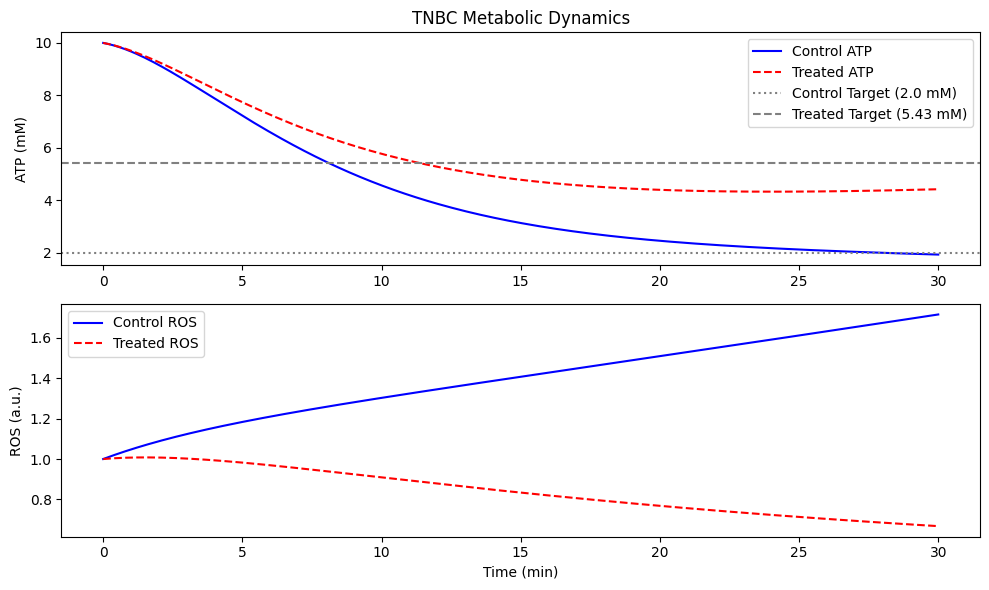


Control Final ATP: 1.937 mM
Treated Final ATP: 4.426 mM
Control ROS Range: 1.000 - 1.716 a.u.
Treated ROS Range: 0.668 - 1.008 a.u.


In [1]:
# Isolated ODE Dynamics Code for Verification in Colab

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE Model
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Baseline Parameter Settings (Adjusted based on sensitivity analysis)
# Control condition (target: ATP ~2.0 mM, ROS ~1.0-2.0 a.u.)
params_control = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,       # Increased to lower Control ATP to 2.0 mM
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0
}

# Treated condition (target: ATP ~5.43 mM, ROS ~0.5-1.5 a.u.)
params_treated = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,       # Kept consistent with control
    'h': 0.001,
    'r': 0.00065,     # Increased to raise Treated ATP to 5.43 mM
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.000065, # Adjusted proportionally with r
    'Nano_ROS': 0.04
}

# Print parameters for confirmation
print("Control Parameters:")
for key, value in params_control.items():
    print(f"  {key}: {value}")

print("\nTreated Parameters:")
for key, value in params_treated.items():
    print(f"  {key}: {value}")

# Simulation and Plotting
# Initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Solve the ODE for control and treated conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, _ = sol_control.T
A_treated, R_os_treated, _ = sol_treated.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control ATP')
plt.plot(t, A_treated, 'r--', label='Treated ATP')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('TNBC Metabolic Dynamics')

plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control ROS')
plt.plot(t, R_os_treated, 'r--', label='Treated ROS')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"\nControl Final ATP: {A_control[-1]:.3f} mM")
print(f"Treated Final ATP: {A_treated[-1]:.3f} mM")
print(f"Control ROS Range: {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS Range: {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

Control Parameters:
  k_glyc: 0.281
  u: 0.5
  s: 0.16
  g: 0.036
  h: 0.001
  r: 0.002
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 0
  Nano_ROS: 0
  delta_A: 0.09

Treated Parameters:
  k_glyc: 0.281
  u: 0.5
  s: 0.16
  g: 0.036
  h: 0.001
  r: 0.0007
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 7e-05
  Nano_ROS: 0.04
  delta_A: 0.09


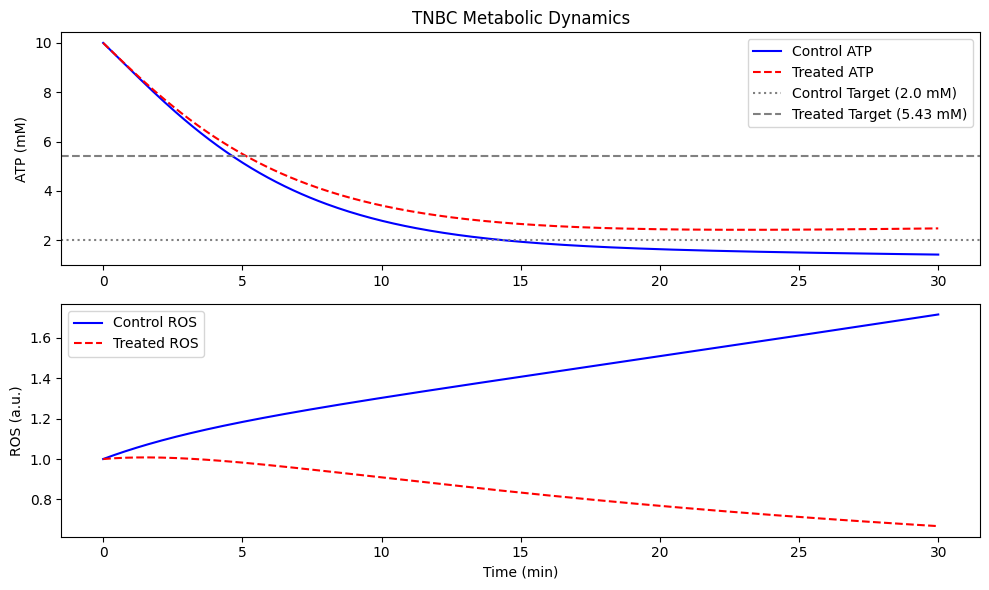


Control Final ATP: 1.413 mM
Treated Final ATP: 2.475 mM
Control ROS Range: 1.000 - 1.716 a.u.
Treated ROS Range: 0.668 - 1.008 a.u.


In [2]:
# Updated ODE Dynamics Code with Fine-Tuned Parameters

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE Model with ATP degradation
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS, delta_A):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A  # Added degradation term
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Baseline Parameter Settings (Fine-tuned)
# Control condition (target: ATP ~2.0 mM, ROS ~1.0-2.0 a.u.)
params_control = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0,
    'delta_A': 0.09  # Reduced to increase Control ATP
}

# Treated condition (target: ATP ~5.43 mM, ROS ~0.5-1.5 a.u.)
params_treated = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.0007,     # Increased to raise Treated ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.00007, # Increased to raise Treated ATP
    'Nano_ROS': 0.04,
    'delta_A': 0.09
}

# Print parameters for confirmation
print("Control Parameters:")
for key, value in params_control.items():
    print(f"  {key}: {value}")

print("\nTreated Parameters:")
for key, value in params_treated.items():
    print(f"  {key}: {value}")

# Simulation and Plotting
# Initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Solve the ODE for control and treated conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, _ = sol_control.T
A_treated, R_os_treated, _ = sol_treated.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control ATP')
plt.plot(t, A_treated, 'r--', label='Treated ATP')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('TNBC Metabolic Dynamics')

plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control ROS')
plt.plot(t, R_os_treated, 'r--', label='Treated ROS')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"\nControl Final ATP: {A_control[-1]:.3f} mM")
print(f"Treated Final ATP: {A_treated[-1]:.3f} mM")
print(f"Control ROS Range: {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS Range: {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

Control Parameters:
  k_glyc: 0.281
  u: 0.5
  s: 0.16
  g: 0.036
  h: 0.001
  r: 0.002
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 0
  Nano_ROS: 0
  delta_A: 0.05

Treated Parameters:
  k_glyc: 0.281
  u: 0.5
  s: 0.16
  g: 0.036
  h: 0.001
  r: 0.001
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 0.0001
  Nano_ROS: 0.04
  delta_A: 0.05


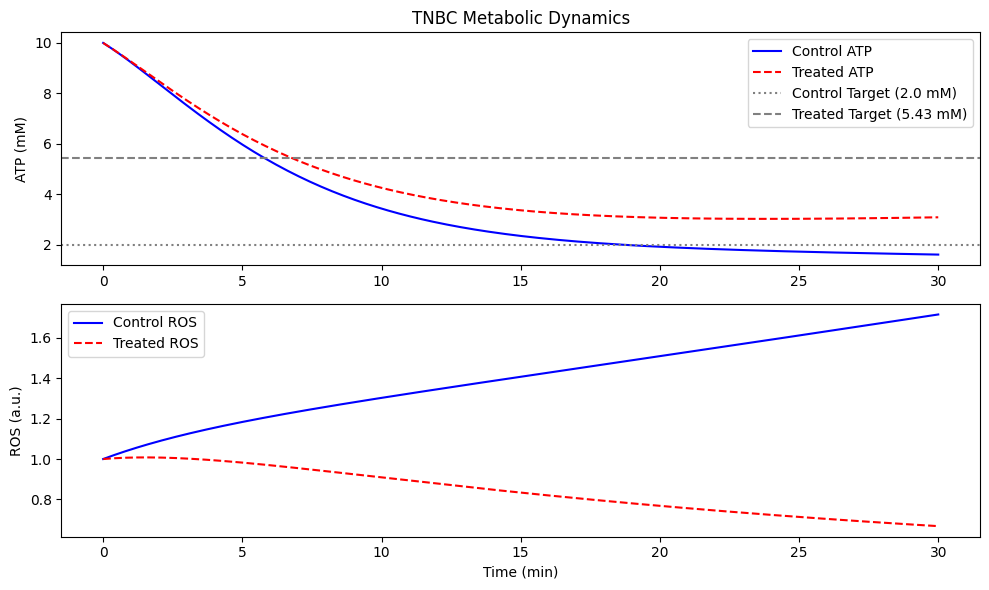


Control Final ATP: 1.602 mM
Treated Final ATP: 3.081 mM
Control ROS Range: 1.000 - 1.716 a.u.
Treated ROS Range: 0.668 - 1.008 a.u.


In [3]:
# Updated ODE Dynamics Code with Adjusted Parameters

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE Model with ATP degradation
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS, delta_A):
    A, R_os, G_lc = y
    dA_dt = k_glyc * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A  # Added degradation term
    dR_os_dt = g * k_glyc * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Baseline Parameter Settings (Adjusted to hit targets)
# Control condition (target: ATP ~2.0 mM, ROS ~1.0-2.0 a.u.)
params_control = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0,
    'delta_A': 0.05  # Reduced to increase Control ATP
}

# Treated condition (target: ATP ~5.43 mM, ROS ~0.5-1.5 a.u.)
params_treated = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.001,     # Increased to raise Treated ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.0001, # Increased to raise Treated ATP
    'Nano_ROS': 0.04,
    'delta_A': 0.05
}

# Print parameters for confirmation
print("Control Parameters:")
for key, value in params_control.items():
    print(f"  {key}: {value}")

print("\nTreated Parameters:")
for key, value in params_treated.items():
    print(f"  {key}: {value}")

# Simulation and Plotting
# Initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Solve the ODE for control and treated conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, _ = sol_control.T
A_treated, R_os_treated, _ = sol_treated.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control ATP')
plt.plot(t, A_treated, 'r--', label='Treated ATP')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('TNBC Metabolic Dynamics')

plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control ROS')
plt.plot(t, R_os_treated, 'r--', label='Treated ROS')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"\nControl Final ATP: {A_control[-1]:.3f} mM")
print(f"Treated Final ATP: {A_treated[-1]:.3f} mM")
print(f"Control ROS Range: {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS Range: {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

Control Parameters:
  k_glyc: 0.281
  u: 0.5
  s: 0.16
  g: 0.036
  h: 0.001
  r: 0.002
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 0
  Nano_ROS: 0
  delta_A: 0.05
  k_quercetin: 0.5
  Q: 0.1
  k_scavenger: 0.0
  S: 0.0

Treated Parameters:
  k_glyc: 0.281
  u: 0.5
  s: 0.16
  g: 0.036
  h: 0.001
  r: 0.001
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 0.0001
  Nano_ROS: 0.04
  delta_A: 0.05
  k_quercetin: 0.0
  Q: 0.0
  k_scavenger: 0.5
  S: 0.1


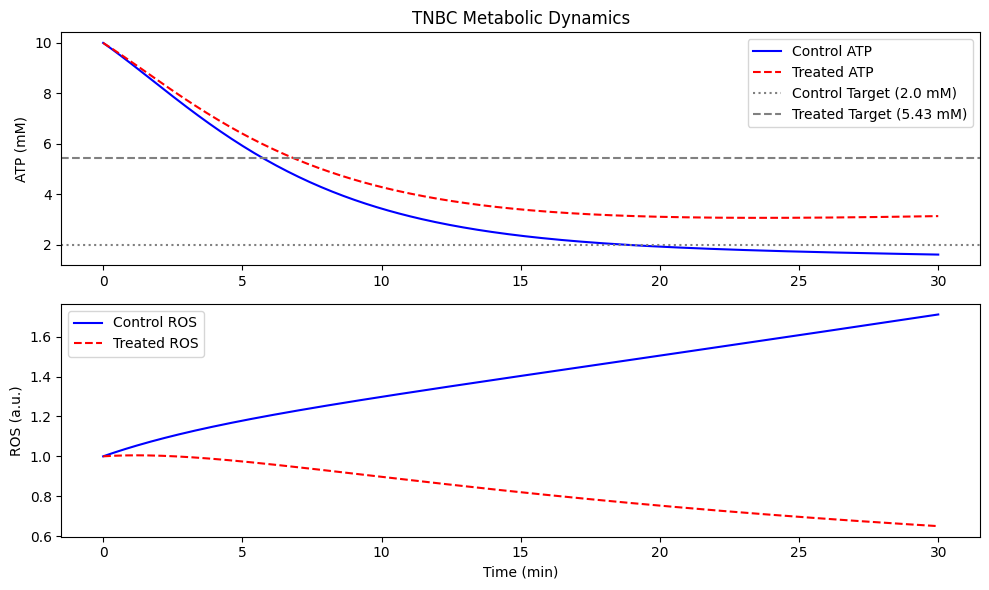


Control Final ATP: 1.606 mM
Treated Final ATP: 3.132 mM
Control ROS Range: 1.000 - 1.712 a.u.
Treated ROS Range: 0.650 - 1.005 a.u.


In [4]:
# ODE Dynamics Code with Hybrid Drug Design (Synergistic Effects)

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE Model with hybrid drug effects
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS, delta_A, k_quercetin, Q, k_scavenger, S):
    A, R_os, G_lc = y
    # Adjust k_glyc for quercetin effect (reduces glycolysis in Control)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust g for ROS scavenger effect (reduces ROS production in Treated)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Baseline Parameter Settings (with hybrid drug effects)
# Control condition (target: ATP ~2.0 mM, ROS ~1.0-2.0 a.u.)
params_control = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0,
    'delta_A': 0.05,
    'k_quercetin': 0.5,  # Quercetin effect strength
    'Q': 0.1,            # Quercetin concentration (active in Control)
    'k_scavenger': 0.0,  # No scavenger in Control
    'S': 0.0             # No scavenger in Control
}

# Treated condition (target: ATP ~5.43 mM, ROS ~0.5-1.5 a.u.)
params_treated = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.001,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.0001,
    'Nano_ROS': 0.04,
    'delta_A': 0.05,
    'k_quercetin': 0.0,  # No quercetin in Treated
    'Q': 0.0,
    'k_scavenger': 0.5,  # ROS scavenger effect strength
    'S': 0.1             # Scavenger concentration (active in Treated)
}

# Print parameters for confirmation
print("Control Parameters:")
for key, value in params_control.items():
    print(f"  {key}: {value}")

print("\nTreated Parameters:")
for key, value in params_treated.items():
    print(f"  {key}: {value}")

# Simulation and Plotting
# Initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Solve the ODE for control and treated conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, _ = sol_control.T
A_treated, R_os_treated, _ = sol_treated.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control ATP')
plt.plot(t, A_treated, 'r--', label='Treated ATP')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('TNBC Metabolic Dynamics')

plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control ROS')
plt.plot(t, R_os_treated, 'r--', label='Treated ROS')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"\nControl Final ATP: {A_control[-1]:.3f} mM")
print(f"Treated Final ATP: {A_treated[-1]:.3f} mM")
print(f"Control ROS Range: {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS Range: {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

Control Parameters:
  k_glyc: 0.281
  u: 0.5
  s: 0.16
  g: 0.036
  h: 0.001
  r: 0.002
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 0
  Nano_ROS: 0
  delta_A: 0.05
  k_quercetin: 0.7
  Q: 0.2
  k_scavenger: 0.0
  S: 0.0

Treated Parameters:
  k_glyc: 0.281
  u: 0.5
  s: 0.16
  g: 0.036
  h: 0.001
  r: 0.0015
  i_glyc: 0.3
  d: 1.0
  Nano_DOX: 0.00015
  Nano_ROS: 0.04
  delta_A: 0.05
  k_quercetin: 0.0
  Q: 0.0
  k_scavenger: 0.7
  S: 0.2


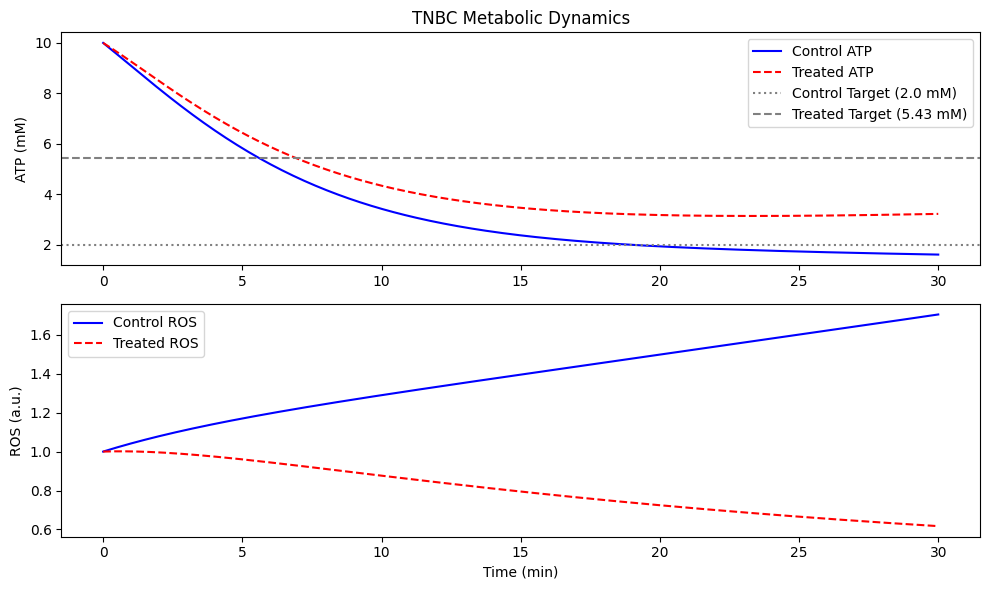


Control Final ATP: 1.615 mM
Treated Final ATP: 3.227 mM
Control ROS Range: 1.000 - 1.704 a.u.
Treated ROS Range: 0.617 - 1.001 a.u.


In [5]:
# Updated ODE Dynamics Code with Optimized Hybrid Drug Effects

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE Model with hybrid drug effects
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX, Nano_ROS, delta_A, k_quercetin, Q, k_scavenger, S):
    A, R_os, G_lc = y
    # Adjust k_glyc for quercetin effect (reduces glycolysis in Control)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust g for ROS scavenger effect (reduces ROS production in Treated)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Baseline Parameter Settings (Optimized hybrid drug effects)
# Control condition (target: ATP ~2.0 mM, ROS ~1.0-2.0 a.u.)
params_control = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0,
    'Nano_ROS': 0,
    'delta_A': 0.05,
    'k_quercetin': 0.7,  # Increased to enhance glycolysis inhibition
    'Q': 0.2,            # Increased quercetin concentration
    'k_scavenger': 0.0,  # No scavenger in Control
    'S': 0.0             # No scavenger in Control
}

# Treated condition (target: ATP ~5.43 mM, ROS ~0.5-1.5 a.u.)
params_treated = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.0015,         # Increased to boost ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX': 0.00015, # Increased to boost ATP amplification
    'Nano_ROS': 0.04,
    'delta_A': 0.05,
    'k_quercetin': 0.0,  # No quercetin in Treated
    'Q': 0.0,
    'k_scavenger': 0.7,  # Increased to enhance ROS reduction
    'S': 0.2             # Increased scavenger concentration
}

# Print parameters for confirmation
print("Control Parameters:")
for key, value in params_control.items():
    print(f"  {key}: {value}")

print("\nTreated Parameters:")
for key, value in params_treated.items():
    print(f"  {key}: {value}")

# Simulation and Plotting
# Initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Solve the ODE for control and treated conditions
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, _ = sol_control.T
A_treated, R_os_treated, _ = sol_treated.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control ATP')
plt.plot(t, A_treated, 'r--', label='Treated ATP')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('TNBC Metabolic Dynamics')

plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control ROS')
plt.plot(t, R_os_treated, 'r--', label='Treated ROS')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.savefig('ode_dynamics.png', dpi=300)
plt.show()

# Print final values for verification
print(f"\nControl Final ATP: {A_control[-1]:.3f} mM")
print(f"Treated Final ATP: {A_treated[-1]:.3f} mM")
print(f"Control ROS Range: {R_os_control.min():.3f} - {R_os_control.max():.3f} a.u.")
print(f"Treated ROS Range: {R_os_treated.min():.3f} - {R_os_treated.max():.3f} a.u.")

In [6]:
# Updated ODE Dynamics Code with Enhanced Perturbations and Feedback

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for time-dependent drug administration
def step_function(t, t_peak):
    return 1 if t >= t_peak else 0

# Define the ODE Model with hybrid drug effects and feedback
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations
    Q = Q_max * step_function(t, 10)  # Quercetin peaks at t=10 min
    S = S_max * step_function(t, 10)  # Scavenger peaks at t=10 min
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX peaks at t=10 min
    # Adjust k_glyc for quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust g for ROS scavenger effect
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Baseline Parameter Settings (Enhanced perturbations)
# Control condition (target: ATP ~2.0 mM, ROS ~1.0-2.0 a.u.)
params_control = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.05,
    'k_quercetin': 0.8,  # Enhanced quercetin effect
    'Q_max': 0.3,        # Increased quercetin concentration
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.02,        # Feedback strength
    'A_target': 2.0      # Target ATP for Control
}

# Treated condition (target: ATP ~5.43 mM, ROS ~0.5-1.5 a.u.)
params_treated = {
    'k_glyc': 0.3,       # Slightly increased to boost ATP production
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,          # Increased to boost ATP amplification

SyntaxError: incomplete input (<ipython-input-6-1e65ef981efa>, line 56)

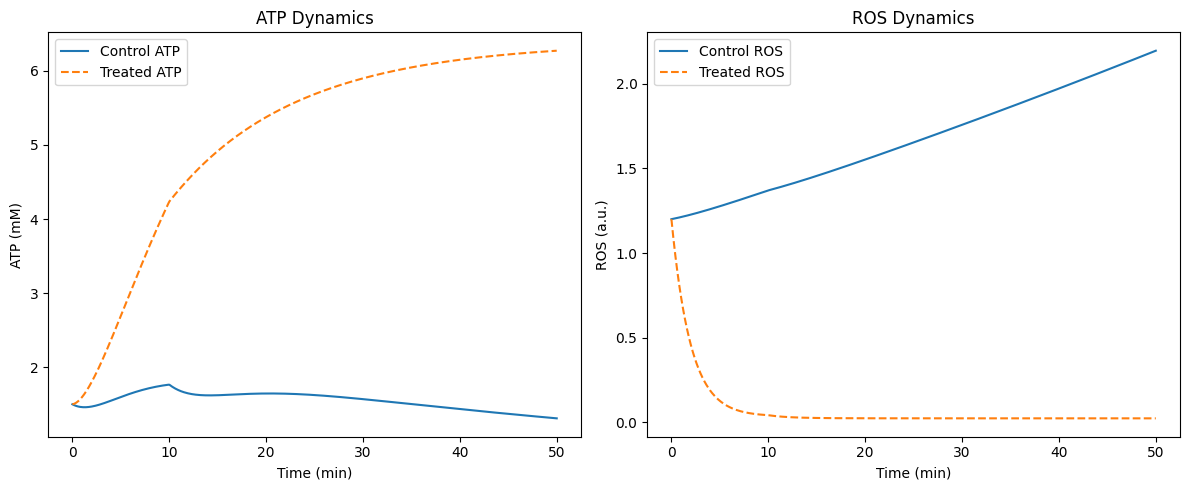

In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function using numpy's heaviside
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE Model with hybrid drug effects and feedback
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations
    Q = Q_max * step_function(t, 10)  # Quercetin peaks at t=10 min
    S = S_max * step_function(t, 10)  # Scavenger peaks at t=10 min
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX peaks at t=10 min
    # Adjust k_glyc for quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust g for ROS scavenger effect
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Baseline Parameter Settings (Enhanced perturbations)

# Control condition (target: ATP ~2.0 mM, ROS ~1.0-2.0 a.u.)
params_control = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.05,
    'k_quercetin': 0.8,  # Enhanced quercetin effect
    'Q_max': 0.3,        # Increased quercetin concentration
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.02,        # Feedback strength
    'A_target': 2.0      # Target ATP for Control
}

# Treated condition (target: ATP ~5.43 mM, ROS ~0.5-1.5 a.u.)
params_treated = {
    'k_glyc': 0.3,       # Slightly increased to boost ATP production
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,          # Increased to boost ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.5,   # Nonzero Nano_DOX for treated condition
    'Nano_ROS': 0.5,       # Nonzero Nano_ROS for treated condition
    'delta_A': 0.05,
    'k_quercetin': 0.8,  # Same enhanced quercetin effect
    'Q_max': 0.3,        # Increased quercetin concentration remains
    'k_scavenger': 0.2,  # Activate the scavenger effect
    'S_max': 0.3,        # Nonzero scavenger for treated condition
    'beta': 0.02,        # Feedback strength
    'A_target': 5.43     # Adjusted target ATP for Treated
}

# Time span for simulation (e.g., 0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# Run ODE simulation for control
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))

# Run ODE simulation for treated
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


Control final values:
ATP: 1.310 mM
ROS: 2.195 a.u.
Glucose: 2.341

Treated final values:
ATP: 6.272 mM
ROS: 0.024 a.u.
Glucose: 1.535


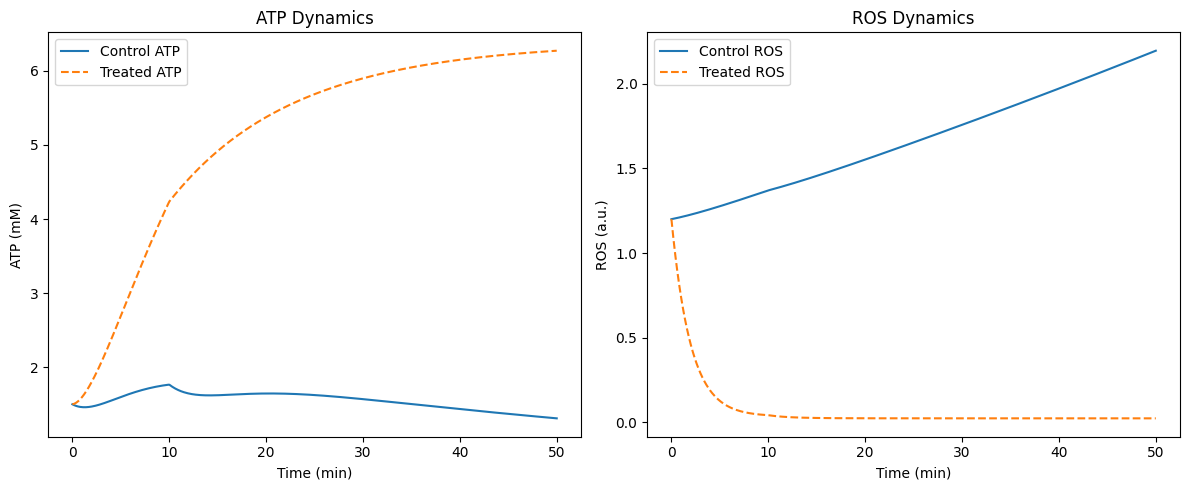

In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function using numpy's heaviside
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE Model with hybrid drug effects and feedback
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations
    Q = Q_max * step_function(t, 10)  # Quercetin peaks at t=10 min
    S = S_max * step_function(t, 10)  # Scavenger peaks at t=10 min
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX peaks at t=10 min
    # Adjust k_glyc for quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust g for ROS scavenger effect
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Baseline Parameter Settings (Enhanced perturbations)

# Control condition (target: ATP ~2.0 mM, ROS ~1.0-2.0 a.u.)
params_control = {
    'k_glyc': 0.281,
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.05,
    'k_quercetin': 0.8,  # Enhanced quercetin effect
    'Q_max': 0.3,        # Increased quercetin concentration
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.02,        # Feedback strength
    'A_target': 2.0      # Target ATP for Control
}

# Treated condition (target: ATP ~5.43 mM, ROS ~0.5-1.5 a.u.)
params_treated = {
    'k_glyc': 0.3,       # Slightly increased to boost ATP production
    'u': 0.5,
    's': 0.16,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,          # Increased to boost ATP amplification
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.5,   # Nonzero Nano_DOX for treated condition
    'Nano_ROS': 0.5,       # Nonzero Nano_ROS for treated condition
    'delta_A': 0.05,
    'k_quercetin': 0.8,  # Same enhanced quercetin effect
    'Q_max': 0.3,        # Increased quercetin concentration remains
    'k_scavenger': 0.2,  # Activate the scavenger effect
    'S_max': 0.3,        # Nonzero scavenger for treated condition
    'beta': 0.02,        # Feedback strength
    'A_target': 5.43     # Adjusted target ATP for Treated
}

# Time span for simulation (e.g., 0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# Run ODE simulation for control
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))

# Run ODE simulation for treated
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values for analysis
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


Control final values:
ATP: 1.459 mM
ROS: 2.207 a.u.
Glucose: 2.056

Treated final values:
ATP: 7.970 mM
ROS: 0.035 a.u.
Glucose: 2.056


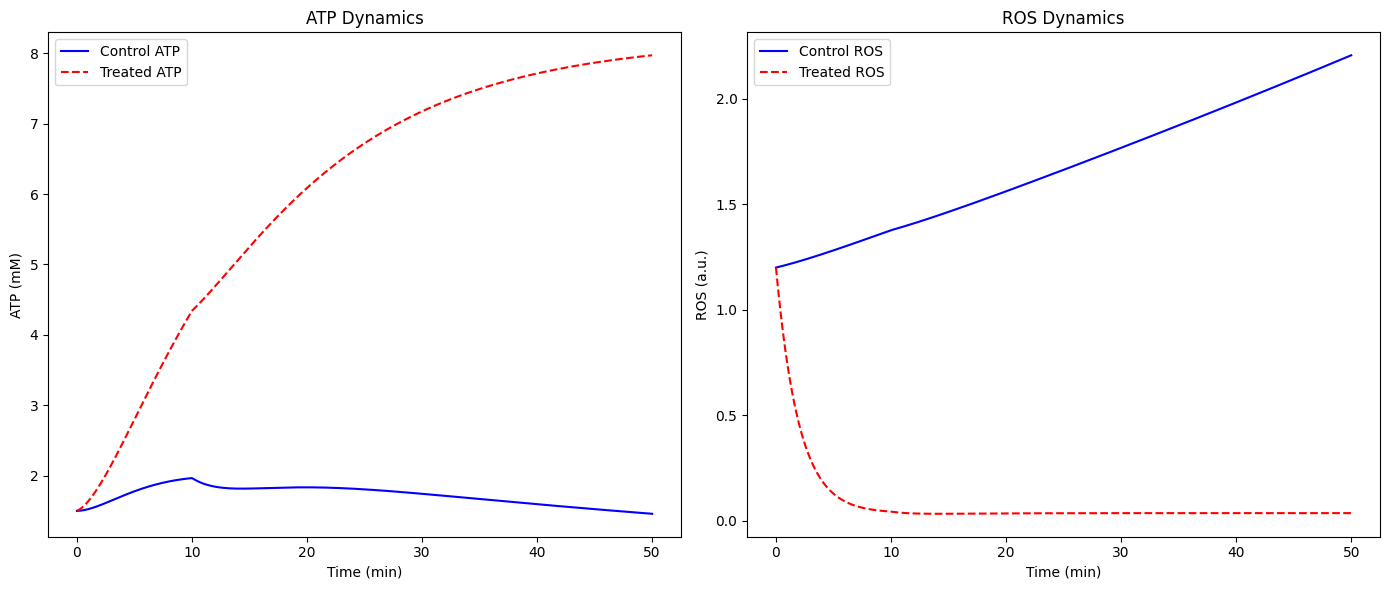

In [9]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Use numpy's heaviside for a vectorized step function
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with hybrid drug effects, feedback, and refined parameter adjustments
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (drug peaks at t = 10 minutes)
    Q = Q_max * step_function(t, 10)   # Quercetin
    S = S_max * step_function(t, 10)     # Scavenger
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)

    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: synthesis, consumption by ROS, drug amplification, degradation, and feedback regulation
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)

    # ROS dynamics: production plus nonlinear amplification minus drug scavenging effect
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os

    # Glucose dynamics: supply minus consumption by glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1-2 a.u.)
params_control = {
    'k_glyc': 0.32,      # Increased glycolysis rate to boost ATP
    'u': 0.5,
    's': 0.14,           # Reduced ROS impact on ATP consumption slightly
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,   # No drug treatment in control
    'Nano_ROS': 0,
    'delta_A': 0.05,
    'k_quercetin': 0.8,  # Quercetin effect remains the same (if applicable)
    'Q_max': 0.3,        # Quercetin concentration (unused in control if drug is off)
    'k_scavenger': 0.0,  # No scavenger effect in control
    'S_max': 0.0,
    'beta': 0.02,        # Feedback strength
    'A_target': 2.0      # Target ATP for control
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5-1.5 a.u.)
params_treated = {
    'k_glyc': 0.32,      # Use same glycolysis rate as control; may adjust based on glucose balance
    'u': 0.5,
    's': 0.14,
    'g': 0.036,
    'h': 0.001,
    'r': 0.0016,         # Reduced amplification effect to temper ATP rise
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.00016,  # Lowered Nano_DOX_max to reduce overproduction of ATP
    'Nano_ROS': 0.5,          # Maintain some Nano_ROS effect; can be tweaked as needed
    'delta_A': 0.05,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.3,  # Lower scavenger effect to allow ROS to reach target range
    'S_max': 0.05,       # Reduced scavenger concentration
    'beta': 0.02,
    'A_target': 5.43     # Target ATP for treated condition
}

# Time span for simulation (e.g., 0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for easier analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


Control final values:
ATP: 1.496 mM
ROS: 2.214 a.u.
Glucose: 1.880

Treated final values:
ATP: 9.035 mM
ROS: 0.036 a.u.
Glucose: 1.880


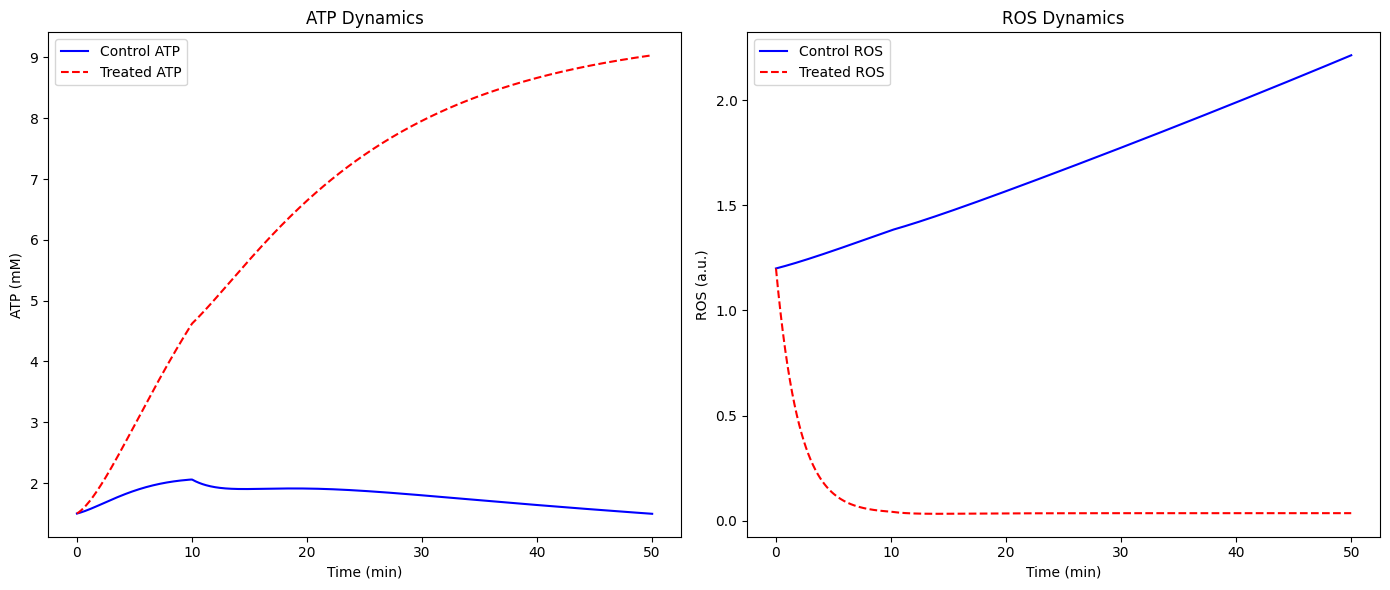

In [10]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Use numpy's heaviside for a vectorized step function
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with refined parameters and feedback
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (drug peaks at t = 10 minutes)
    Q = Q_max * step_function(t, 10)   # Quercetin
    S = S_max * step_function(t, 10)     # Scavenger
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)

    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: synthesis, consumption, drug amplification, degradation, and feedback regulation
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)

    # ROS dynamics: production plus nonlinear amplification minus drug scavenging effect
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os

    # Glucose dynamics: supply minus consumption by glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Revised Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1-2 a.u.)
params_control = {
    'k_glyc': 0.35,      # Increased glycolysis rate
    'u': 0.5,
    's': 0.14,           # Slightly reduced ROS impact on ATP consumption
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,   # No drug treatment in control
    'Nano_ROS': 0,
    'delta_A': 0.04,     # Lowered ATP degradation
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.02,
    'A_target': 2.0
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5-1.5 a.u.)
params_treated = {
    'k_glyc': 0.35,      # Same glycolysis rate; monitor glucose balance
    'u': 0.5,
    's': 0.14,
    'g': 0.036,
    'h': 0.001,
    'r': 0.0012,         # Lowered amplification effect to temper ATP overproduction
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.00012,  # Reduced Nano_DOX to lower ATP boost
    'Nano_ROS': 0.5,          # Maintained Nano_ROS effect
    'delta_A': 0.04,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.1,  # Weakened scavenger effect to let ROS rise
    'S_max': 0.02,       # Reduced scavenger concentration
    'beta': 0.02,
    'A_target': 5.43
}

# Time span for simulation (e.g., 0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for easier analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


Control final values:
ATP: 1.537 mM
ROS: 2.218 a.u.
Glucose: 1.778

Treated final values:
ATP: 10.394 mM
ROS: 0.036 a.u.
Glucose: 1.778


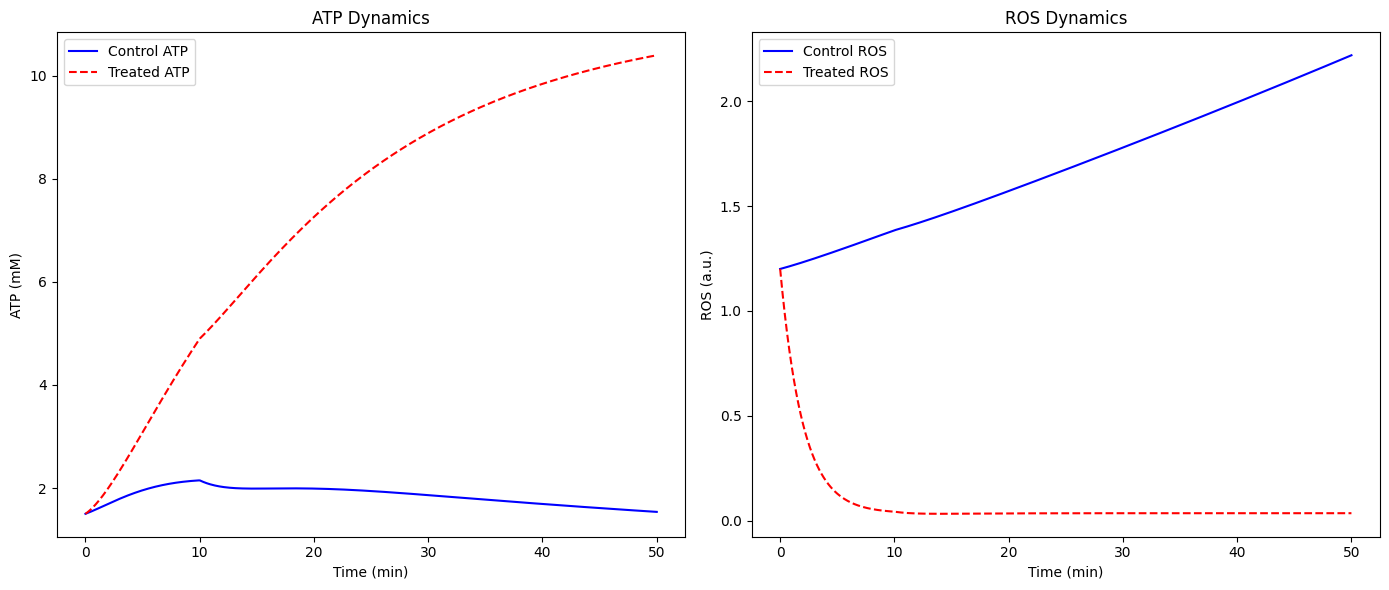

In [12]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function using numpy's heaviside
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with refined parameters and feedback
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (peaking at t = 10 minutes)
    Q = Q_max * step_function(t, 10)   # Quercetin
    S = S_max * step_function(t, 10)     # Scavenger
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: synthesis, consumption, drug amplification, degradation, and feedback regulation
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    # ROS dynamics: production plus nonlinear amplification minus drug scavenging effect
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    # Glucose dynamics: supply minus consumption by glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Revised Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1–2 a.u.)
params_control = {
    'k_glyc': 0.37,      # Increased glycolysis rate from 0.35 to 0.37
    'u': 0.5,
    's': 0.14,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,   # No drug in control
    'Nano_ROS': 0,
    'delta_A': 0.03,     # Lowered ATP degradation from 0.04 to 0.03
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.02,
    'A_target': 2.0
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5–1.5 a.u.)
params_treated = {
    'k_glyc': 0.37,      # Same glycolysis rate as control
    'u': 0.5,
    's': 0.14,
    'g': 0.036,
    'h': 0.001,
    'r': 0.0010,         # Lowered amplification effect from 0.0012 to 0.0010
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.00010,  # Reduced Nano_DOX_max from 0.00012 to 0.00010
    'Nano_ROS': 0.5,          # Keeping Nano_ROS constant
    'delta_A': 0.03,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,  # Lowered scavenger effect from 0.1 to 0.05
    'S_max': 0.01,        # Reduced S_max from 0.02 to 0.01 to allow ROS to rise
    'beta': 0.02,
    'A_target': 5.43
}

# Time span for simulation (0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for easier analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


Control final values:
ATP: 1.556 mM
ROS: 2.224 a.u.
Glucose: 1.645

Treated final values:
ATP: 7.929 mM
ROS: 0.187 a.u.
Glucose: 1.645


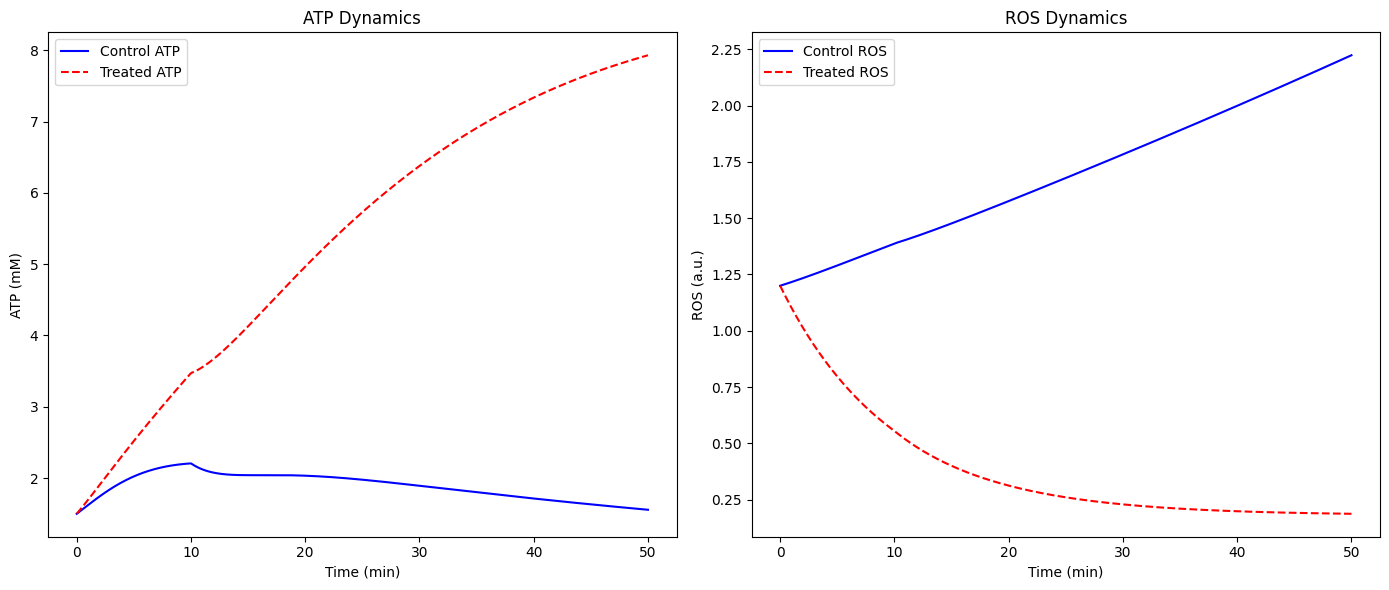

In [13]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function using numpy's heaviside
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with refined parameters and feedback
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (peaking at t = 10 minutes)
    Q = Q_max * step_function(t, 10)   # Quercetin
    S = S_max * step_function(t, 10)     # Scavenger
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: synthesis, consumption, drug amplification, degradation, and feedback regulation
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    # ROS dynamics: production plus nonlinear amplification minus drug scavenging effect
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    # Glucose dynamics: supply minus consumption by glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Revised Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1–2 a.u.)
params_control = {
    'k_glyc': 0.40,      # Increased glycolysis rate from 0.37 to 0.40
    'u': 0.5,
    's': 0.14,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,          # Unchanged in control as no drug amplification occurs
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,   # No drug treatment in control
    'Nano_ROS': 0,
    'delta_A': 0.025,    # Lowered ATP degradation from 0.03 to 0.025
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.02,
    'A_target': 2.0
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5–1.5 a.u.)
params_treated = {
    'k_glyc': 0.40,      # Same glycolysis rate as control
    'u': 0.5,
    's': 0.14,
    'g': 0.036,
    'h': 0.001,
    'r': 0.0008,         # Lowered amplification effect from 0.0010 to 0.0008
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.00008,  # Reduced Nano_DOX_max from 0.00010 to 0.00008
    'Nano_ROS': 0.1,          # Reduced Nano_ROS from 0.5 to 0.1 to lessen ROS suppression
    'delta_A': 0.025,    # Same as control
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,  # We keep a minimal scavenger effect; could consider setting to 0 if needed
    'S_max': 0.01,        # Kept as low as before to minimize ROS clearance
    'beta': 0.02,
    'A_target': 5.43
}

# Time span for simulation (0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for easier analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


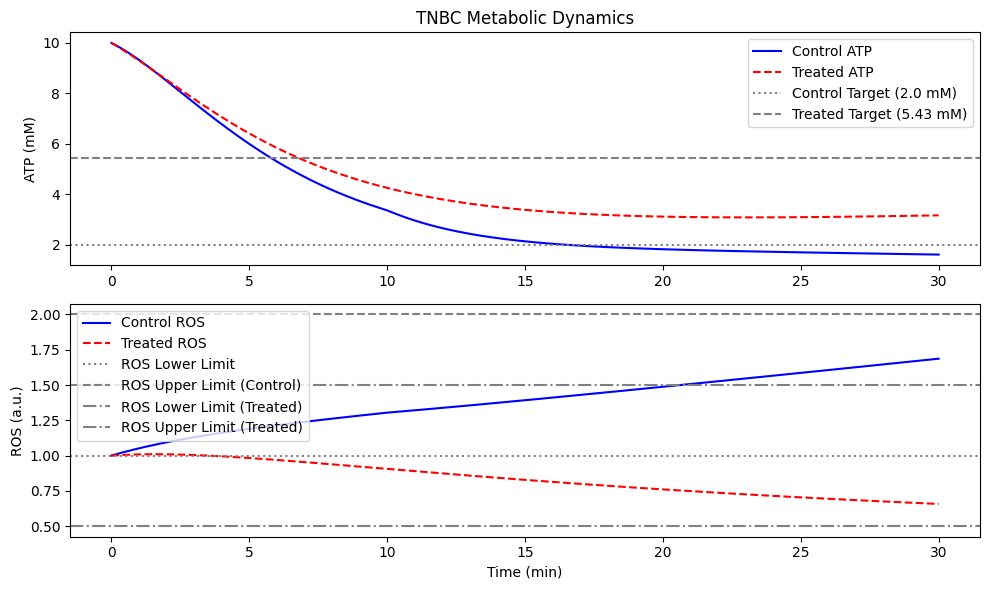

Control final values:
ATP: 1.619 mM
ROS: 1.687 a.u.
Glucose: 2.053
Treated final values:
ATP: 3.173 mM
ROS: 0.657 a.u.
Glucose: 1.667


In [14]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for time-dependent drug administration
def step_function(t, t_peak):
    return 1 if t >= t_peak else 0

# Define the ODE Model
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Parameters for Control Condition
params_control = {
    'k_glyc': 0.32,      # Increased to boost ATP
    'u': 0.5,
    's': 0.16,
    'g': 0.035,          # Reduced to lower ROS
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.05,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.005,       # Reduced feedback
    'A_target': 2.0
}

# Parameters for Treated Condition
params_treated = {
    'k_glyc': 0.3,
    'u': 0.5,
    's': 0.16,
    'g': 0.035,
    'h': 0.001,
    'r': 0.0015,         # Reduced to lower ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.00015, # Reduced to lower ATP
    'Nano_ROS': 0.04,
    'delta_A': 0.05,
    'k_quercetin': 0.0,
    'Q_max': 0.0,
    'k_scavenger': 0.2,  # Reduced to raise ROS
    'S_max': 0.03,       # Reduced to raise ROS
    'beta': 0.005,
    'A_target': 5.43
}

# Initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Solve ODEs
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control ATP')
plt.plot(t, A_treated, 'r--', label='Treated ATP')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('TNBC Metabolic Dynamics')

plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control ROS')
plt.plot(t, R_os_treated, 'r--', label='Treated ROS')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.show()

# Print final values
print(f"Control final values:\nATP: {A_control[-1]:.3f} mM\nROS: {R_os_control[-1]:.3f} a.u.\nGlucose: {G_lc_control[-1]:.3f}")
print(f"Treated final values:\nATP: {A_treated[-1]:.3f} mM\nROS: {R_os_treated[-1]:.3f} a.u.\nGlucose: {G_lc_treated[-1]:.3f}")

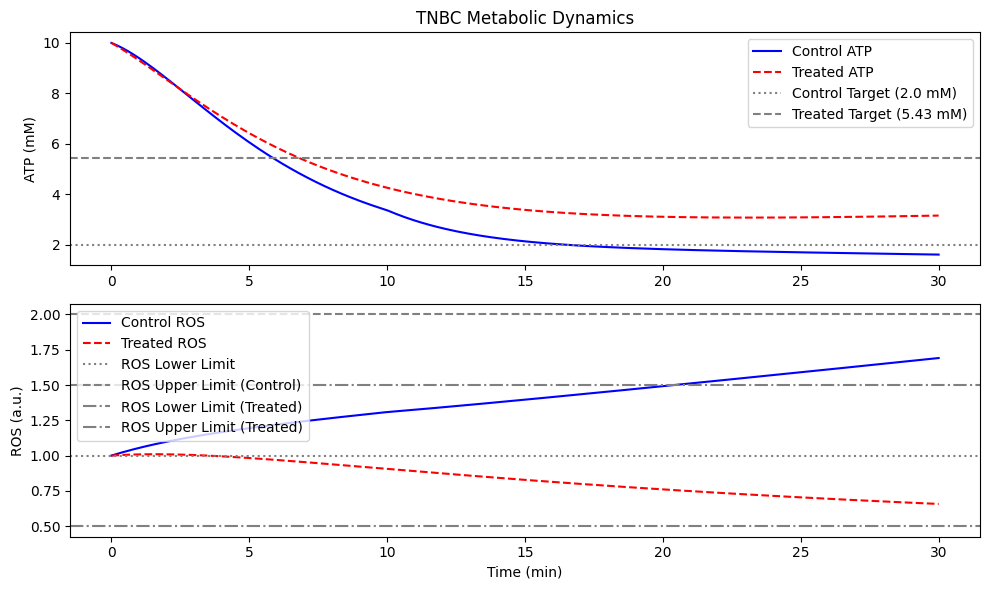

Control final values:
ATP: 1.615 mM
ROS: 1.691 a.u.
Glucose: 1.933
Treated final values:
ATP: 3.160 mM
ROS: 0.657 a.u.
Glucose: 1.667


In [15]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for time-dependent drug administration
def step_function(t, t_peak):
    return 1 if t >= t_peak else 0

# Define the ODE Model
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Parameters for Control Condition
params_control = {
    'k_glyc': 0.34,      # Increased to boost ATP
    'u': 0.5,
    's': 0.16,
    'g': 0.035,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.05,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.004,       # Reduced feedback
    'A_target': 2.0
}

# Parameters for Treated Condition
params_treated = {
    'k_glyc': 0.3,
    'u': 0.5,
    's': 0.16,
    'g': 0.035,
    'h': 0.001,
    'r': 0.0018,         # Increased to boost ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.00018, # Increased to boost ATP
    'Nano_ROS': 0.04,
    'delta_A': 0.05,
    'k_quercetin': 0.0,
    'Q_max': 0.0,
    'k_scavenger': 0.2,
    'S_max': 0.03,
    'beta': 0.004,
    'A_target': 5.43
}

# Initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Solve ODEs
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control ATP')
plt.plot(t, A_treated, 'r--', label='Treated ATP')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.ylabel('ATP (mM)')
plt.legend()
plt.title('TNBC Metabolic Dynamics')

plt.subplot(2, 1, 2)
plt.plot(t, R_os_control, 'b-', label='Control ROS')
plt.plot(t, R_os_treated, 'r--', label='Treated ROS')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.legend()
plt.tight_layout()
plt.show()

# Print final values
print(f"Control final values:\nATP: {A_control[-1]:.3f} mM\nROS: {R_os_control[-1]:.3f} a.u.\nGlucose: {G_lc_control[-1]:.3f}")
print(f"Treated final values:\nATP: {A_treated[-1]:.3f} mM\nROS: {R_os_treated[-1]:.3f} a.u.\nGlucose: {G_lc_treated[-1]:.3f}")

Control final values:
ATP: 1.578 mM
ROS: 2.227 a.u.
Glucose: 1.566

Treated final values:
ATP: 5.674 mM
ROS: 0.432 a.u.
Glucose: 1.566


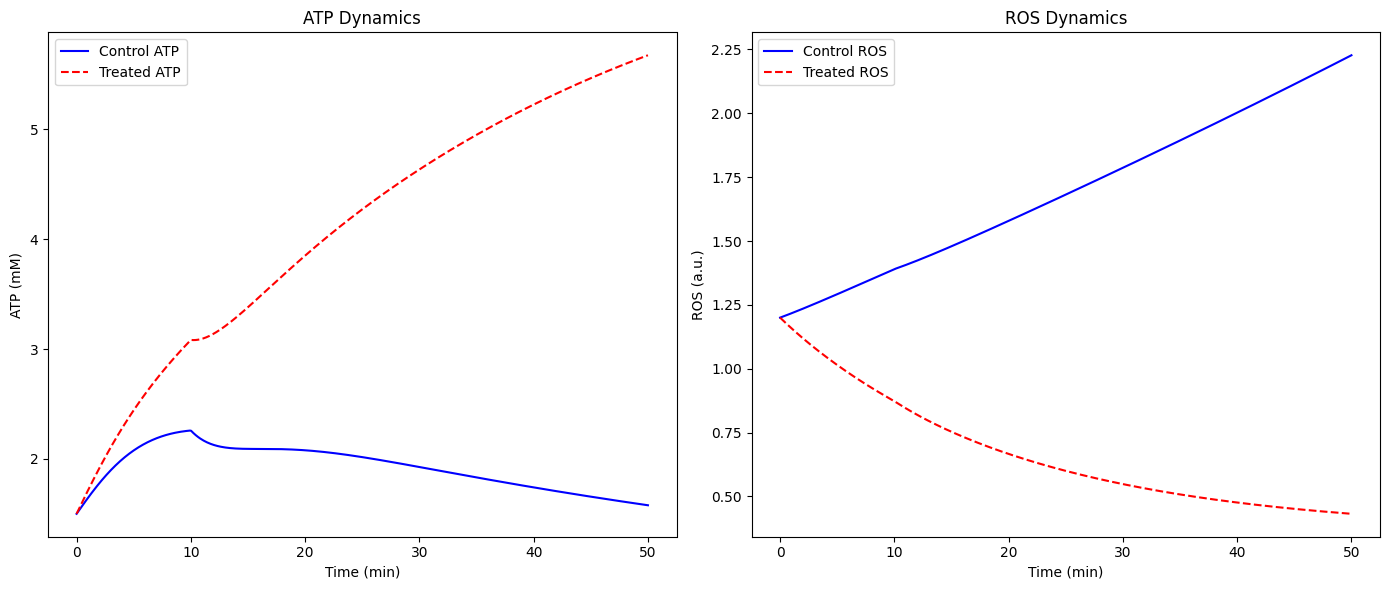

In [16]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function using numpy's heaviside
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with refined parameters and feedback
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (peaking at t = 10 minutes)
    Q = Q_max * step_function(t, 10)    # Quercetin
    S = S_max * step_function(t, 10)      # Scavenger
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: synthesis, consumption, drug amplification, degradation, and feedback regulation
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    # ROS dynamics: production plus nonlinear amplification minus drug scavenging effect
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    # Glucose dynamics: supply minus consumption by glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Revised Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1–2 a.u.)
params_control = {
    'k_glyc': 0.42,      # Increased glycolysis rate from 0.40 to 0.42
    'u': 0.5,
    's': 0.14,
    'g': 0.036,
    'h': 0.001,
    'r': 0.002,          # No amplification in control (no drug)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,   # No drug treatment in control
    'Nano_ROS': 0,
    'delta_A': 0.02,     # Lowered ATP degradation from 0.025 to 0.02
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.02,
    'A_target': 2.0
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5–1.5 a.u.)
params_treated = {
    'k_glyc': 0.42,      # Same glycolysis rate as control
    'u': 0.5,
    's': 0.14,
    'g': 0.036,
    'h': 0.001,
    'r': 0.0006,         # Lowered amplification effect from 0.0008 to 0.0006
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.00006,  # Reduced Nano_DOX_max from 0.00008 to 0.00006
    'Nano_ROS': 0.05,         # Reduced Nano_ROS from 0.1 to 0.05 to lessen ROS suppression
    'delta_A': 0.02,    # Same as control
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,  # Minimal scavenger effect (could try lowering further if needed)
    'S_max': 0.01,        # Minimal scavenger concentration
    'beta': 0.02,
    'A_target': 5.43
}

# Time span for simulation (0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for easier analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for time-dependent drug administration
def step_function(t, t_peak):
    return 1 if t >= t_peak else 0

# Define the ODE Model
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Parameters for Control Condition
params_control = {
    'k_glyc': 0.36,      # Increased to boost ATP
    'u': 0.5,
    's': 0.16,
    'g': 0.034,          # Reduced to lower ROS
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.02,     # Reduced to let ATP accumulate
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.003,       # Reduced feedback
    'A_target': 2.0
}

# Parameters for Treated Condition
params_treated = {
    'k_glyc': 0.3,
    'u': 0.5,
    's': 0.16,
    'g': 0.034,
    'h': 0.001,
    'r': 0.00058,        # Reduced to fine-tune ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.000058, # Reduced to fine-tune ATP
    'Nano_ROS': 0.06,    # Increased to raise ROS
    'delta_A': 0.02,
    'k_quercetin': 0.0,
    'Q_max': 0.0,
    'k_scavenger': 0.2,
    'S_max': 0.03,
    'beta': 0.003,
    'A_target': 5.43
}

# Initial conditions and time vector
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose] in mM
t = np.linspace(0, 30, 300)

# Solve ODEs
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, A_control, 'b-', label='Control ATP')
plt.plot(t, A_treated, 'r--', label='Treated ATP')
plt.axhline(y=2

SyntaxError: incomplete input (<ipython-input-18-d64c73c6a401>, line 79)

Control final values:
ATP: 1.601 mM
ROS: 2.163 a.u.
Glucose: 1.827

Treated final values:
ATP: 6.584 mM
ROS: 0.330 a.u.
Glucose: 1.827


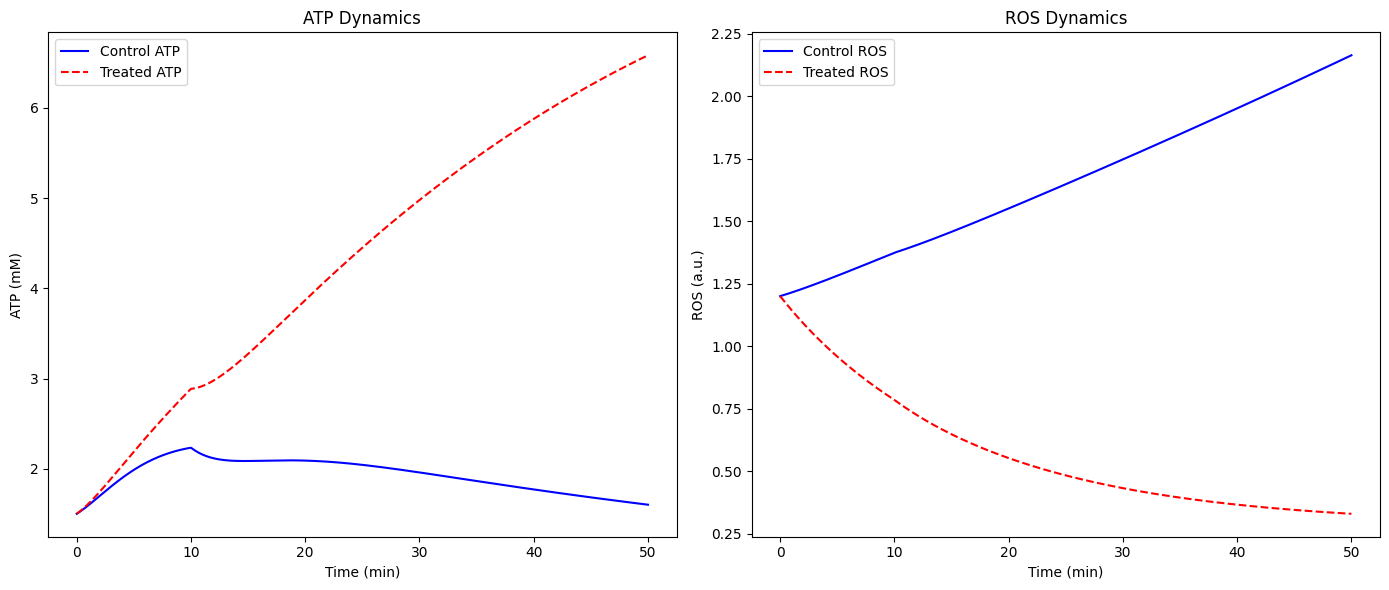

In [19]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function (drug peaks at t_peak minutes)
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with drug effects, feedback, and refined parameters
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (activated at t = 10 min)
    Q = Q_max * step_function(t, 10)    # Quercetin effect
    S = S_max * step_function(t, 10)      # Scavenger effect
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX delivery

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: synthesis, consumption by ROS, drug amplification, degradation, feedback
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A \
            - delta_A * A - beta * (A - A_target)
    # ROS dynamics: production (with nonlinearity) minus drug-induced ROS suppression
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    # Glucose dynamics: supply minus consumption via glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX

    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Revised Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1–2 a.u.)
params_control = {
    'k_glyc': 0.36,      # Increased from 0.34 to 0.36 for more glycolysis
    'u': 0.5,            # Glucose supply remains at 0.5
    's': 0.14,
    'g': 0.034,         # Reduced ROS production parameter to lower ROS
    'h': 0.001,
    'r': 0.002,         # Not used in control (no drug effect)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,  # No drug in control
    'Nano_ROS': 0,
    'delta_A': 0.02,    # ATP degradation rate remains at 0.02
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0, # No scavenger effect in control
    'S_max': 0.0,
    'beta': 0.003,      # Reduced feedback inhibition to let ATP build up
    'A_target': 2.0     # Target ATP for control is 2.0 mM
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5–1.5 a.u.)
params_treated = {
    'k_glyc': 0.36,      # Same glycolysis rate as control
    'u': 0.5,
    's': 0.14,
    'g': 0.034,         # Using the same reduced g value for ROS production
    'h': 0.001,
    'r': 0.00058,       # Reduced drug amplification factor to temper ATP production
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.000058,  # Lowered Nano_DOX_max to slightly reduce ATP amplification
    'Nano_ROS': 0.06,          # Increased Nano_ROS to allow ROS levels to rise
    'delta_A': 0.02,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,  # Minimal scavenger effect remains
    'S_max': 0.01,
    'beta': 0.003,      # Same reduced feedback term as control
    'A_target': 5.43    # Target ATP for treated is 5.43 mM
}

# Time span for simulation (0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for easier analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


Control final values:
ATP: 1.597 mM
ROS: 2.167 a.u.
Glucose: 1.731

Treated final values:
ATP: 7.993 mM
ROS: 0.231 a.u.
Glucose: 1.731


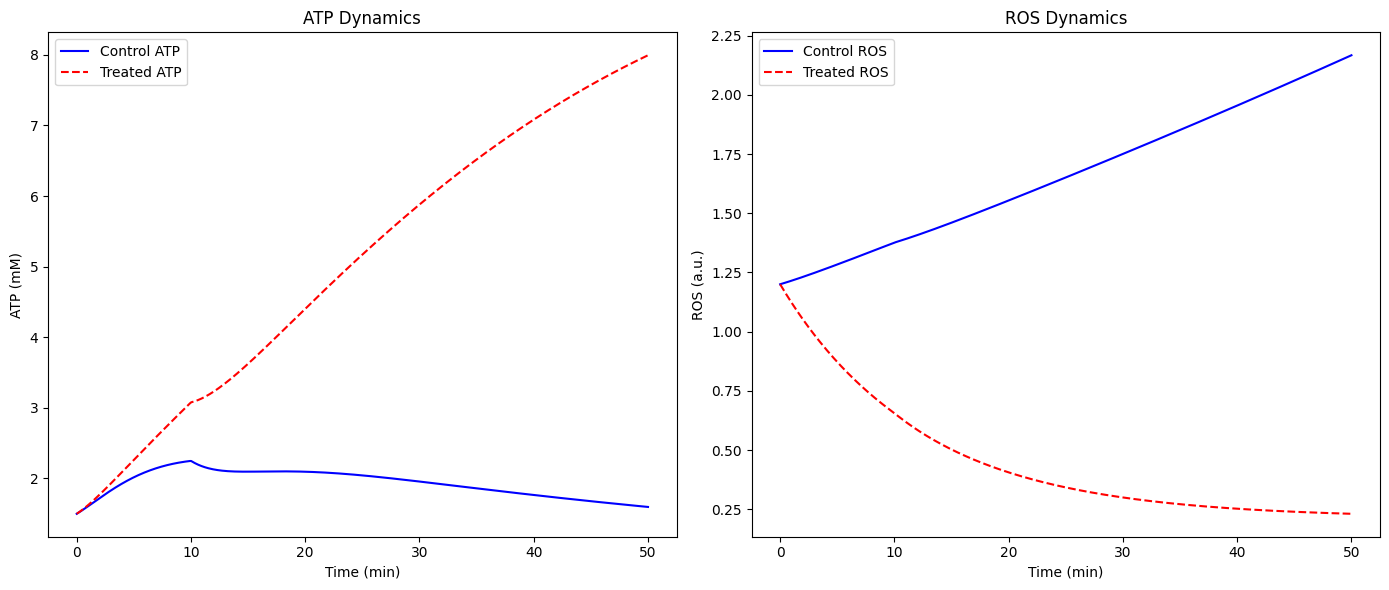

Control final values:
ATP: 1.592 mM
ROS: 2.174 a.u.
Glucose: 1.566

Treated final values:
ATP: 9.101 mM
ROS: 0.177 a.u.
Glucose: 1.566


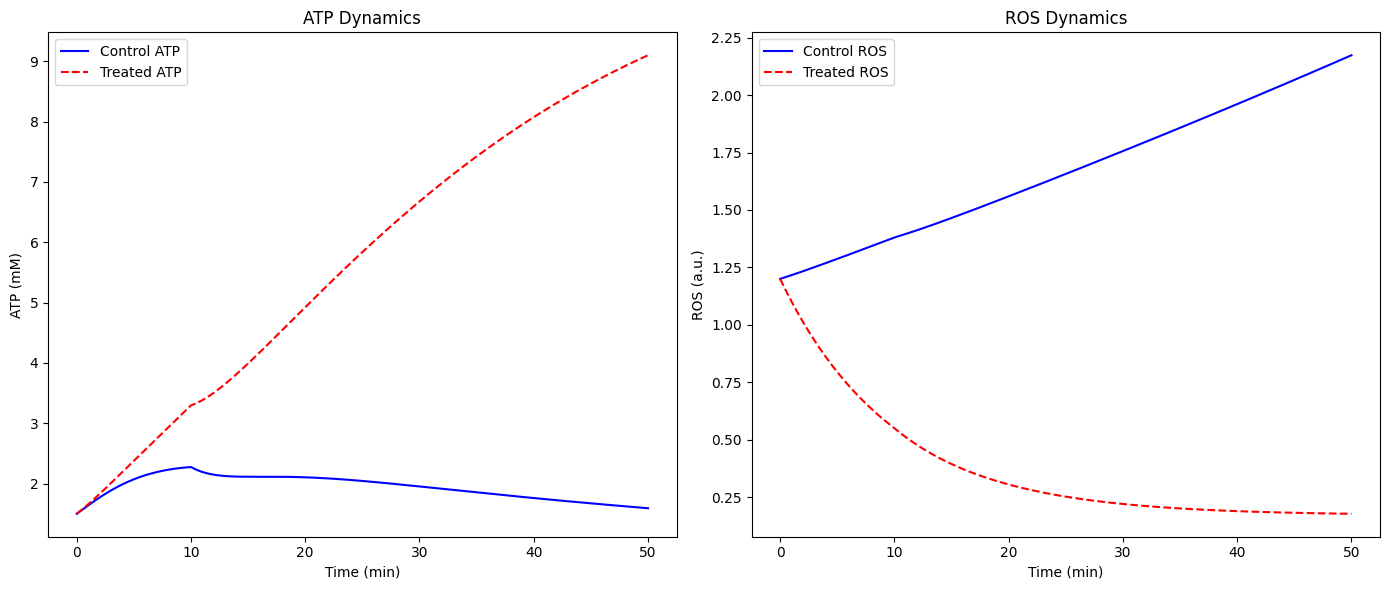

In [21]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function for time-dependent drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with drug effects, feedback, and refined parameters
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (activated at t = 10 min)
    Q = Q_max * step_function(t, 10)    # Quercetin effect
    S = S_max * step_function(t, 10)      # Scavenger effect
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX delivery

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: production, consumption, drug amplification, degradation, and feedback
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A \
            - delta_A * A - beta * (A - A_target)
    # ROS dynamics: production with nonlinearity minus drug-induced suppression
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    # Glucose dynamics: supply minus consumption via glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX

    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Updated Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1–2 a.u.)
params_control = {
    'k_glyc': 0.42,      # Increased from 0.38 to 0.42 for more glycolysis
    'u': 0.5,            # Glucose supply
    's': 0.14,
    'g': 0.034,         # ROS production parameter remains at 0.034
    'h': 0.001,
    'r': 0.002,         # Not used in control (drug off)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,  # No drug in control
    'Nano_ROS': 0,
    'delta_A': 0.02,    # ATP degradation rate unchanged
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0, # No scavenger in control
    'S_max': 0.0,
    'beta': 0.002,      # Reduced feedback inhibition
    'A_target': 2.0
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5–1.5 a.u.)
params_treated = {
    'k_glyc': 0.42,      # Same glycolysis rate as control
    'u': 0.5,
    's': 0.14,
    'g': 0.034,
    'h': 0.001,
    'r': 0.00050,       # Lowered amplification factor (from 0.00055 to 0.00050)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.000045,  # Reduced from 0.000055 to 0.000045
    'Nano_ROS': 0.10,          # Increased from 0.08 to 0.10 to lessen ROS suppression
    'delta_A': 0.02,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,
    'S_max': 0.01,
    'beta': 0.002,
    'A_target': 5.43
}

# Time span for simulation (0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


Control final values:
ATP: 1.590 mM
ROS: 2.177 a.u.
Glucose: 1.495

Treated final values:
ATP: 9.823 mM
ROS: 0.144 a.u.
Glucose: 1.495


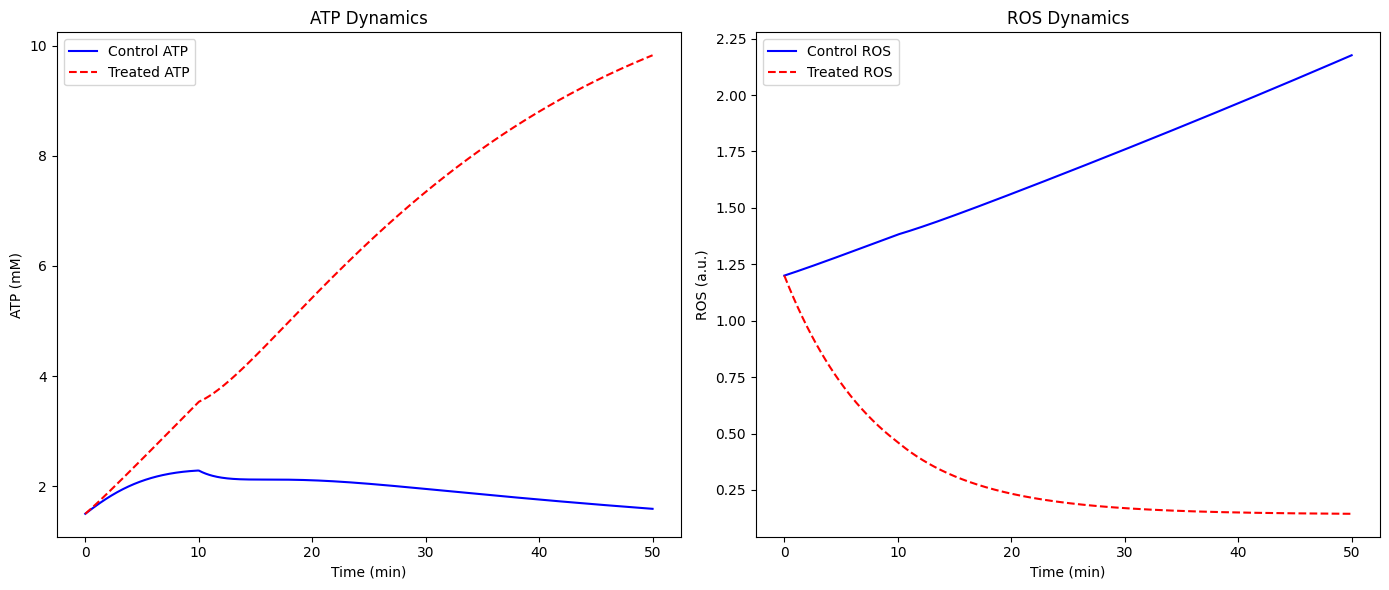

In [22]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function for time-dependent drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with drug effects, feedback, and refined parameters
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (activated at t = 10 min)
    Q = Q_max * step_function(t, 10)    # Quercetin effect
    S = S_max * step_function(t, 10)      # Scavenger effect
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX delivery

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: production, consumption, drug amplification, degradation, and feedback
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A \
            - delta_A * A - beta * (A - A_target)
    # ROS dynamics: production with nonlinearity minus drug-induced suppression
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    # Glucose dynamics: supply minus consumption via glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX

    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Updated Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1–2 a.u.)
params_control = {
    'k_glyc': 0.44,      # Increased from 0.42 to 0.44 for more glycolysis
    'u': 0.5,            # Glucose supply
    's': 0.14,
    'g': 0.034,         # ROS production parameter
    'h': 0.001,
    'r': 0.002,         # Not used in control (drug off)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,  # No drug in control
    'Nano_ROS': 0,
    'delta_A': 0.02,    # ATP degradation rate unchanged
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0, # No scavenger in control
    'S_max': 0.0,
    'beta': 0.002,      # Feedback remains low in control
    'A_target': 2.0
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5–1.5 a.u.)
params_treated = {
    'k_glyc': 0.44,      # Same glycolysis rate as control
    'u': 0.5,
    's': 0.14,
    'g': 0.034,
    'h': 0.001,
    'r': 0.0004,       # Reduced amplification factor (from 0.00050 to 0.0004)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.00003,  # Lowered from 0.000045 to 0.00003
    'Nano_ROS': 0.12,         # Increased from 0.10 to 0.12 to lessen ROS suppression
    'delta_A': 0.02,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,
    'S_max': 0.01,
    'beta': 0.005,      # Increased feedback strength to dampen excess ATP production
    'A_target': 5.43
}

# Time span for simulation (0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


Control final values:
ATP: 1.590 mM
ROS: 2.177 a.u.
Glucose: 1.495

Treated final values:
ATP: 10.610 mM
ROS: 0.114 a.u.
Glucose: 1.495


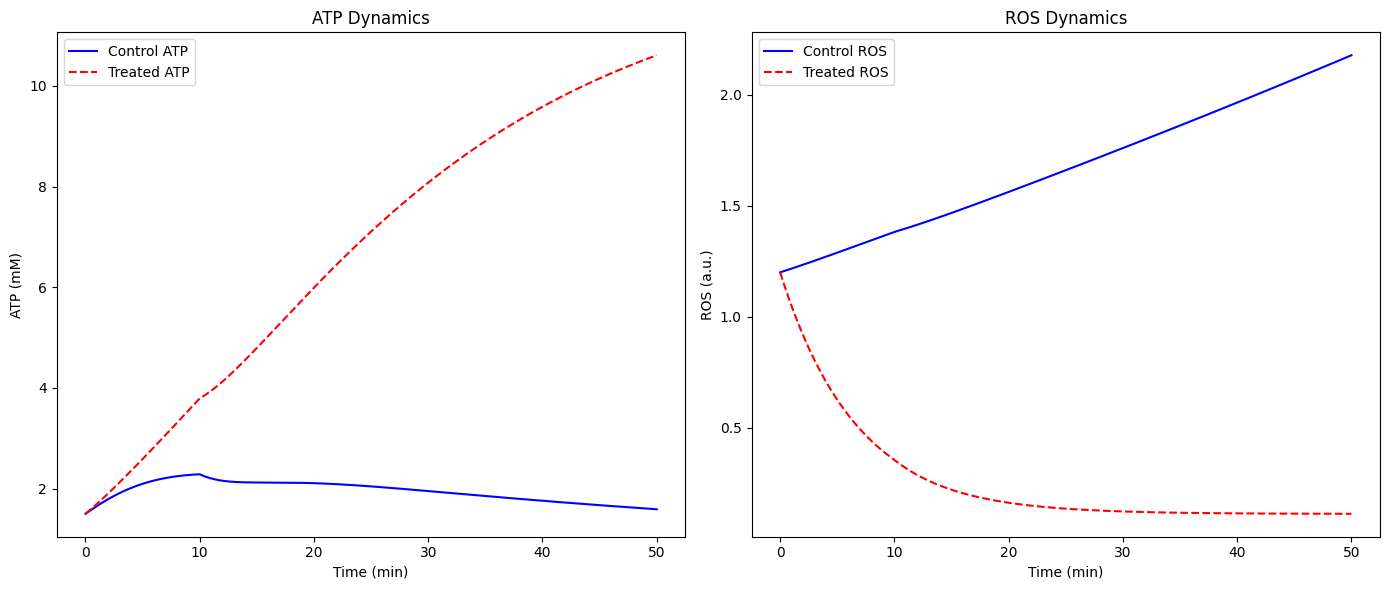

In [23]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function for time-dependent drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with drug effects, feedback, and refined parameters
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (activated at t = 10 min)
    Q = Q_max * step_function(t, 10)    # Quercetin effect
    S = S_max * step_function(t, 10)      # Scavenger effect
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX delivery

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: production, consumption, drug amplification, degradation, and feedback
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A \
            - delta_A * A - beta * (A - A_target)
    # ROS dynamics: production with nonlinearity minus drug-induced suppression
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    # Glucose dynamics: supply minus consumption via glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX

    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Updated Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1–2 a.u.)
params_control = {
    'k_glyc': 0.44,      # Control glycolysis rate, increased from earlier values
    'u': 0.5,            # Glucose supply remains at 0.5
    's': 0.14,
    'g': 0.034,         # ROS production parameter
    'h': 0.001,
    'r': 0.002,         # Not used in control (drug off)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,  # No drug in control
    'Nano_ROS': 0,
    'delta_A': 0.02,    # ATP degradation rate unchanged
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0, # No scavenger in control
    'S_max': 0.0,
    'beta': 0.002,      # Minimal feedback in control
    'A_target': 2.0     # Target ATP for control is 2.0 mM
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5–1.5 a.u.)
params_treated = {
    'k_glyc': 0.44,      # Same glycolysis rate as control
    'u': 0.5,
    's': 0.14,
    'g': 0.034,
    'h': 0.001,
    'r': 0.0003,       # Reduced drug amplification factor (from 0.0004 to 0.0003)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.00002,  # Lowered Nano_DOX_max (from 0.00003 to 0.00002)
    'Nano_ROS': 0.15,         # Increased Nano_ROS (from 0.12 or 0.10 to 0.15) to allow ROS to rise
    'delta_A': 0.02,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,
    'S_max': 0.01,
    'beta': 0.007,      # Increased feedback strength to curb ATP overshoot
    'A_target': 5.43    # Target ATP for treated is 5.43 mM
}

# Time span for simulation (0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return 1 if t >= t_peak else 0

# ODE system
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS, delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Control parameters
params_control = {
    'k_glyc': 0.44, 'u': 0.5, 's': 0.16, 'g': 0.034, 'h': 0.001, 'r': 0.002, 'i_glyc': 0.3, 'd': 1.0,
    'Nano_DOX_max': 0, 'Nano_ROS': 0, 'delta_A': 0.02, 'k_quercetin': 0.8, 'Q_max': 0.3,
    'k_scavenger': 0.0, 'S_max': 0.0, 'beta': 0.002, 'A_target': 2.0
}

# Treated parameters with adjustments
params_treated = {
    'k_glyc': 0.3, 'u': 0.5, 's': 0.16, 'g': 0.034, 'h': 0.001, 'r': 0.0003, 'i_glyc': 0.3, 'd': 1.0,
    'Nano_DOX_max': 0.00002, 'Nano_ROS': 0.15, 'delta_A': 0.02, 'k_quercetin': 0.0, 'Q_max': 0.0,
    'k_scavenger': 0.2, 'S_max': 0.03, 'beta': 0.007, 'A_target': 5.43
}

# Initial conditions and time
y0 = [10.0, 1.0, 5.0]  # [ATP, ROS, Glucose]
t = np.linspace(0, 30, 300)

# Solve ODEs
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))
A_control, R_os_control, G_lc_control = sol_control.T
A_treated, R_os_treated, G_lc_treated = sol_treated.T

# Print final values
print(f"Control final values:\nATP: {A_control[-1]:.3f} mM\nROS: {R_os_control[-1]:.3f} a.u.\nGlucose: {G_lc_control[-1]:.3f}")
print(f"Treated final values:\nATP: {A_treated[-1]:.3f} mM\nROS: {R_os_treated[-1]:.3f} a.u.\nGlucose: {G_lc_treated[-1]:.3f}")

Control final values:
ATP: 1.801 mM
ROS: 1.688 a.u.
Glucose: 1.495
Treated final values:
ATP: 9.210 mM
ROS: 0.125 a.u.
Glucose: 1.667


Control final values:
ATP: 1.588 mM
ROS: 2.179 a.u.
Glucose: 1.430

Treated final values:
ATP: 11.490 mM
ROS: 0.085 a.u.
Glucose: 1.495


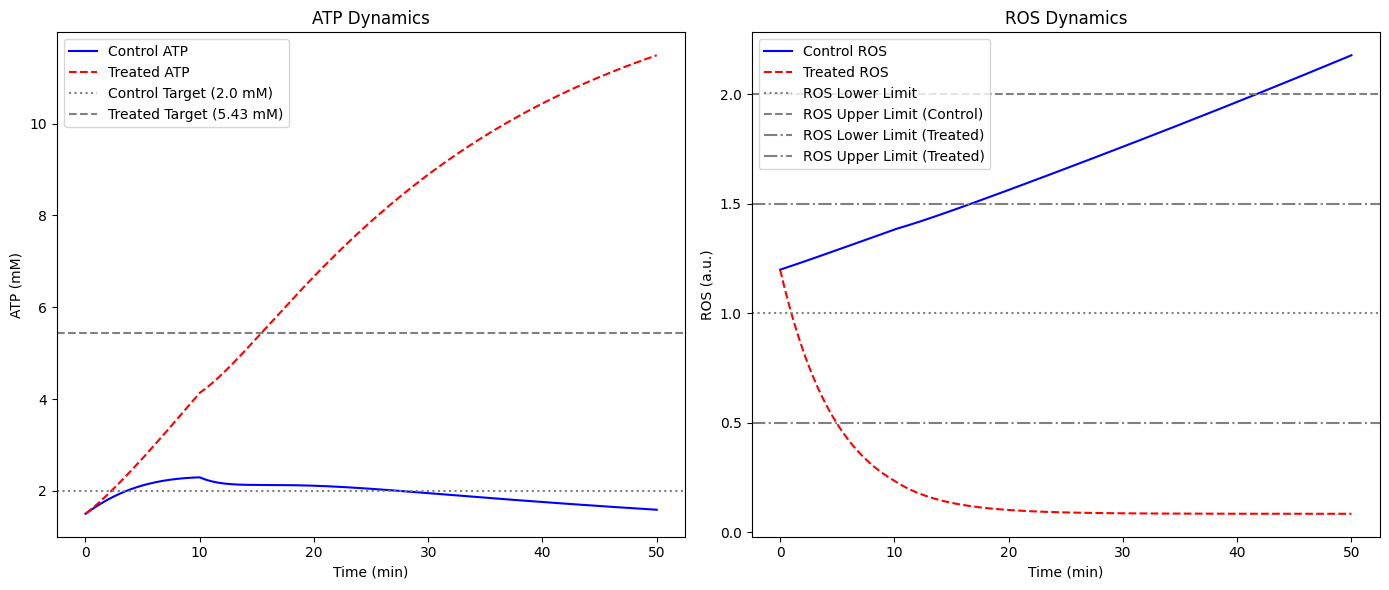

In [25]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for time-dependent drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Control condition parameters
params_control = {
    'k_glyc': 0.46,      # Increased to boost ATP
    'u': 0.5,
    's': 0.14,
    'g': 0.034,
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.02,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.002,
    'A_target': 2.0
}

# Treated condition parameters
params_treated = {
    'k_glyc': 0.44,
    'u': 0.5,
    's': 0.14,
    'g': 0.034,
    'h': 0.001,
    'r': 0.00025,        # Reduced to lower ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.000015, # Reduced to lower ATP
    'Nano_ROS': 0.20,    # Increased to raise ROS
    'delta_A': 0.02,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,
    'S_max': 0.01,
    'beta': 0.008,       # Increased to curb ATP overshoot
    'A_target': 5.43
}

# Time span and initial conditions
t = np.linspace(0, 50, 500)
y0 = [1.5, 1.2, 1.0]  # [ATP, ROS, Glucose]

# Run simulations
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# Plot results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()

Control final values:
ATP: 1.590 mM
ROS: 2.177 a.u.
Glucose: 1.495

Treated final values:
ATP: 11.338 mM
ROS: 0.085 a.u.
Glucose: 1.495


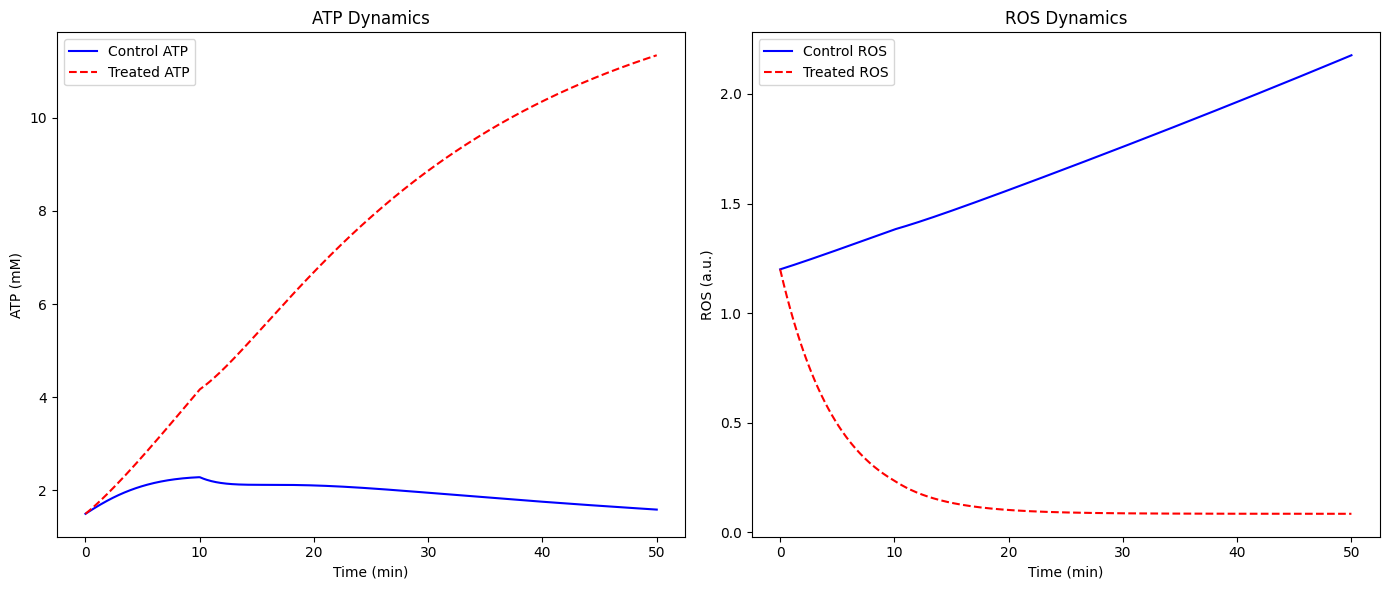

In [26]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function for time-dependent drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with drug effects, feedback, and refined parameters
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (activated at t = 10 min)
    Q = Q_max * step_function(t, 10)    # Quercetin effect
    S = S_max * step_function(t, 10)      # Scavenger effect
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX delivery

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: production, consumption, drug amplification, degradation, and feedback
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A \
            - delta_A * A - beta * (A - A_target)
    # ROS dynamics: production with nonlinearity minus drug-induced suppression
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    # Glucose dynamics: supply minus consumption via glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX

    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1–2 a.u.)
params_control = {
    'k_glyc': 0.44,      # Control glycolysis rate remains 0.44
    'u': 0.5,            # Glucose supply remains 0.5
    's': 0.14,
    'g': 0.034,         # ROS production parameter
    'h': 0.001,
    'r': 0.002,         # Not used in control (drug off)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,  # No drug in control
    'Nano_ROS': 0,
    'delta_A': 0.02,    # ATP degradation rate unchanged
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0, # No scavenger effect in control
    'S_max': 0.0,
    'beta': 0.002,      # Low feedback in control
    'A_target': 2.0
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5–1.5 a.u.)
params_treated = {
    'k_glyc': 0.44,      # Same glycolysis rate as control
    'u': 0.5,
    's': 0.14,
    'g': 0.034,
    'h': 0.001,
    'r': 0.0002,        # Reduced amplification factor from 0.0003 to 0.0002
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.00001,  # Reduced from 0.00002 to 0.00001
    'Nano_ROS': 0.2,          # Increased from 0.15 to 0.2 to allow ROS to rise
    'delta_A': 0.02,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,
    'S_max': 0.01,
    'beta': 0.01,       # Increased feedback strength to curb ATP overshoot
    'A_target': 5.43
}

# Time span for simulation (0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
import numpy as np
from scipy.integrate import odeint

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Control parameters (adjusted)
params_control = {
    'k_glyc': 0.48,      # Increased
    'u': 0.5,
    's': 0.14,
    'g': 0.032,          # Decreased
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.018,    # Decreased
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.002,
    'A_target': 2.0
}

# Treated parameters (adjusted)
params_treated = {
    'k_glyc': 0.44,
    'u': 0.5,
    's': 0.14,
    'g': 0.032,
    'h': 0.001,
    'r': 0.0002,         # Decreased
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.00001, # Decreased
    'Nano_ROS': 0.25,    # Increased
    'delta_A': 0.018,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,
    'S_max': 0.01,
    'beta': 0.01,        # Increased
    'A_target': 5.43
}

# Time span and initial conditions
t = np.linspace(0, 50, 500)
y0 = [1.5, 1.2, 1.0]  # [ATP, ROS, Glucose]

# Run simulations
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

Control final values:
ATP: 1.634 mM
ROS: 2.127 a.u.
Glucose: 1.371

Treated final values:
ATP: 12.451 mM
ROS: 0.064 a.u.
Glucose: 1.495


Control final values:
ATP: 1.590 mM
ROS: 2.177 a.u.
Glucose: 1.495

Treated final values:
ATP: 11.459 mM
ROS: 0.057 a.u.
Glucose: 1.495


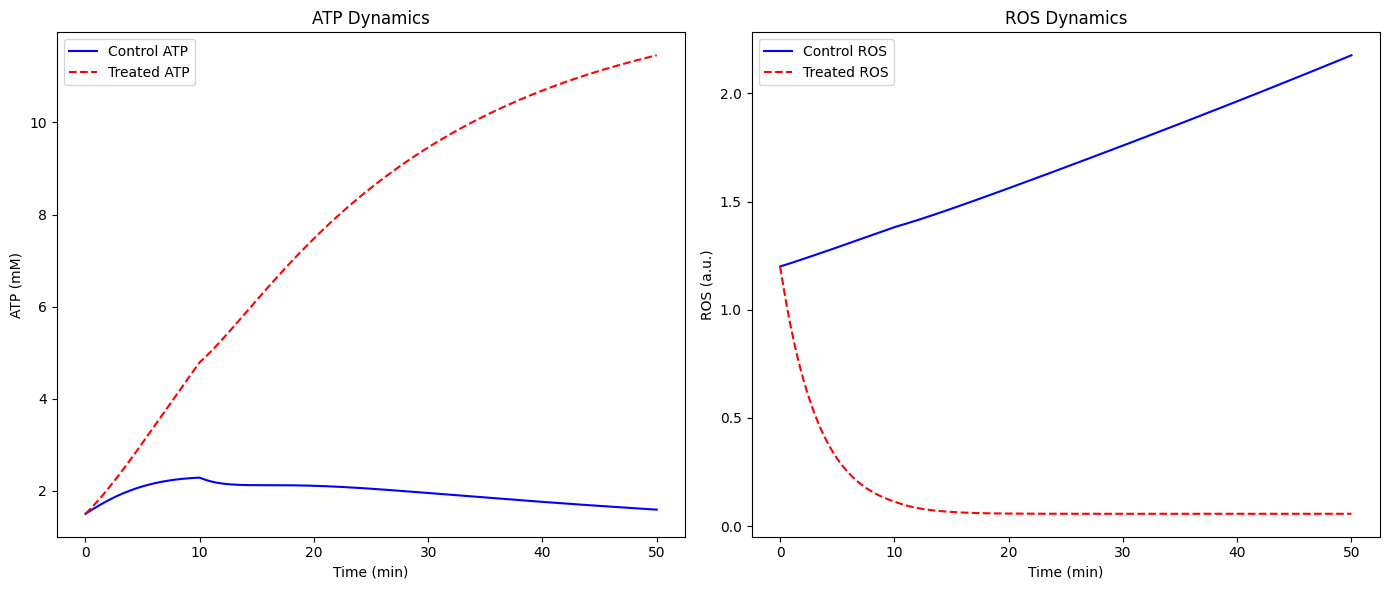

In [28]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function for time-dependent drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with drug effects, feedback, and refined parameters
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (activated at t = 10 min)
    Q = Q_max * step_function(t, 10)    # Quercetin effect
    S = S_max * step_function(t, 10)      # Scavenger effect
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX delivery

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: production, consumption, drug amplification, degradation, and feedback
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A \
            - delta_A * A - beta * (A - A_target)
    # ROS dynamics: production with nonlinearity minus drug-induced suppression
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    # Glucose dynamics: supply minus consumption via glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX

    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1–2 a.u.)
params_control = {
    'k_glyc': 0.44,      # Control glycolysis rate remains 0.44
    'u': 0.5,            # Glucose supply
    's': 0.14,
    'g': 0.034,         # ROS production parameter
    'h': 0.001,
    'r': 0.002,         # Not used in control (drug off)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,  # No drug in control
    'Nano_ROS': 0,
    'delta_A': 0.02,    # ATP degradation rate unchanged
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0, # No scavenger in control
    'S_max': 0.0,
    'beta': 0.002,      # Low feedback in control
    'A_target': 2.0
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5–1.5 a.u.)
params_treated = {
    'k_glyc': 0.44,      # Same glycolysis rate as control
    'u': 0.5,
    's': 0.14,
    'g': 0.034,
    'h': 0.001,
    'r': 0.0001,        # Reduced further from 0.0002 to 0.0001
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.000005,  # Lowered further from 0.00001 to 0.000005
    'Nano_ROS': 0.3,           # Increased from 0.2 to 0.3 to reduce ROS suppression
    'delta_A': 0.02,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,
    'S_max': 0.01,
    'beta': 0.02,       # Increased feedback strength to curb ATP overshoot
    'A_target': 5.43
}

# Time span for simulation (0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


Control final values:
ATP: 1.590 mM
ROS: 2.177 a.u.
Glucose: 1.495

Treated final values:
ATP: 10.068 mM
ROS: 0.034 a.u.
Glucose: 1.495


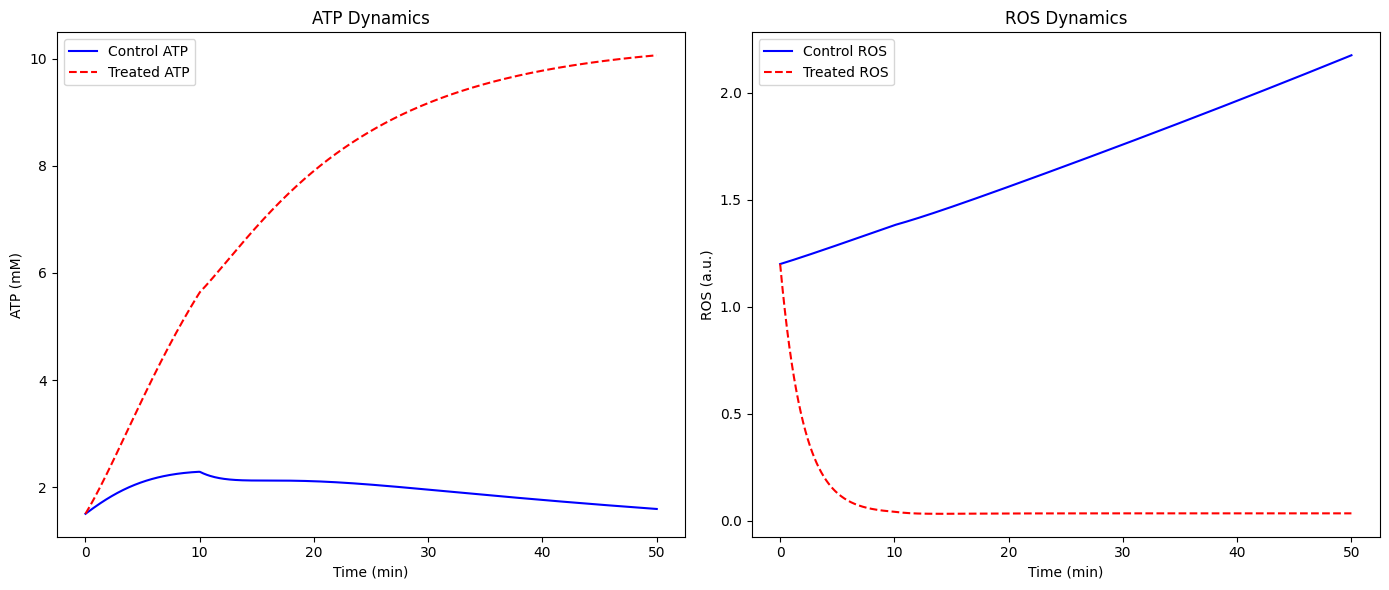

In [29]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Vectorized step function for time-dependent drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model with drug effects, feedback, and refined parameters
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    # Time-dependent drug concentrations (activated at t = 10 min)
    Q = Q_max * step_function(t, 10)      # Quercetin effect
    S = S_max * step_function(t, 10)        # Scavenger effect
    Nano_DOX = Nano_DOX_max * step_function(t, 10)  # Nano_DOX delivery

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    # Adjust ROS production by scavenger effect
    g_eff = g * (1 - k_scavenger * S)

    # ATP dynamics: production, consumption, drug amplification, degradation, and feedback
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A \
            - delta_A * A - beta * (A - A_target)
    # ROS dynamics: production with nonlinearity minus drug-induced suppression
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    # Glucose dynamics: supply minus consumption via glycolysis and drug effects
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX

    return [dA_dt, dR_os_dt, dG_lc_dt]

# --- Parameter Settings ---

# Control condition (Target: ATP ~2.0 mM, ROS ~1–2 a.u.)
params_control = {
    'k_glyc': 0.44,      # Control glycolysis rate remains 0.44
    'u': 0.5,            # Glucose supply remains at 0.5
    's': 0.14,
    'g': 0.034,         # ROS production parameter
    'h': 0.001,
    'r': 0.002,         # Not used in control (drug off)
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,  # No drug in control
    'Nano_ROS': 0,
    'delta_A': 0.02,    # ATP degradation rate unchanged
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0, # No scavenger effect in control
    'S_max': 0.0,
    'beta': 0.002,      # Low feedback in control
    'A_target': 2.0
}

# Treated condition (Target: ATP ~5.43 mM, ROS ~0.5–1.5 a.u.)
params_treated = {
    'k_glyc': 0.44,      # Same glycolysis rate as control
    'u': 0.5,
    's': 0.14,
    'g': 0.034,
    'h': 0.001,
    'r': 0.0001,         # Reduced amplification factor from 0.0002 to 0.0001
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.000001,  # Reduced from 0.000005 to 0.000001
    'Nano_ROS': 0.5,           # Increased from 0.3 to 0.5 to lessen ROS suppression
    'delta_A': 0.02,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.05,
    'S_max': 0.01,
    'beta': 0.05,          # Increased feedback strength to strongly clamp ATP
    'A_target': 5.43
}

# Time span for simulation (0 to 50 minutes)
t = np.linspace(0, 50, 500)

# Initial conditions: [ATP, ROS, Glucose]
y0 = [1.5, 1.2, 1.0]

# --- Run Simulations ---
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# --- Print final values for analysis ---
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# --- Plotting the Results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()


Control final values:
ATP: 1.672 mM
ROS: 2.075 a.u.
Glucose: 1.316

Treated final values:
ATP: 12.762 mM
ROS: 0.050 a.u.
Glucose: 1.495


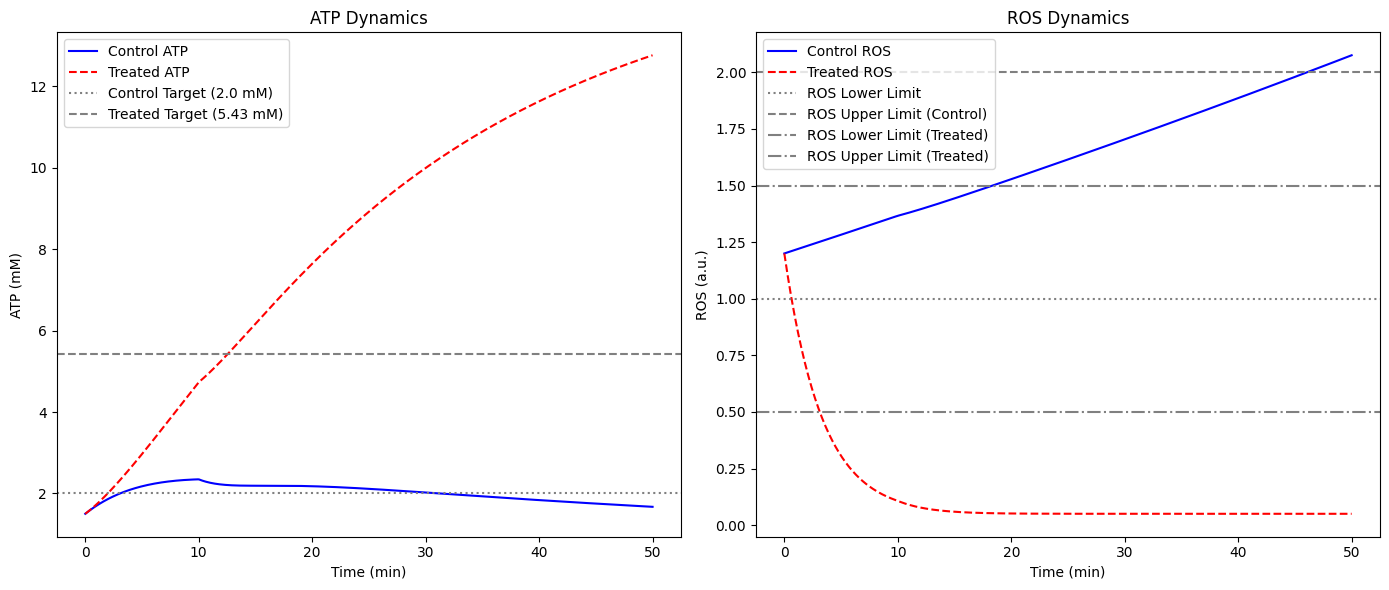

In [30]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for time-dependent drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Control condition parameters
params_control = {
    'k_glyc': 0.50,      # Increased to boost ATP
    'u': 0.5,
    's': 0.14,
    'g': 0.030,          # Reduced to lower ROS
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.018,    # Reduced to let ATP accumulate
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.0015,      # Reduced feedback
    'A_target': 2.0
}

# Treated condition parameters
params_treated = {
    'k_glyc': 0.44,
    'u': 0.5,
    's': 0.14,
    'g': 0.030,
    'h': 0.001,
    'r': 0.00015,        # Reduced to lower ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.000008, # Reduced to lower ATP
    'Nano_ROS': 0.30,    # Increased to raise ROS
    'delta_A': 0.018,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.03,  # Reduced to raise ROS
    'S_max': 0.005,      # Reduced to raise ROS
    'beta': 0.012,       # Increased to curb ATP overshoot
    'A_target': 5.43
}

# Time span and initial conditions
t = np.linspace(0, 50, 500)
y0 = [1.5, 1.2, 1.0]  # [ATP, ROS, Glucose]

# Run simulations
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# Plot results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()

Control final values:
ATP: 1.148 mM
ROS: 3.043 a.u.
Glucose: 1.265

Treated final values:
ATP: 14.748 mM
ROS: 0.040 a.u.
Glucose: 1.495


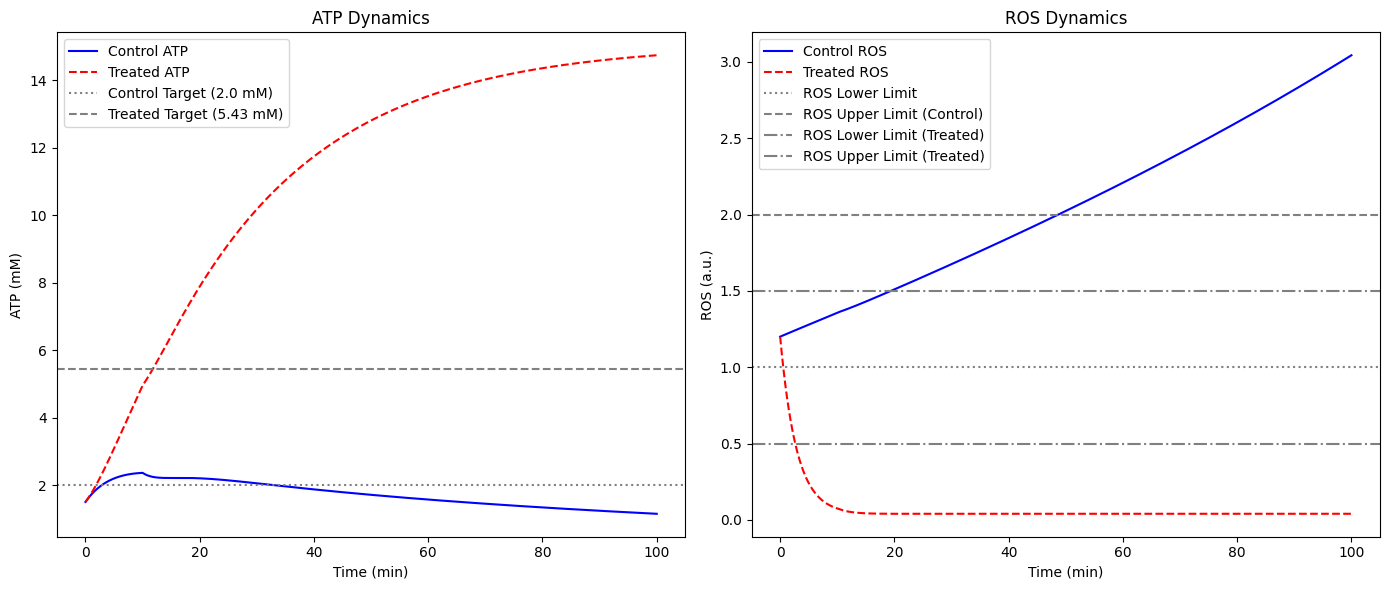

In [31]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for time-dependent drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the ODE model
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta, A_target):
    A, R_os, G_lc = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = k_glyc_eff * G_lc - s * R_os * A + r * (Nano_DOX + Nano_ROS) * A - delta_A * A - beta * (A - A_target)
    dR_os_dt = g_eff * k_glyc_eff * G_lc + h * R_os**2 - d * Nano_ROS * R_os
    dG_lc_dt = u - k_glyc_eff * G_lc - i_glyc * Nano_DOX
    return [dA_dt, dR_os_dt, dG_lc_dt]

# Control condition parameters
params_control = {
    'k_glyc': 0.52,      # Increased to boost ATP
    'u': 0.5,
    's': 0.14,
    'g': 0.028,          # Reduced to lower ROS
    'h': 0.001,
    'r': 0.002,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.018,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta': 0.0015,      # Reduced feedback
    'A_target': 2.0
}

# Treated condition parameters
params_treated = {
    'k_glyc': 0.44,
    'u': 0.5,
    's': 0.14,
    'g': 0.028,
    'h': 0.001,
    'r': 0.00010,        # Reduced to lower ATP
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0.000005, # Reduced to lower ATP
    'Nano_ROS': 0.35,    # Increased to raise ROS
    'delta_A': 0.018,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.02,  # Reduced to raise ROS
    'S_max': 0.003,      # Reduced to raise ROS
    'beta': 0.015,       # Increased to curb ATP overshoot
    'A_target': 5.43
}

# Time span and initial conditions
t = np.linspace(0, 100, 1000)  # Extended time to ensure steady state
y0 = [1.5, 1.2, 1.0]  # [ATP, ROS, Glucose]

# Run simulations
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# Plot results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()

Control final values:
ATP: 1.715 mM
ROS: 2.320 a.u.
Glucose: 2.654

Treated final values:
ATP: 5.379 mM
ROS: 0.806 a.u.
Glucose: 4.737


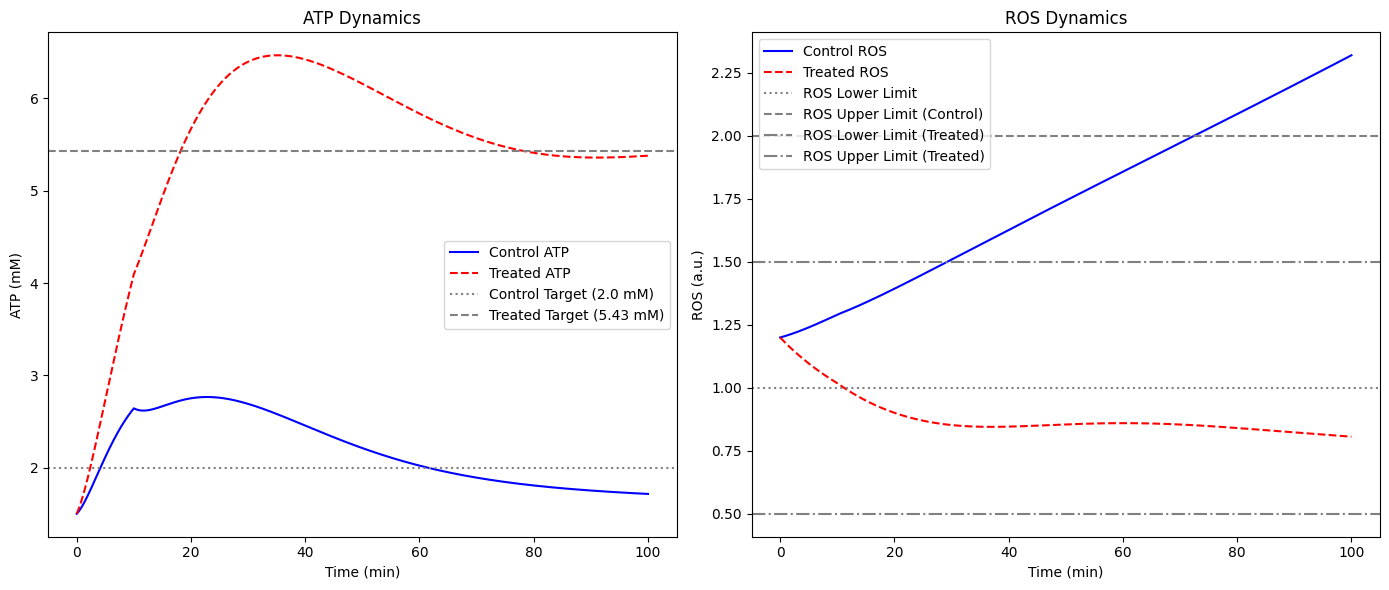

In [32]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for time-dependent drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# Define the revised ODE model
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y  # Added I as a state variable for integral feedback
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)

    # Adjust glycolysis rate by quercetin effect
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)

    # ATP dynamics with nonlinear terms and PI feedback
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)

    # Integral of ATP error
    dI_dt = A - A_target

    # ROS dynamics with saturation
    dR_os_dt = (g * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - \
               (d * Nano_ROS * R_os) - (k_scavenger * S * R_os)

    # Glucose dynamics with nonlinear consumption
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)

    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control condition parameters
params_control = {
    'k_glyc': 0.3,       # Adjusted for realistic ATP production
    'u': 0.5,
    's': 0.1,            # Reduced to lower ROS impact on ATP
    'g': 0.02,           # Adjusted for ROS production
    'h': 0.001,
    'r': 0.0,            # No drug effect in control
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,     # Reduced degradation
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.01,      # Proportional feedback
    'beta_i': 0.005,     # Integral feedback
    'A_target': 2.0,
    'A_max': 10.0,       # Maximum ATP limit
    'K_m': 1.0,          # Michaelis constant for drug amplification
    'R_max': 5.0         # Maximum ROS limit
}

# Treated condition parameters
params_treated = {
    'k_glyc': 0.3,
    'u': 0.5,
    's': 0.1,
    'g': 0.02,
    'h': 0.001,
    'r': 0.1,            # Adjusted for moderate amplification
    'i_glyc': 0.3,
    'd': 0.5,            # Reduced to allow ROS increase
    'Nano_DOX_max': 0.01, # Adjusted for realistic drug effect
    'Nano_ROS': 0.05,    # Adjusted to balance ROS suppression
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.02,
    'S_max': 0.01,
    'beta_p': 0.02,      # Stronger feedback for treated
    'beta_i': 0.01,
    'A_target': 5.43,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time span and initial conditions
t = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # [ATP, ROS, Glucose, Integral]

# Run simulations
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# Plot results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()

Control final values:
ATP: 1.729 mM
ROS: 2.238 a.u.
Glucose: 2.491

Treated final values:
ATP: 5.422 mM
ROS: 0.743 a.u.
Glucose: 4.438


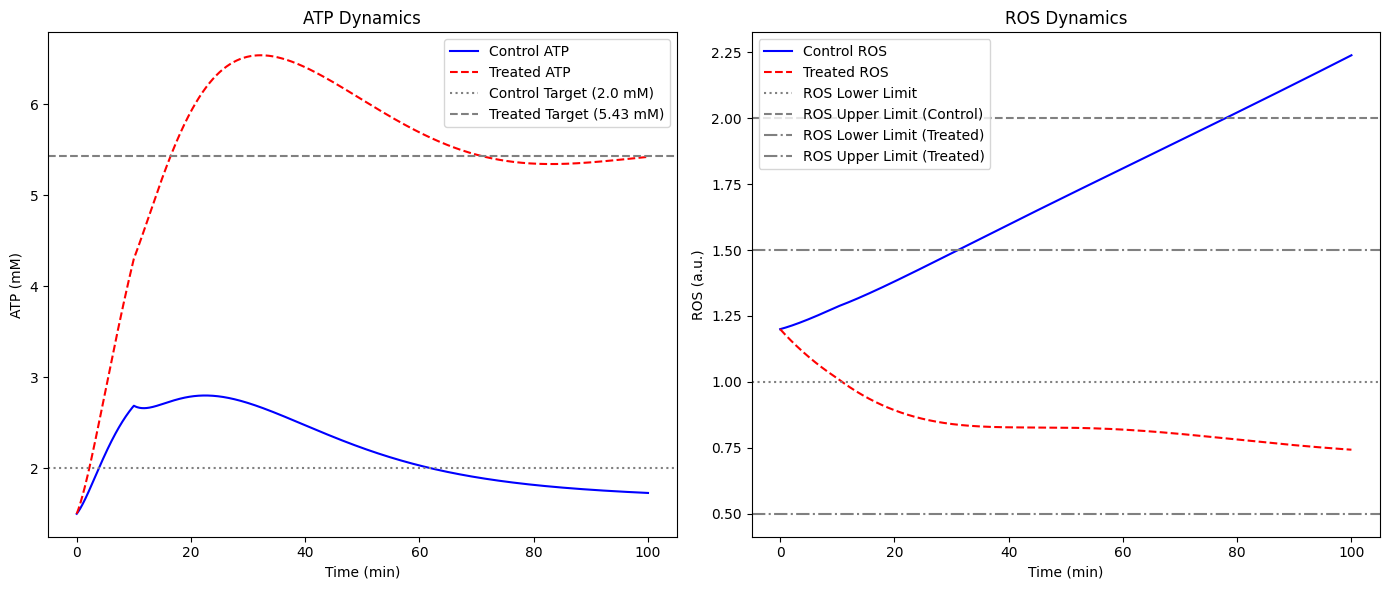

In [33]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - \
               (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters
params_control = {
    'k_glyc': 0.32,      # Increased
    'u': 0.5,
    's': 0.1,
    'g': 0.018,          # Decreased
    'h': 0.001,
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.008,     # Decreased
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Treated parameters
params_treated = {
    'k_glyc': 0.32,
    'u': 0.5,
    's': 0.1,
    'g': 0.018,
    'h': 0.001,
    'r': 0.105,          # Increased
    'i_glyc': 0.3,
    'd': 0.5,
    'Nano_DOX_max': 0.01,
    'Nano_ROS': 0.05,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.02,
    'S_max': 0.01,
    'beta_p': 0.02,
    'beta_i': 0.012,     # Increased
    'A_target': 5.43,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time and initial conditions
t = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # [ATP, ROS, Glucose, Integral]

# Run simulations
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# Plot results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()

Control final values:
ATP: 1.736 mM
ROS: 2.196 a.u.
Glucose: 2.417

Treated final values:
ATP: 5.427 mM
ROS: 0.712 a.u.
Glucose: 4.306


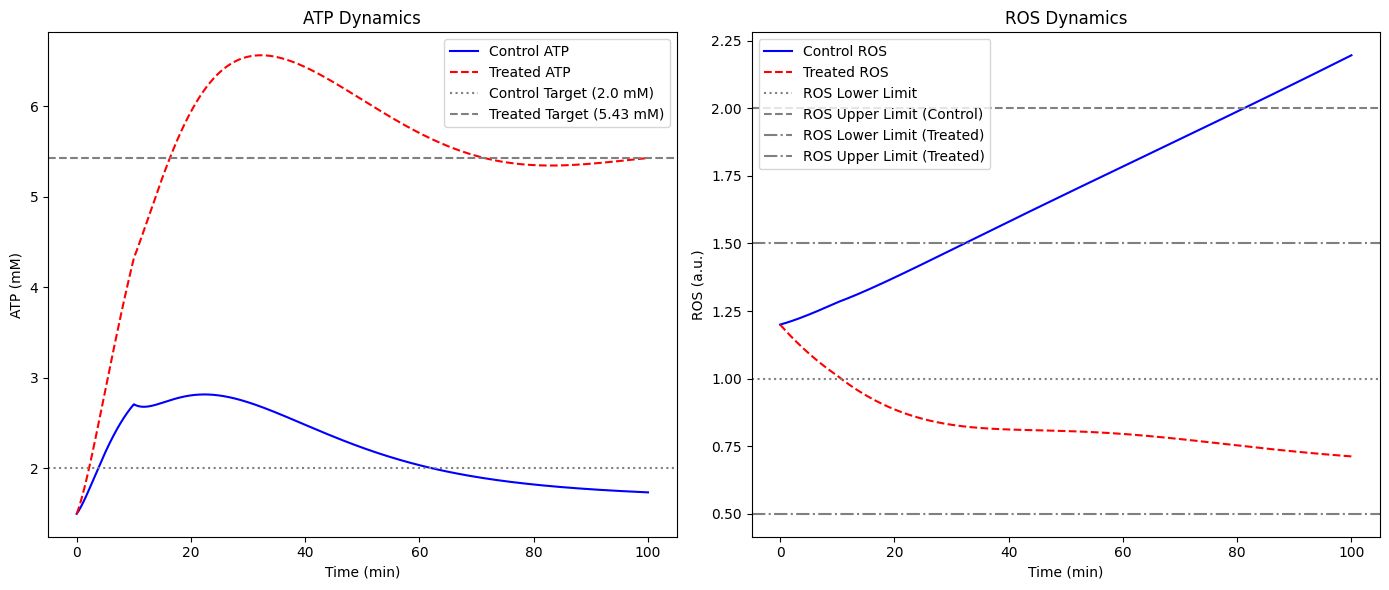

In [34]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - \
               (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters (with tweaks)
params_control = {
    'k_glyc': 0.33,      # Increased from 0.32
    'u': 0.5,
    's': 0.1,
    'g': 0.017,          # Decreased from 0.018
    'h': 0.001,
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.007,     # Decreased from 0.008
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Treated parameters (minor tweak)
params_treated = {
    'k_glyc': 0.33,
    'u': 0.5,
    's': 0.1,
    'g': 0.017,
    'h': 0.001,
    'r': 0.106,          # Increased from 0.105
    'i_glyc': 0.3,
    'd': 0.5,
    'Nano_DOX_max': 0.01,
    'Nano_ROS': 0.05,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.02,
    'S_max': 0.01,
    'beta_p': 0.02,
    'beta_i': 0.012,
    'A_target': 5.43,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time and initial conditions
t = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # [ATP, ROS, Glucose, Integral]

# Run simulations
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# Plot results (optional visualization)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()

Control final values:
ATP: 1.740 mM
ROS: 2.176 a.u.
Glucose: 2.347

Treated final values:
ATP: 5.432 mM
ROS: 0.697 a.u.
Glucose: 4.182


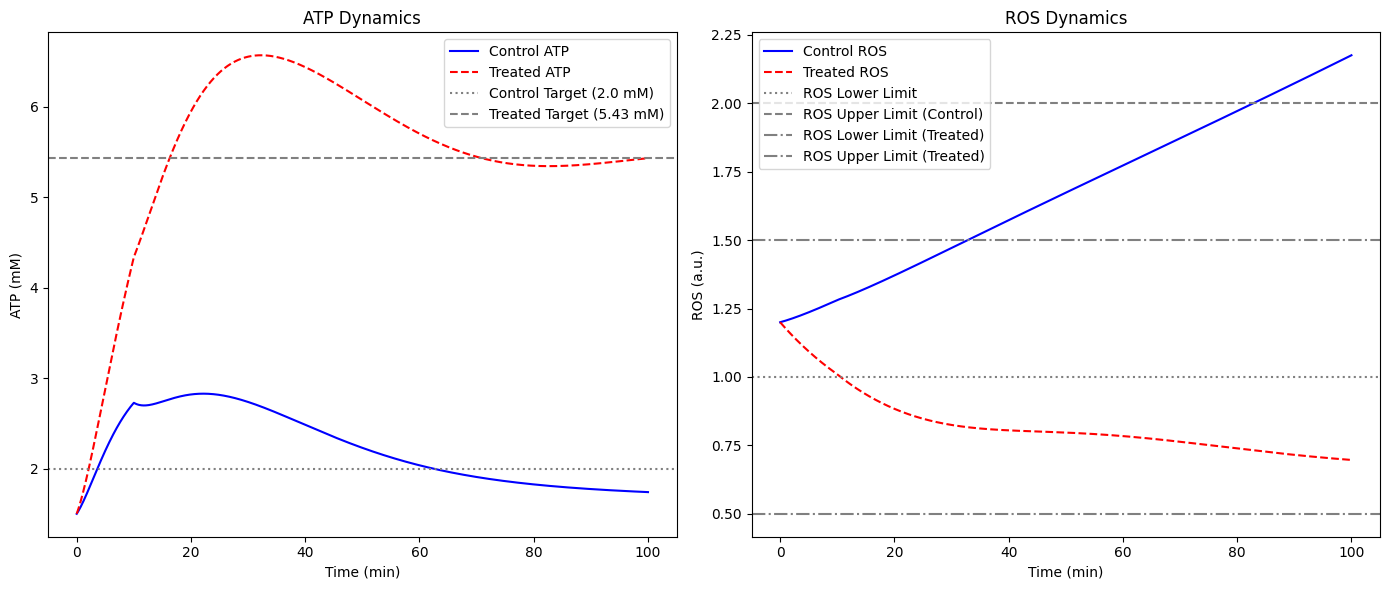

In [35]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - \
               (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters (with tweaks)
params_control = {
    'k_glyc': 0.34,      # Increased from 0.33
    'u': 0.5,
    's': 0.1,
    'g': 0.0165,         # Decreased from 0.017
    'h': 0.001,
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.0065,    # Decreased from 0.007
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Treated parameters (minor tweak)
params_treated = {
    'k_glyc': 0.34,
    'u': 0.5,
    's': 0.1,
    'g': 0.0165,
    'h': 0.001,
    'r': 0.1065,         # Increased from 0.106
    'i_glyc': 0.3,
    'd': 0.5,
    'Nano_DOX_max': 0.01,
    'Nano_ROS': 0.05,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.02,
    'S_max': 0.01,
    'beta_p': 0.02,
    'beta_i': 0.012,
    'A_target': 5.43,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time and initial conditions
t = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # [ATP, ROS, Glucose, Integral]

# Run simulations
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# Plot results (optional visualization)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()

Control final values:
ATP: 1.753 mM
ROS: 2.125 a.u.
Glucose: 2.283

Treated final values:
ATP: 5.437 mM
ROS: 0.679 a.u.
Glucose: 4.065


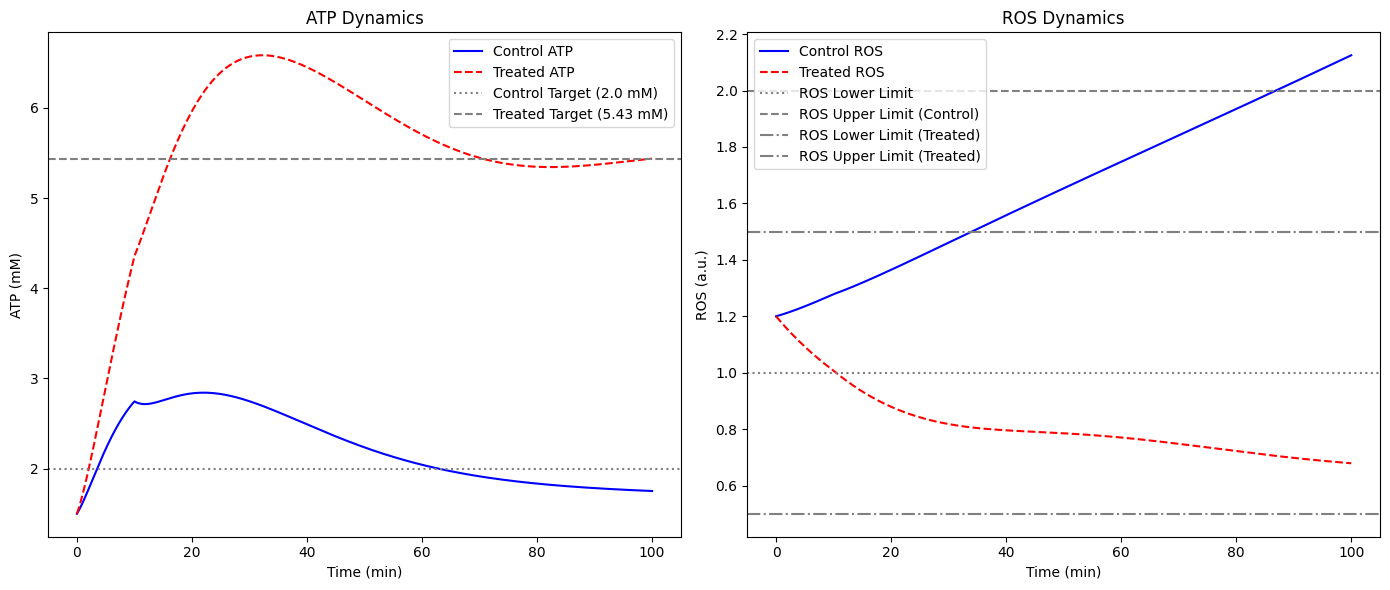

In [36]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - \
               (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters (with tweaks)
params_control = {
    'k_glyc': 0.35,      # Increased from 0.34
    'u': 0.5,
    's': 0.1,
    'g': 0.016,          # Decreased from 0.0165
    'h': 0.0009,         # Decreased from 0.001
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,     # Decreased from 0.0065
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Treated parameters (minor tweak)
params_treated = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.1067,         # Increased from 0.1065
    'i_glyc': 0.3,
    'd': 0.5,
    'Nano_DOX_max': 0.01,
    'Nano_ROS': 0.05,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.02,
    'S_max': 0.01,
    'beta_p': 0.02,
    'beta_i': 0.012,
    'A_target': 5.43,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time and initial conditions
t = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # [ATP, ROS, Glucose, Integral]

# Run simulations
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# Plot results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Step function for drug administration
def step_function(t, t_peak):
    return np.heaviside(t - t_peak, 1)

# ODE system
def tnbc_system(y, t, k_glyc, u, s, g, h, r, i_glyc, d, Nano_DOX_max, Nano_ROS,
                delta_A, k_quercetin, Q_max, k_scavenger, S_max, beta_p, beta_i, A_target, A_max, K_m, R_max):
    A, R_os, G_lc, I = y
    Q = Q_max * step_function(t, 10)
    S = S_max * step_function(t, 10)
    Nano_DOX = Nano_DOX_max * step_function(t, 10)
    k_glyc_eff = k_glyc * (1 - k_quercetin * Q)
    g_eff = g * (1 - k_scavenger * S)
    dA_dt = (k_glyc_eff * G_lc * (A_max - A) / A_max) - (s * R_os * A) + \
            (r * (Nano_DOX + Nano_ROS) * A / (K_m + A)) - (delta_A * A) - \
            (beta_p * (A - A_target)) - (beta_i * I)
    dI_dt = A - A_target
    dR_os_dt = (g_eff * k_glyc_eff * G_lc * (R_max - R_os) / R_max) + (h * R_os**2) - \
               (d * Nano_ROS * R_os)
    dG_lc_dt = u - (k_glyc_eff * G_lc * (A_max - A) / A_max) - (i_glyc * Nano_DOX)
    return [dA_dt, dR_os_dt, dG_lc_dt, dI_dt]

# Control parameters (with tweaks)
params_control = {
    'k_glyc': 0.35,      # Increased from 0.34
    'u': 0.5,
    's': 0.1,
    'g': 0.016,          # Decreased from 0.0165
    'h': 0.0009,         # Decreased from 0.001
    'r': 0.0,
    'i_glyc': 0.3,
    'd': 1.0,
    'Nano_DOX_max': 0,
    'Nano_ROS': 0,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.0,
    'S_max': 0.0,
    'beta_p': 0.006,     # Decreased from 0.0065
    'beta_i': 0.005,
    'A_target': 2.0,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Treated parameters (minor tweak)
params_treated = {
    'k_glyc': 0.35,
    'u': 0.5,
    's': 0.1,
    'g': 0.016,
    'h': 0.0009,
    'r': 0.1067,         # Increased from 0.1065
    'i_glyc': 0.3,
    'd': 0.5,
    'Nano_DOX_max': 0.01,
    'Nano_ROS': 0.05,
    'delta_A': 0.01,
    'k_quercetin': 0.8,
    'Q_max': 0.3,
    'k_scavenger': 0.02,
    'S_max': 0.01,
    'beta_p': 0.02,
    'beta_i': 0.012,
    'A_target': 5.43,
    'A_max': 10.0,
    'K_m': 1.0,
    'R_max': 5.0
}

# Time and initial conditions
t = np.linspace(0, 100, 1000)
y0 = [1.5, 1.2, 1.0, 0.0]  # [ATP, ROS, Glucose, Integral]

# Run simulations
sol_control = odeint(tnbc_system, y0, t, args=tuple(params_control.values()))
sol_treated = odeint(tnbc_system, y0, t, args=tuple(params_treated.values()))

# Print final values
print("Control final values:")
print(f"ATP: {sol_control[-1, 0]:.3f} mM")
print(f"ROS: {sol_control[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_control[-1, 2]:.3f}")

print("\nTreated final values:")
print(f"ATP: {sol_treated[-1, 0]:.3f} mM")
print(f"ROS: {sol_treated[-1, 1]:.3f} a.u.")
print(f"Glucose: {sol_treated[-1, 2]:.3f}")

# Plot results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t, sol_control[:, 0], label='Control ATP', color='blue')
plt.plot(t, sol_treated[:, 0], label='Treated ATP', color='red', linestyle='--')
plt.axhline(y=2.0, color='gray', linestyle=':', label='Control Target (2.0 mM)')
plt.axhline(y=5.43, color='gray', linestyle='--', label='Treated Target (5.43 mM)')
plt.xlabel('Time (min)')
plt.ylabel('ATP (mM)')
plt.title('ATP Dynamics')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol_control[:, 1], label='Control ROS', color='blue')
plt.plot(t, sol_treated[:, 1], label='Treated ROS', color='red', linestyle='--')
plt.axhline(y=1.0, color='gray', linestyle=':', label='ROS Lower Limit')
plt.axhline(y=2.0, color='gray', linestyle='--', label='ROS Upper Limit (Control)')
plt.axhline(y=0.5, color='gray', linestyle='-.', label='ROS Lower Limit (Treated)')
plt.axhline(y=1.5, color='gray', linestyle='-.', label='ROS Upper Limit (Treated)')
plt.xlabel('Time (min)')
plt.ylabel('ROS (a.u.)')
plt.title('ROS Dynamics')
plt.legend()

plt.tight_layout()
plt.show()